# Calibration of the Optimal Steps Model

This script is an attempt to recompute the results in silver-2016b page 51. The scenario [scenario](./../../../../VadereModelTests/TestOSM_calibration/rimea_04_calibration_osm.scenario) is based on the RiMEA-Test 4. We use the `Teleporter` to model a circular scenario and the parameter `useFreeSpaceOnly = false` to generate high densities. The following code plots all the necessary diagrams.

In [5]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
# from vadere_analysis_tool import ScenarioOutput, VadereProject
from vadereanalysistool import ScenarioOutput, VadereProject
from scipy.optimize import curve_fit
import re
from os.path import join

sns.set(style="whitegrid")
sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 2.0})

def plotEvolution(project, ending, yval, ylabel, export_prefix=""):
    plots = []
    i = 1
    width = 15* len(project.output_dirs)
    axNum = len(project.output_dirs)
    plt.figure(1, figsize=(width, 10))
    for outStr in project.output_dirs :
        out = project.output_dirs[outStr]
        dataFrames = []
        for fileStr in out.files :
            if fileStr.endswith(ending) :
                ndf = pd.DataFrame();
                df = out.files[fileStr]()
                #df = df[df.velocity > 0]
                ndf['density'] = df.density.astype(float)
                ndf['velocity'] = df.velocity.astype(float)
                ndf['timeStep'] = df.timeStep.astype(int)
                ndf['scenario'] = [out.scenario['name']] * len(df.density)
                dataFrames.append(ndf)
            #concatFrames = pd.concat(dataFrames)
        plt.subplot(axNum, 1, i)
        plt.title(out.scenario['name'])
        plt.xlabel('timeStep')
        plt.ylabel(ylabel)
        sns.lineplot(x='timeStep', y=yval, data=pd.concat(dataFrames))
        i = i + 1
    plt.savefig("./"+export_prefix+"plotEvolution_"+ylabel+".png", bbox_inches='tight')


    
    
def plotFundamentalDiagram(vproject, ending,export_prefix=""):
    dataFrames = []
    for outStr in project.output_dirs :
        out = project.output_dirs[outStr]
        for fileStr in out.files :
            if fileStr.endswith(ending) :
                ndf = pd.DataFrame();
                df = out.files[fileStr]()
                ndf['density'] = df.density.astype(float)
                ndf['velocity'] = df.velocity.astype(float)
                ndf['scenario'] = [out.scenario['name']] * len(df.velocity)
                #ndf = ndf[ndf.density < 7]
                dataFrames.append(ndf)
    concatFrames = pd.concat(dataFrames)
    g = sns.relplot(x="density", y="velocity", hue="scenario", data=concatFrames,
                height=10, aspect=2)

def createFundamentalDiagramScatterPlot(fig, axes, data, scenario_name):
    ndf = pd.DataFrame()
    ndf['density'] = data.density.astype(float)
    ndf['velocity'] = data.velocity.astype(float)
    ndf['scenario'] = scenario_name * len(data.velocity)
    axes.set_xlabel('density')
    axes.set_ylabel('velocity')
    axes.set_xticks([0,1,2,3,4,5,6])
    axes.set_yticks([0,0.5,1,1.5,2,2.5])
    axes.set_xlim(0,6)
    axes.set_ylim(0,2.5)
    axes.scatter(ndf['density'], ndf['velocity'], s=0.7, marker='*', color='#555555')
    wm = plotWeidmann(axes)
    popt, pcov = curve_fit(kladek, ndf['density'], ndf['velocity'], p0=(1.34, 1.913, 5.4))
    print(str(popt[0]) + "," + str(popt[1]) + "," + str(popt[2]))
    xx = np.linspace(0.1, 6, 1000)
    yy = kladek(xx, *popt)
    axes.plot(xx, yy, '--', c=sns.color_palette().as_hex()[1])
    axes.set_title(scenario_name)
    axes.legend(['Weidmann', 'regression', 'Simulated data'])

    
def plotFundamentalDiagramScatter2(outputs, processor_names, separte_fig, height, width, offset=0, export_path="", offset_gen=None):
    cols = len(processor_names)
    rows = len(outputs)
    print(f"{height*rows} = {height} * {rows}")
    print(f"{width*cols} = {width} * {cols}")
    
    if not separte_fig:
        fig, axs = plt.subplots(int(rows), int(cols), figsize=(width*cols, height*rows), sharex=False, sharey=True)
    index = 0
    for output in outputs:
        
        if separte_fig:
            fig, axs = plt.subplots(1, int(cols), figsize=(width*cols, height*1), sharex=False, sharey=True)
            axs = [plt.subplot2grid((2,2), (0,0)),
                   plt.subplot2grid((2,2), (1,0)),
                   plt.subplot2grid((2,2), (1,1))]
            fig.suptitle(output.scenario['name'], fontsize=32)
                
        for processor in processor_names:
            data = output.files[processor]()
            if separte_fig:
                axes= axs[index]
                axes_name = f"{processor} ({output.output_dir_name})"
            else:
                axes= axs[int(index / cols), int(index % cols)]
                axes_name = f"{output.scenario['name']}:{processor} ({output.output_dir_name})"
#             createFundamentalDiagramScatterPlot(fig, axes, df, f"{output.scenario['name']}:{processor} ({output.output_dir_name})")
            ndf = pd.DataFrame()
            ndf['density'] = data.density.astype(float)
            ndf['velocity'] = data.velocity.astype(float)
            ndf['scenario'] = output.scenario['name'] * len(data.velocity)
            axes.set_xlabel('density')
            axes.set_ylabel('velocity')
            axes.set_xticks([0,1,2,3,4,5,6])
            axes.set_yticks([0,0.5,1,1.5,2,2.5])
            axes.set_xlim(0,6)
            axes.set_ylim(0,2.5)
            axes.scatter(ndf['density'], ndf['velocity'], s=0.7, marker='*', color='#555555')
            wm = plotWeidmann(axes)
            popt, pcov = curve_fit(kladek, ndf['density'], ndf['velocity'], p0=(1.34, 1.913, 5.4))
            print(str(popt[0]) + "," + str(popt[1]) + "," + str(popt[2]))
            xx = np.linspace(0.1, 6, 1000)
            yy = kladek(xx, *popt)
            axes.plot(xx, yy, '--', c=sns.color_palette().as_hex()[1])
            axes.set_title(axes_name)
            axes.legend(['Weidmann', 'regression', 'Simulated data'])
            index = index + 1
        
        if separte_fig:
            index = 0
            txt = f"--- groupSizeDistribution: {output.scenario['scenario']['topography']['sources'][0]['groupSizeDistribution']} --- "
            txt += f"minStepLength: {output.scenario['scenario']['attributesModel']['org.vadere.state.attributes.models.AttributesOSM']['minStepLength']} ---  stepCircleResolution: {out.scenario['scenario']['attributesModel']['org.vadere.state.attributes.models.AttributesOSM']['stepCircleResolution']} --- "
            txt += f"minimumStepLength: {output.scenario['scenario']['attributesModel']['org.vadere.state.attributes.models.AttributesOSM']['minimumStepLength']} --- "
            fig.text(.25,-.03,txt, fontsize=24)
            if export_path:
                fig.savefig(join(export_path, f"{output.output_dir_name}.png") , bbox_inches='tight')
                
        
    fig.savefig("./XXX"+".png", bbox_inches='tight')
            
def plotFundamentalDiagramScatter(vproject, ending, sep=False, width = 10, height = 5, offset=0, export_prefix="", offset_gen=None):
    dataFrames = []
    index = 0
    cols = 3
    rows = len(vproject.output_dirs) / cols + 1
    if not sep :
        fig, axs = plt.subplots(int(rows), int(cols), figsize=(height*rows, width*cols), sharex=False, sharey=True)       
    for outStr in vproject.output_dirs :
        out = vproject.output_dirs[outStr]
        for fileStr in out.files :
            if fileStr.endswith(ending) :
                if not sep : 
                    axes = axs[int(index / cols), int(index % cols)]
                else :
                    fig = plt.figure(1, figsize=(width, height))
                    axes = plt.axes()
                    fig.add_axes(axes)
                ndf = pd.DataFrame();
                df = out.files[fileStr]()
                if offset_gen is not None:
                    offset = offset_gen(out)
                    print(f"ignore to timestep {offset}")
                print(len(df))
                df = df[offset:] # ignore first n rows defined by offset
                print(len(df))
                plotFundamentalDiagramScatter2(fig, axes, df, f'{out.output_dir_name}: {fileStr}')
                if sep :
                    fig.savefig("./"+export_prefix+out.scenario['name']+"_fundamental_diagram"+".png", bbox_inches='tight')
                    plt.show()
    if not sep :
        fig.savefig("./"+export_prefix+vproject.project_name+"_fundamental_diagrams"+".png", bbox_inches='tight')



In [16]:
a = 5
f"{{dfdf{5}}}"

'{dfdf5}'

In [6]:
def plotWeidmann(axes):
    wmaxDensity = 5.4
    wmeanVelocity = 1.34
    wgamma = 1.913
    wx = np.linspace(0.1, wmaxDensity, 100)
    return plotKladek(wx, wmeanVelocity, wgamma, wmaxDensity, axes)

def plotKladek(x, v, gamma, pmax, axes):
    result, = axes.plot(x, kladek(x, v, gamma, pmax), c=sns.color_palette().as_hex()[0])
    return result

def kladek(x, v, gamma, pmax):
    return v * (1 - np.exp(-gamma * (1/x - 1/pmax)))

In [7]:
def filterOutput(project, output_name_re):
    del_keys = [k for k in project.output_dirs if not output_name_re.match(k)]
    for k in del_keys: del project.output_dirs[k]

def getOffset(out):
    postvis_df = out.files['postvis.trajectories']()
    offset = postvis_df[postvis_df.x > 38]['timeStep'].min()
    return offset + 250


In [8]:
suq_out='/home/lphex/hm.d/groupModelCalibration/vadere_output'
out = ScenarioOutput.create_output_from_suq_output(suq_out, 0)



# Meassurement methods
All methods are described in zhang-2011.

## Method A Plots
The computation of the velocity is slightly different i.e. we use the velocity computed by the current and last foot step.

In [ ]:
# transform data frame
plotFundamentalDiagramScatter(project, "aTimeStep.fundamentalDiagram", True, 6, 6,export_prefix)

## Method B Plots
This method does not work for this scenario since agents run multiple times through the same measurement area.

## Method C Plots
The computation of the velocity is slightly different i.e. we use the velocity computed by the current and last foot step.

In [ ]:
plotFundamentalDiagramScatter(project, "cTimeStep.fundamentalDiagram50m",
                              True, 6, 6, 0,"Y",
                              offset_gen=lambda x: 0)

In [ ]:
plotFundamentalDiagramScatter(project, "cTimeStep.fundamentalDiagram2", True, 6, 6, 0,"2")

In [9]:
# suq_out='/home/lphex/hm.d/groupModelCalibration/vadere_output' # alt
suq_out='/home/lphex/hm.d/groupModelCalibration_run2/groupModelCalibration_run2/vadere_output'
outputs = [ScenarioOutput.create_output_from_suq_output(suq_out, i) for i in range(0,28)]
processors = [f"cTimeStep.fundamentalDiagram{i}m" for i in  ['35', '50', '70']]

504 = 18 * 28
45 = 15 * 3
1.2141483978075638,6.668737223599294,5.279112674891128


/home/lphex/PycharmProjects/venvs/venvHM/lib64/python3.7/site-packages/scipy/optimize/minpack.py:787: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


0.6143810193794514,89.35977496321556,73.08342718969978
0.6822736667194752,56.55036243295984,70.56939928116905
1.214742271950381,6.487363787015806,5.276577097591886
0.6195217225759084,88.49629147230948,69.08178954269349
0.6821817116830807,49.131547052953806,65.01260466111755
1.2125318013580466,7.330048062499827,4.733105662894167
0.6533182654615577,54.40625456103229,60.83089820165117
0.7135471292458763,47.28164044524663,62.8457686767416
1.2669976642159066,4.8651833227796475,4.647181423027725
0.6592873836330512,49.250024413878386,66.29684444094312
0.7183753522078309,43.60625361239778,85.62188289787557
1.3174432478283018,7.237045940864195,5.8435269858931695
0.6865154431763166,65.64408667041998,65.62066080089738
0.7290760451248578,65.15425731529808,33.87234244367755
1.2753581425163476,5.16048303308354,5.74858126975097
0.6483079030764033,54.804989166625404,63.95034140296119
0.6767609687902253,48.96767766271125,63.666701041749455
1.2425454759152679,6.514439604744204,4.882846842906026
0.659522

/home/lphex/PycharmProjects/venvs/venvHM/lib64/python3.7/site-packages/matplotlib-3.0.2-py3.7-linux-x86_64.egg/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


1.1803533010296785,6.5870882628258265,4.914985548182125
0.6120983225905631,85.7059623624872,102.05947208177292
0.6577845737242018,54.831242126327254,68.6874101213361
1.1123316743518599,7.205464846570427,4.716350572505447
0.65956436018094,51.889951684849734,64.45835837938998
0.5713944120312582,51.15032114927871,59.98377054672549
1.0350061091920015,7.602527859980859,4.803936929188036
0.7194003876582105,49.72613532226435,70.48161235786787
0.616453958958365,7.909388205993513,-0.06393198711262205
1.0028278646410587,8.862047505386244,4.8681099890209145
0.5764571954136226,83.9713537911971,80.32396695817891
0.6107827720385651,51.94044554393627,63.66231258669788
0.48186219075166853,22.089374909279428,4.350452555608176


RuntimeError: Optimal parameters not found: Number of calls to function has reached maxfev = 800.

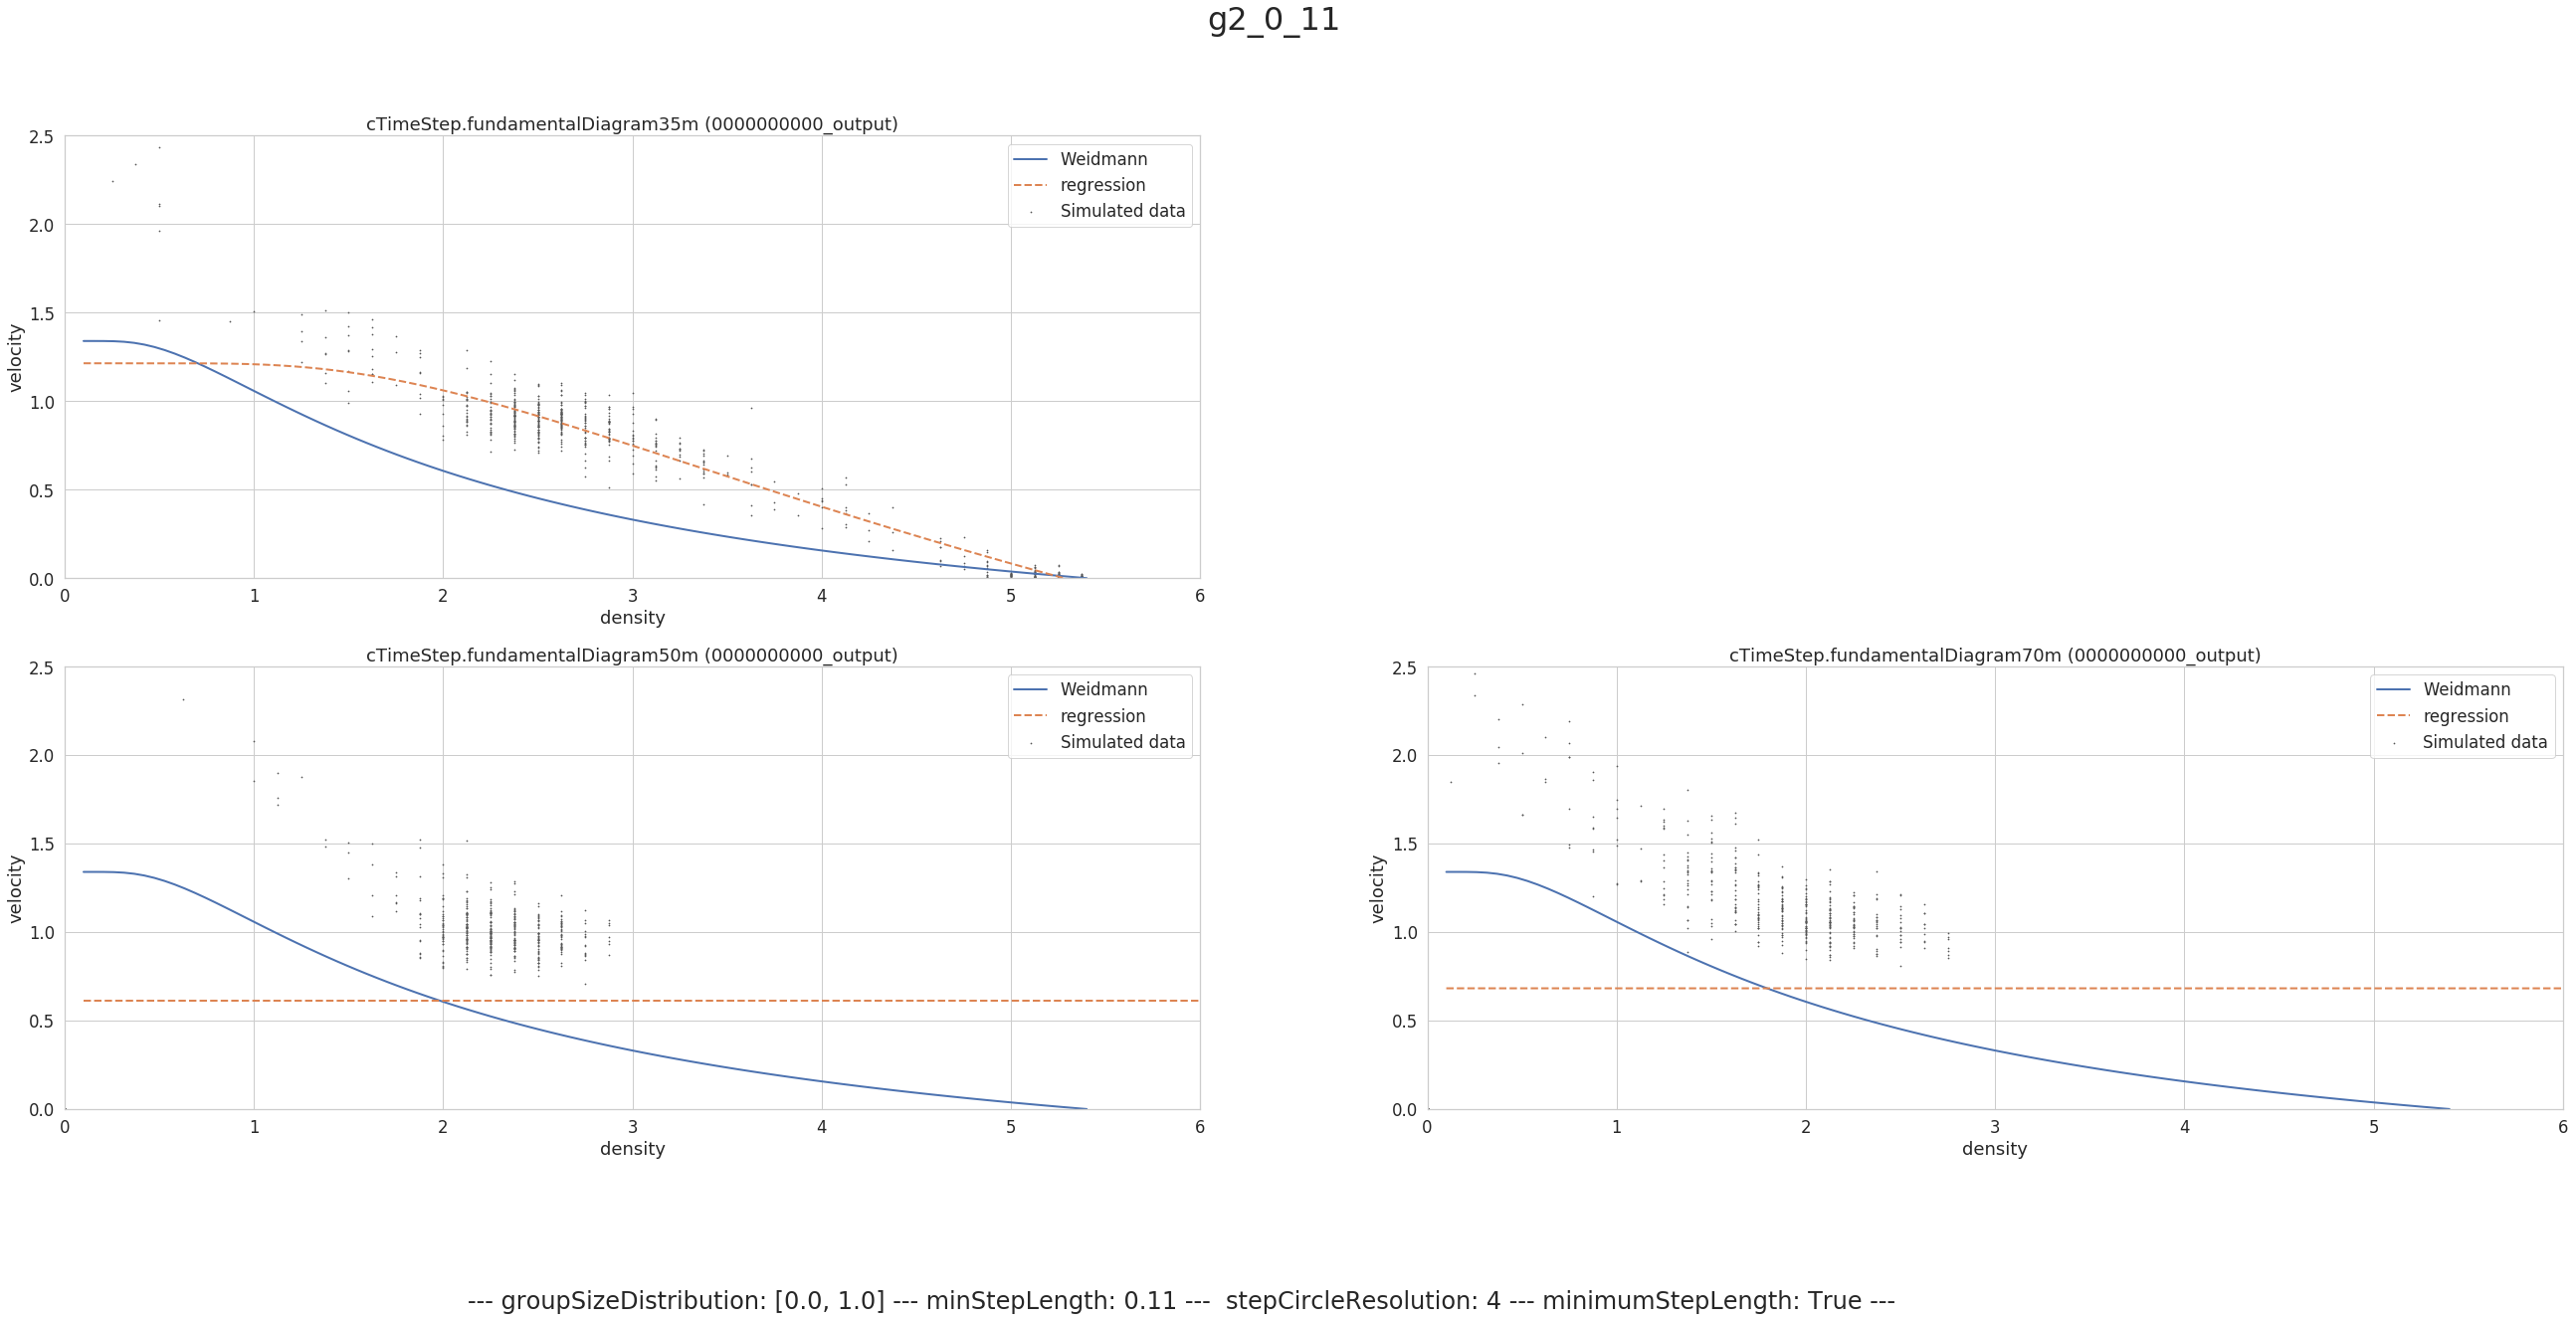

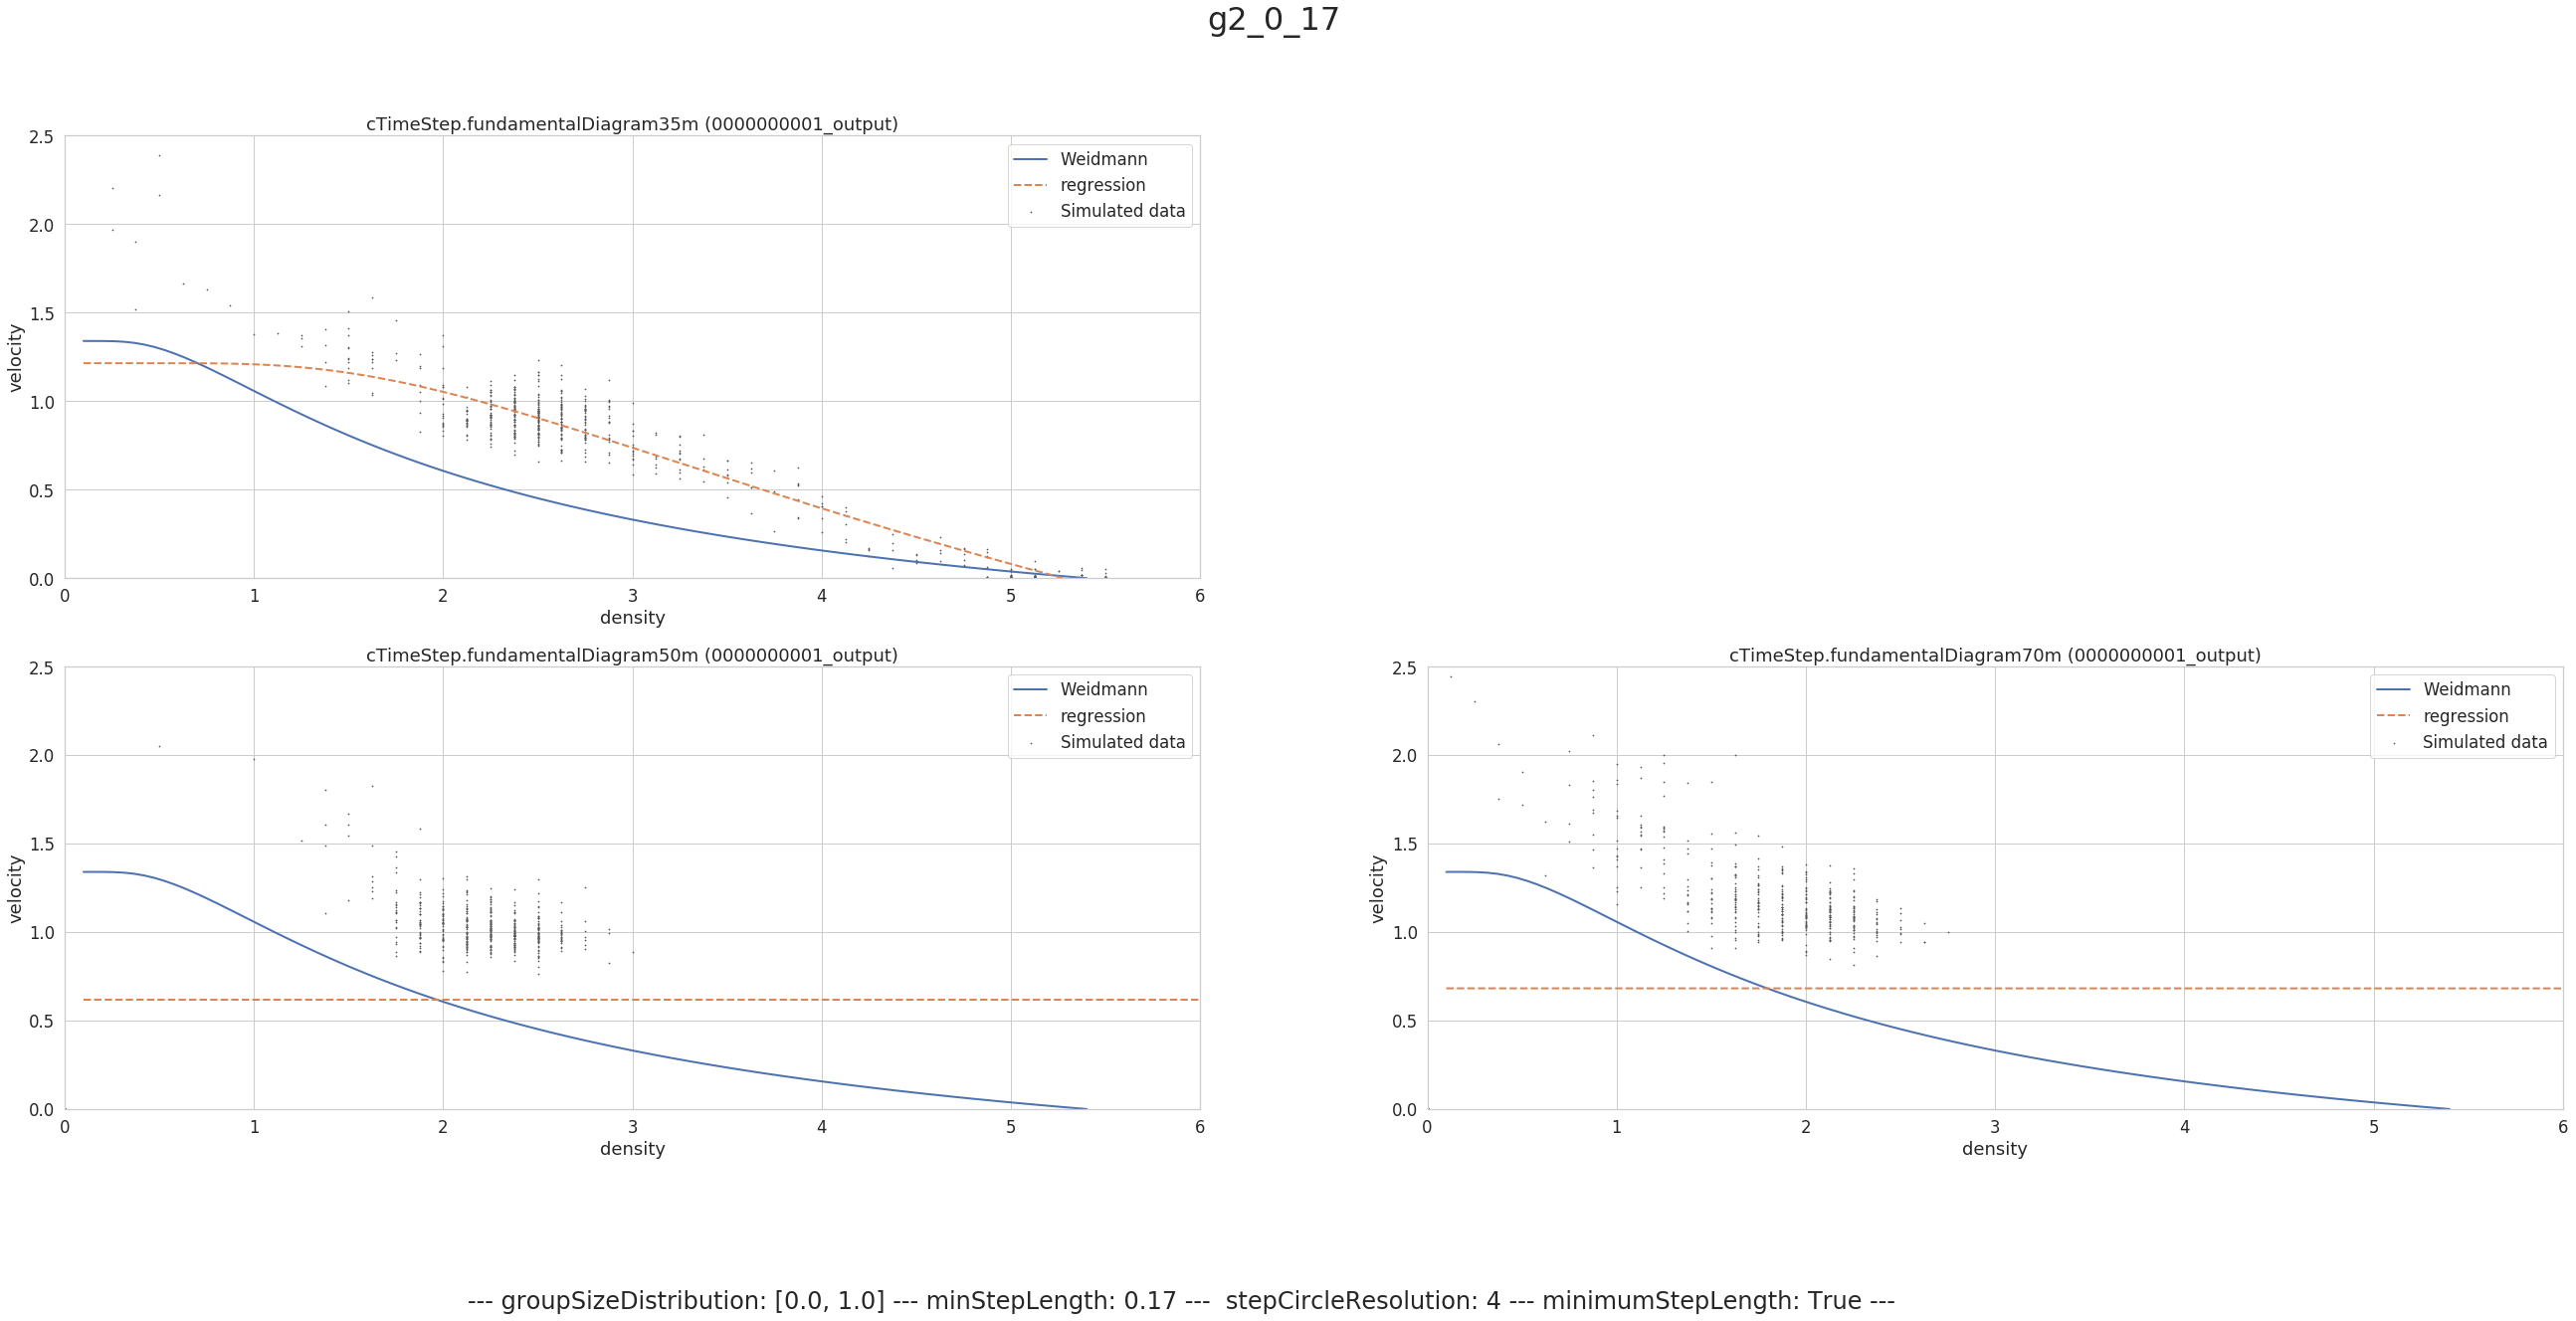

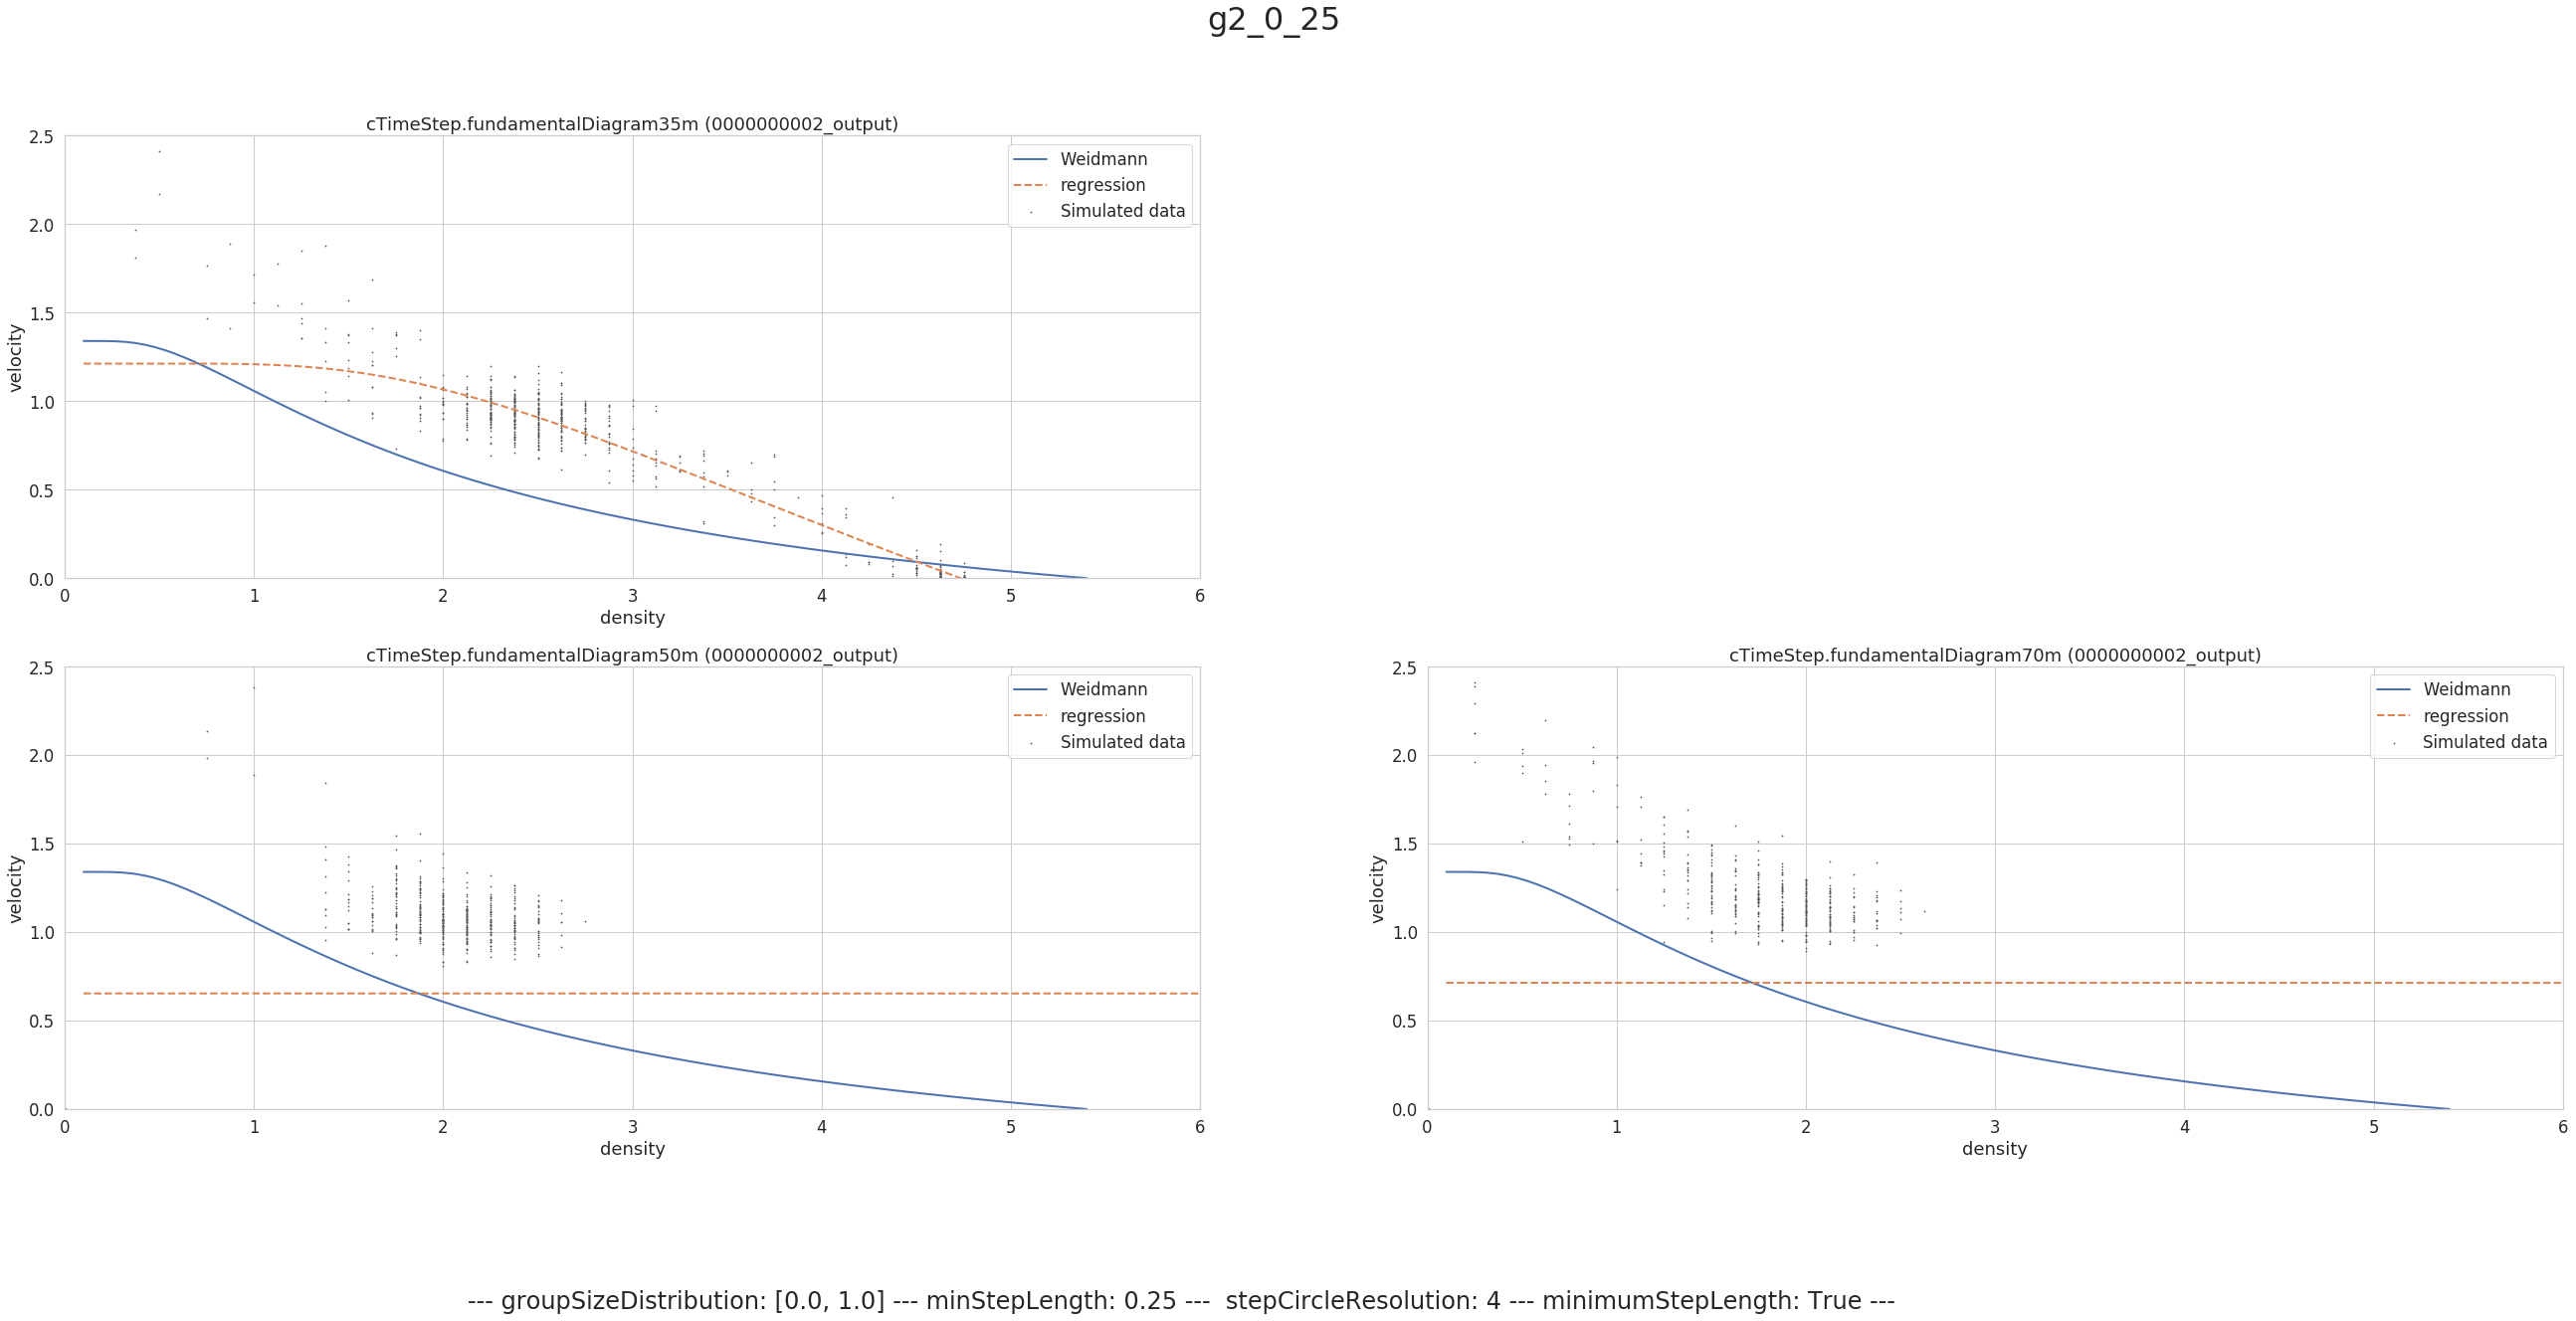

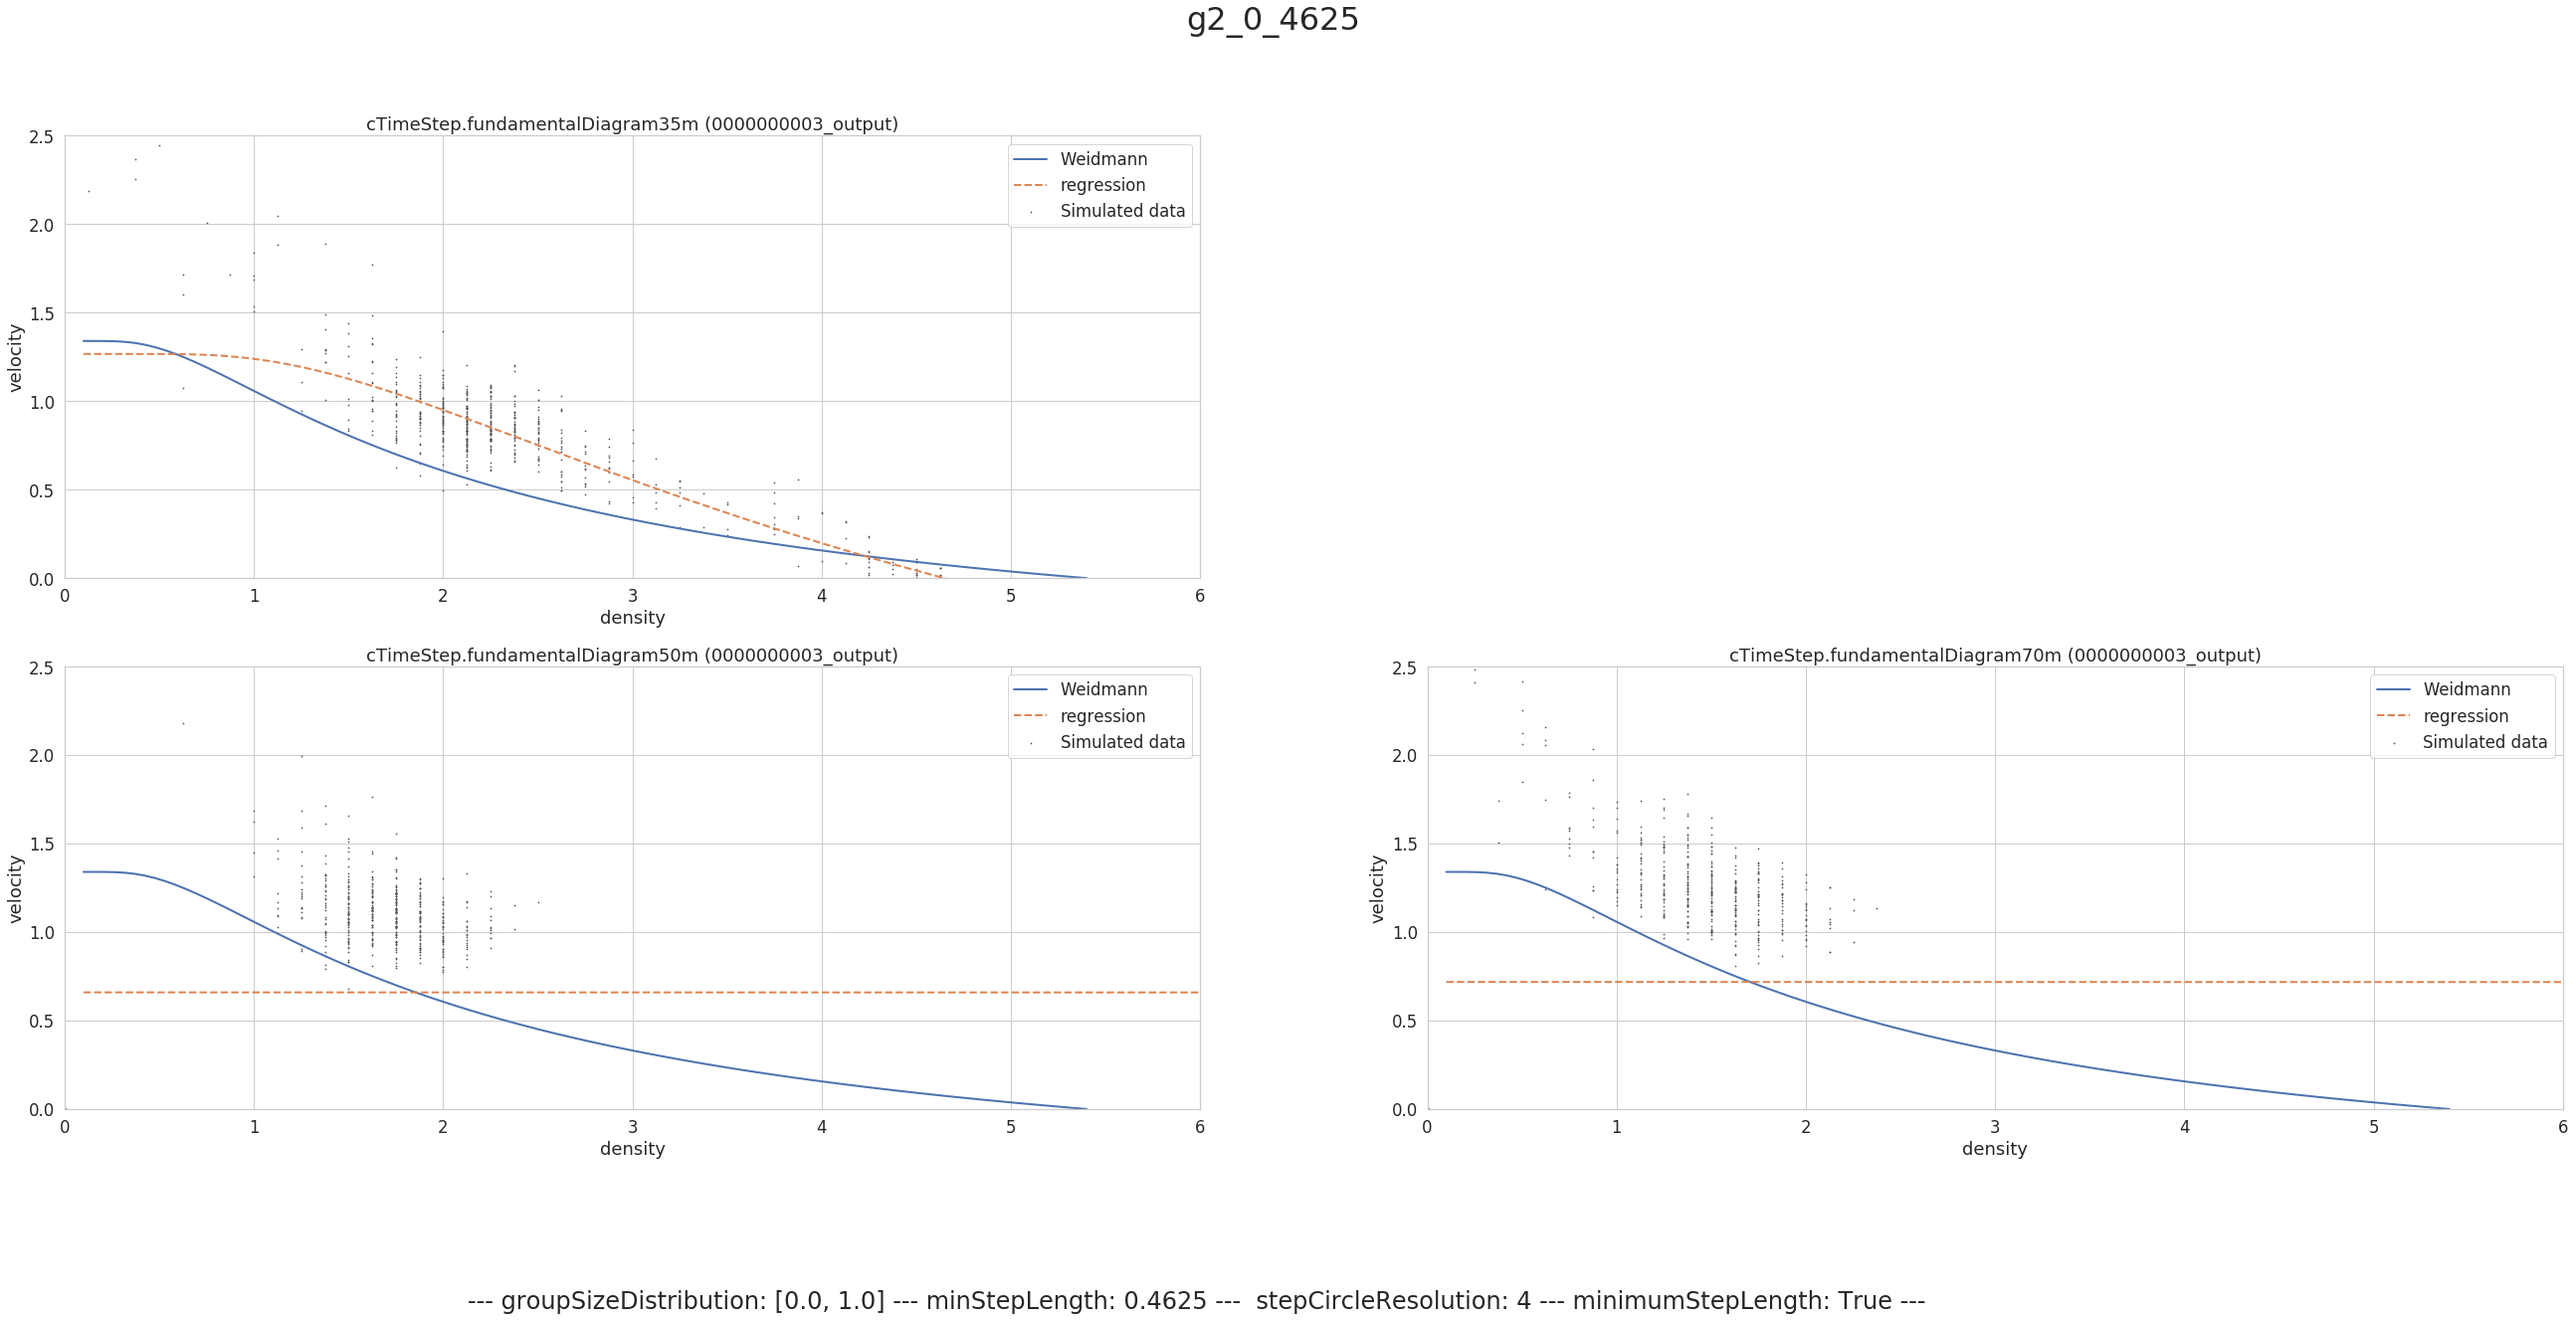

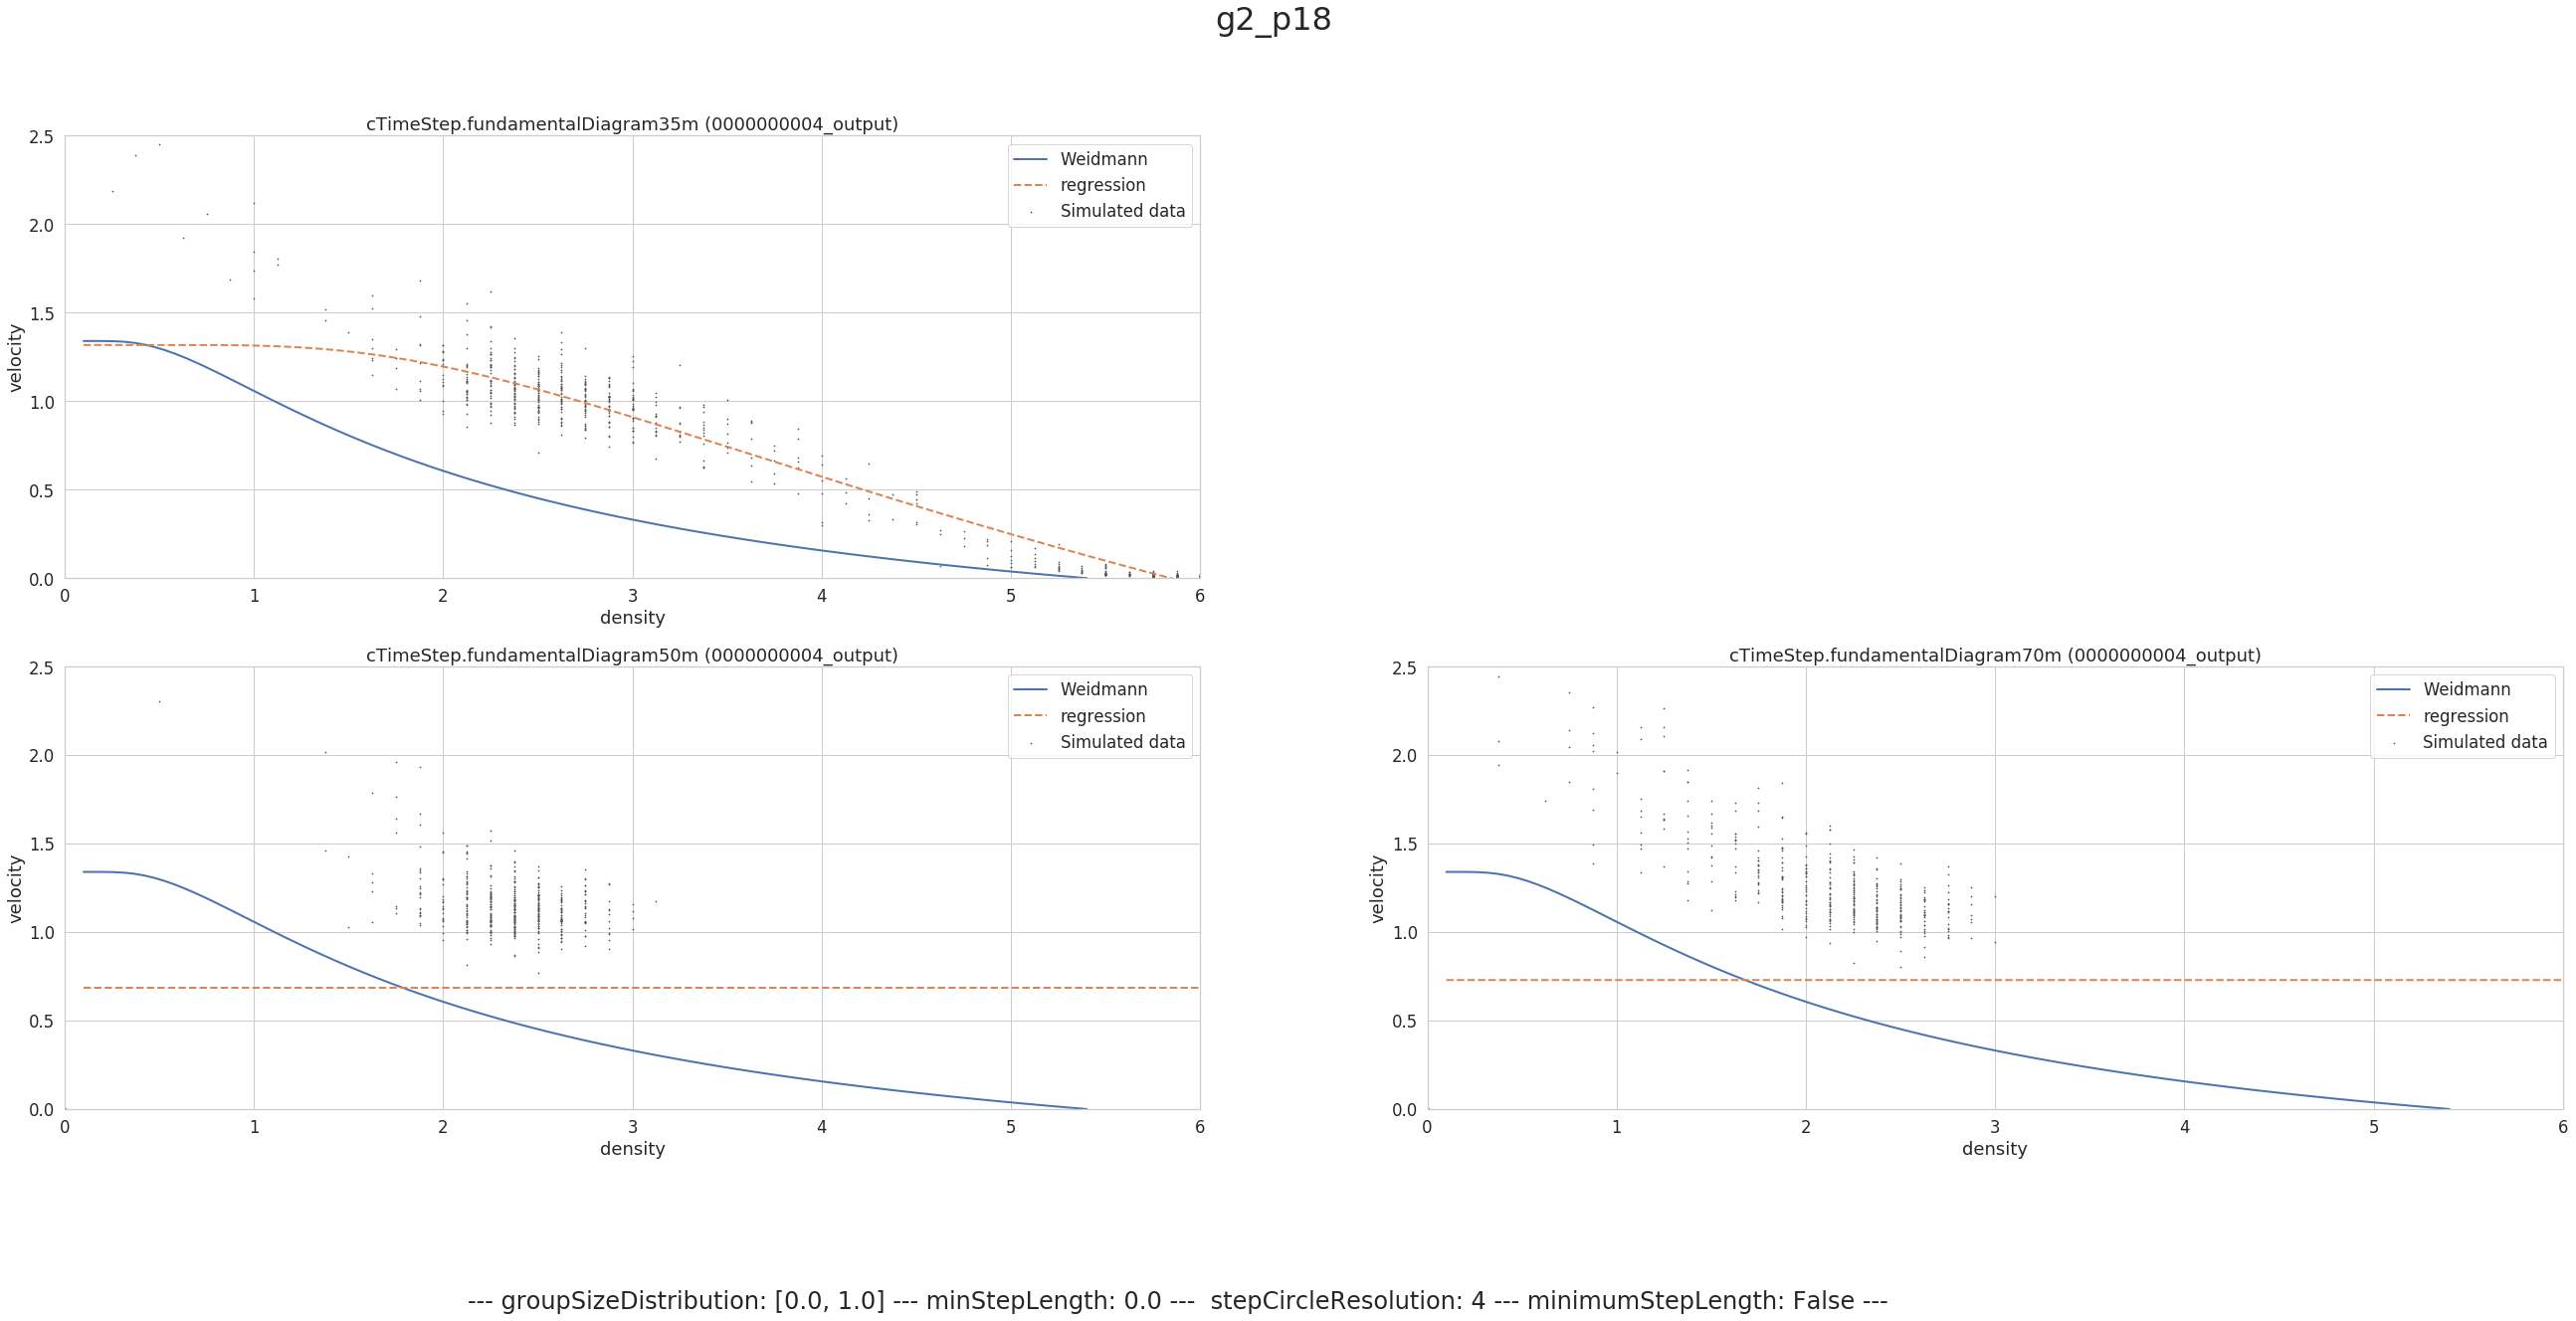

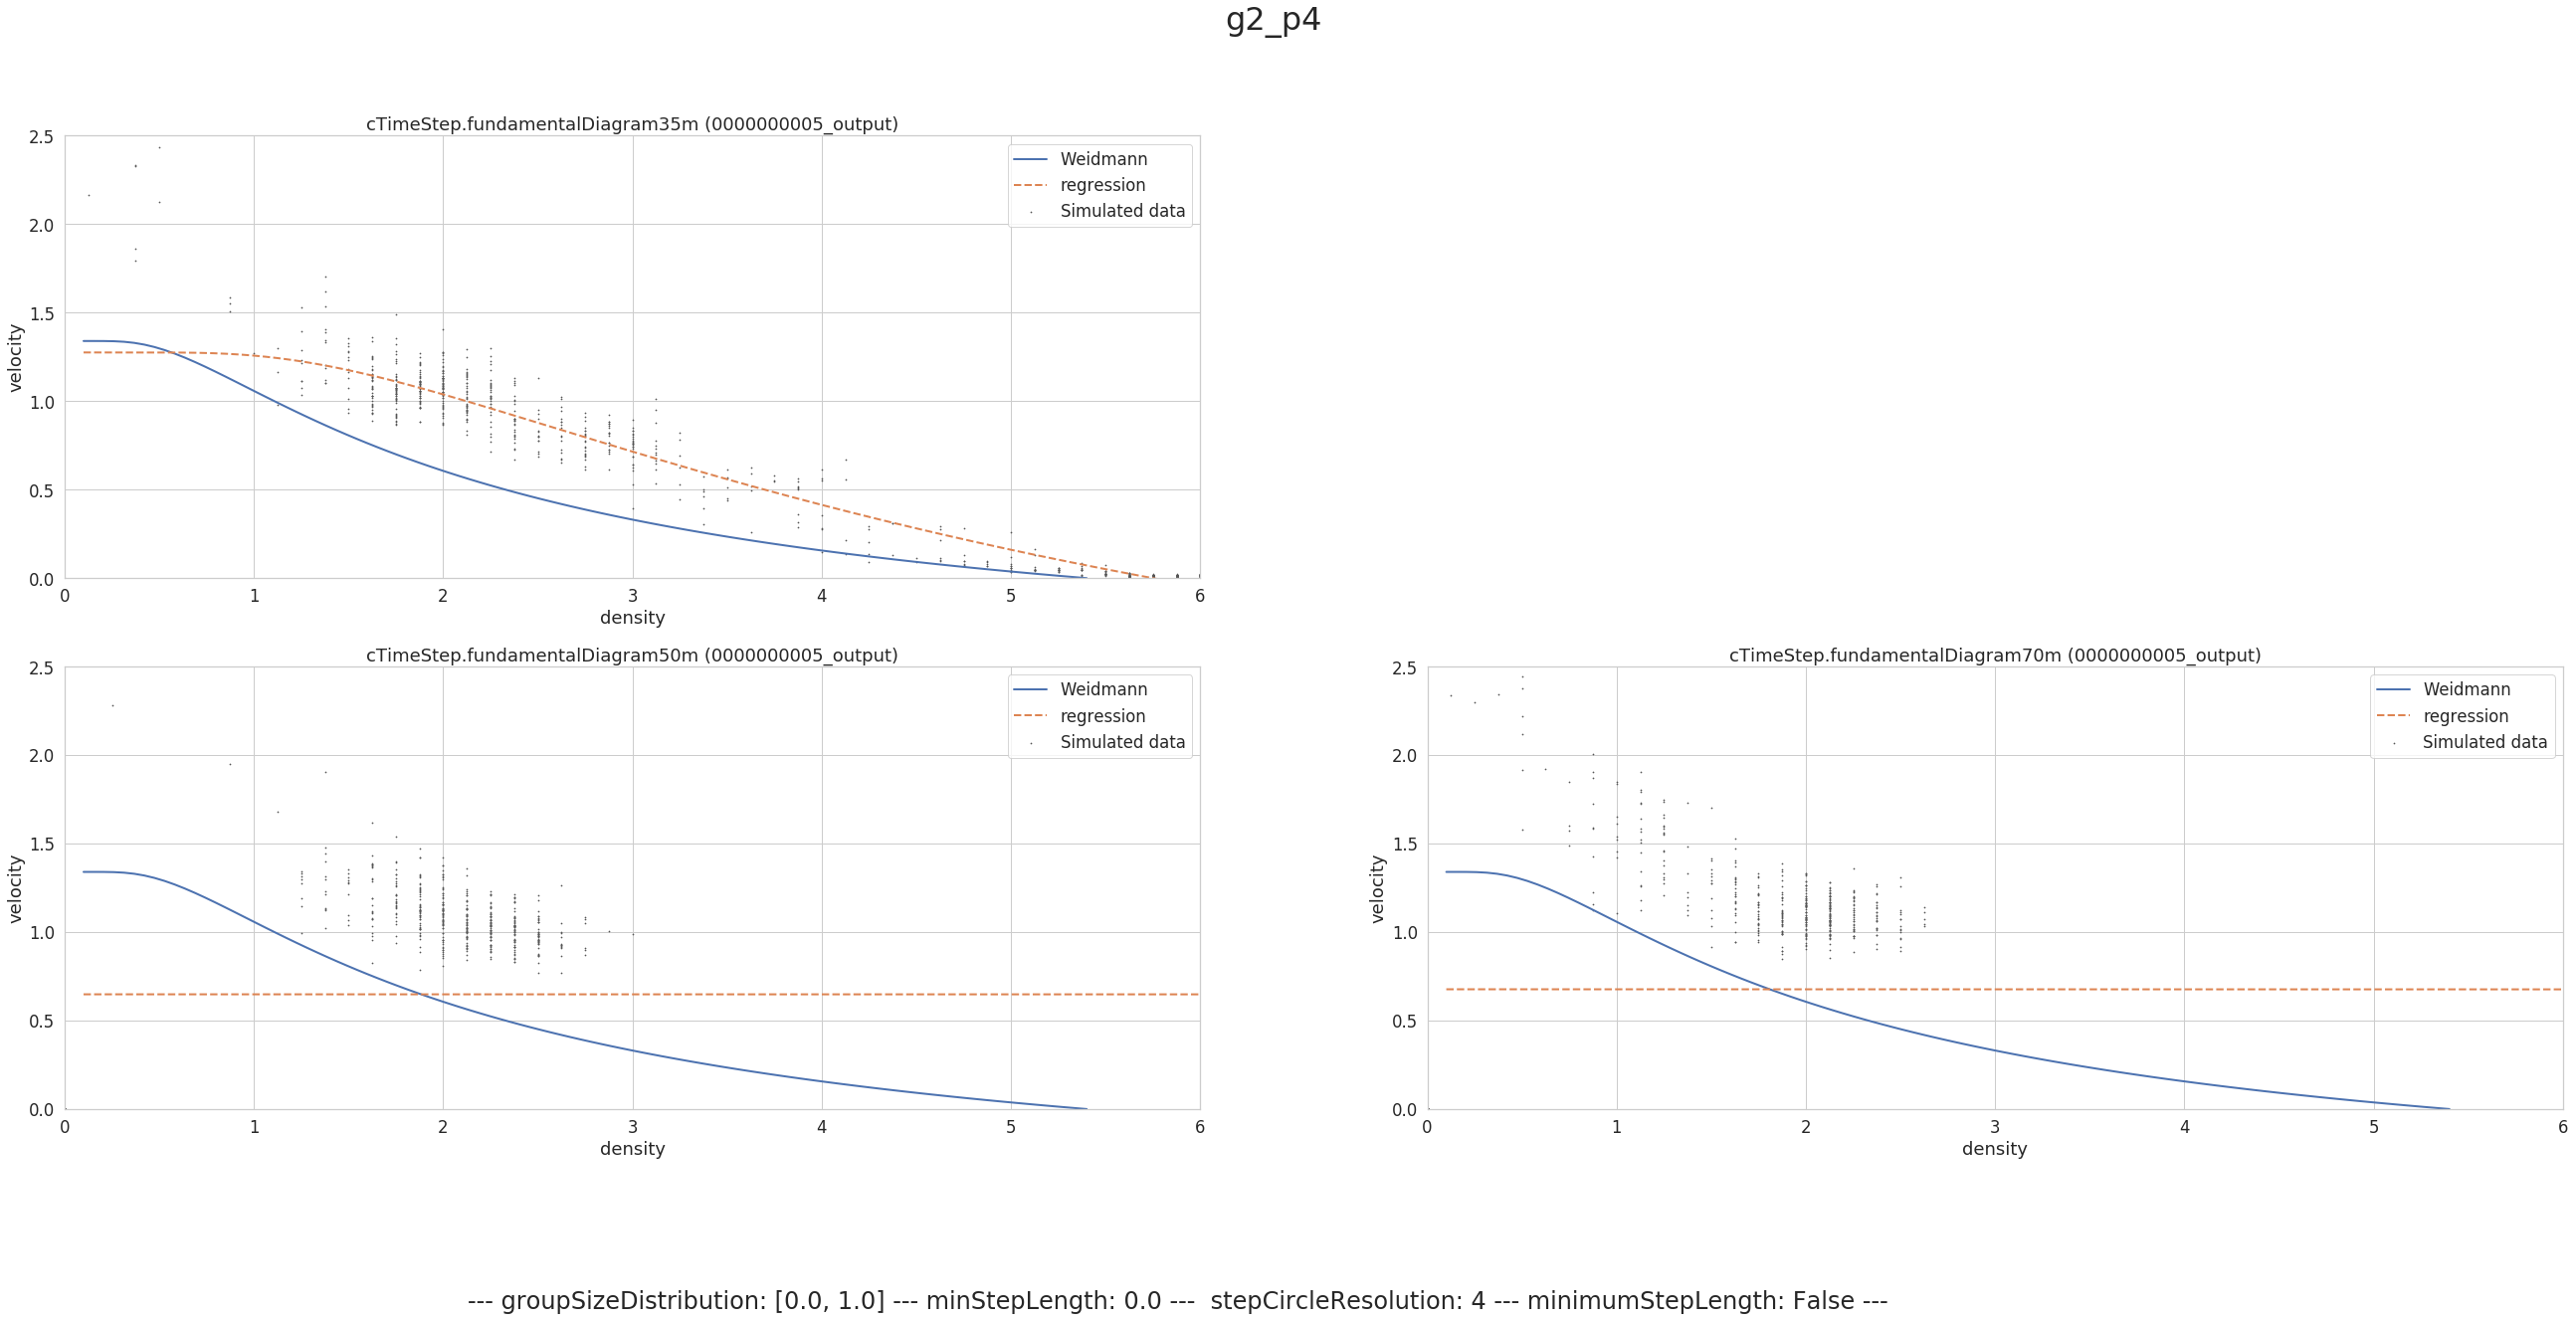

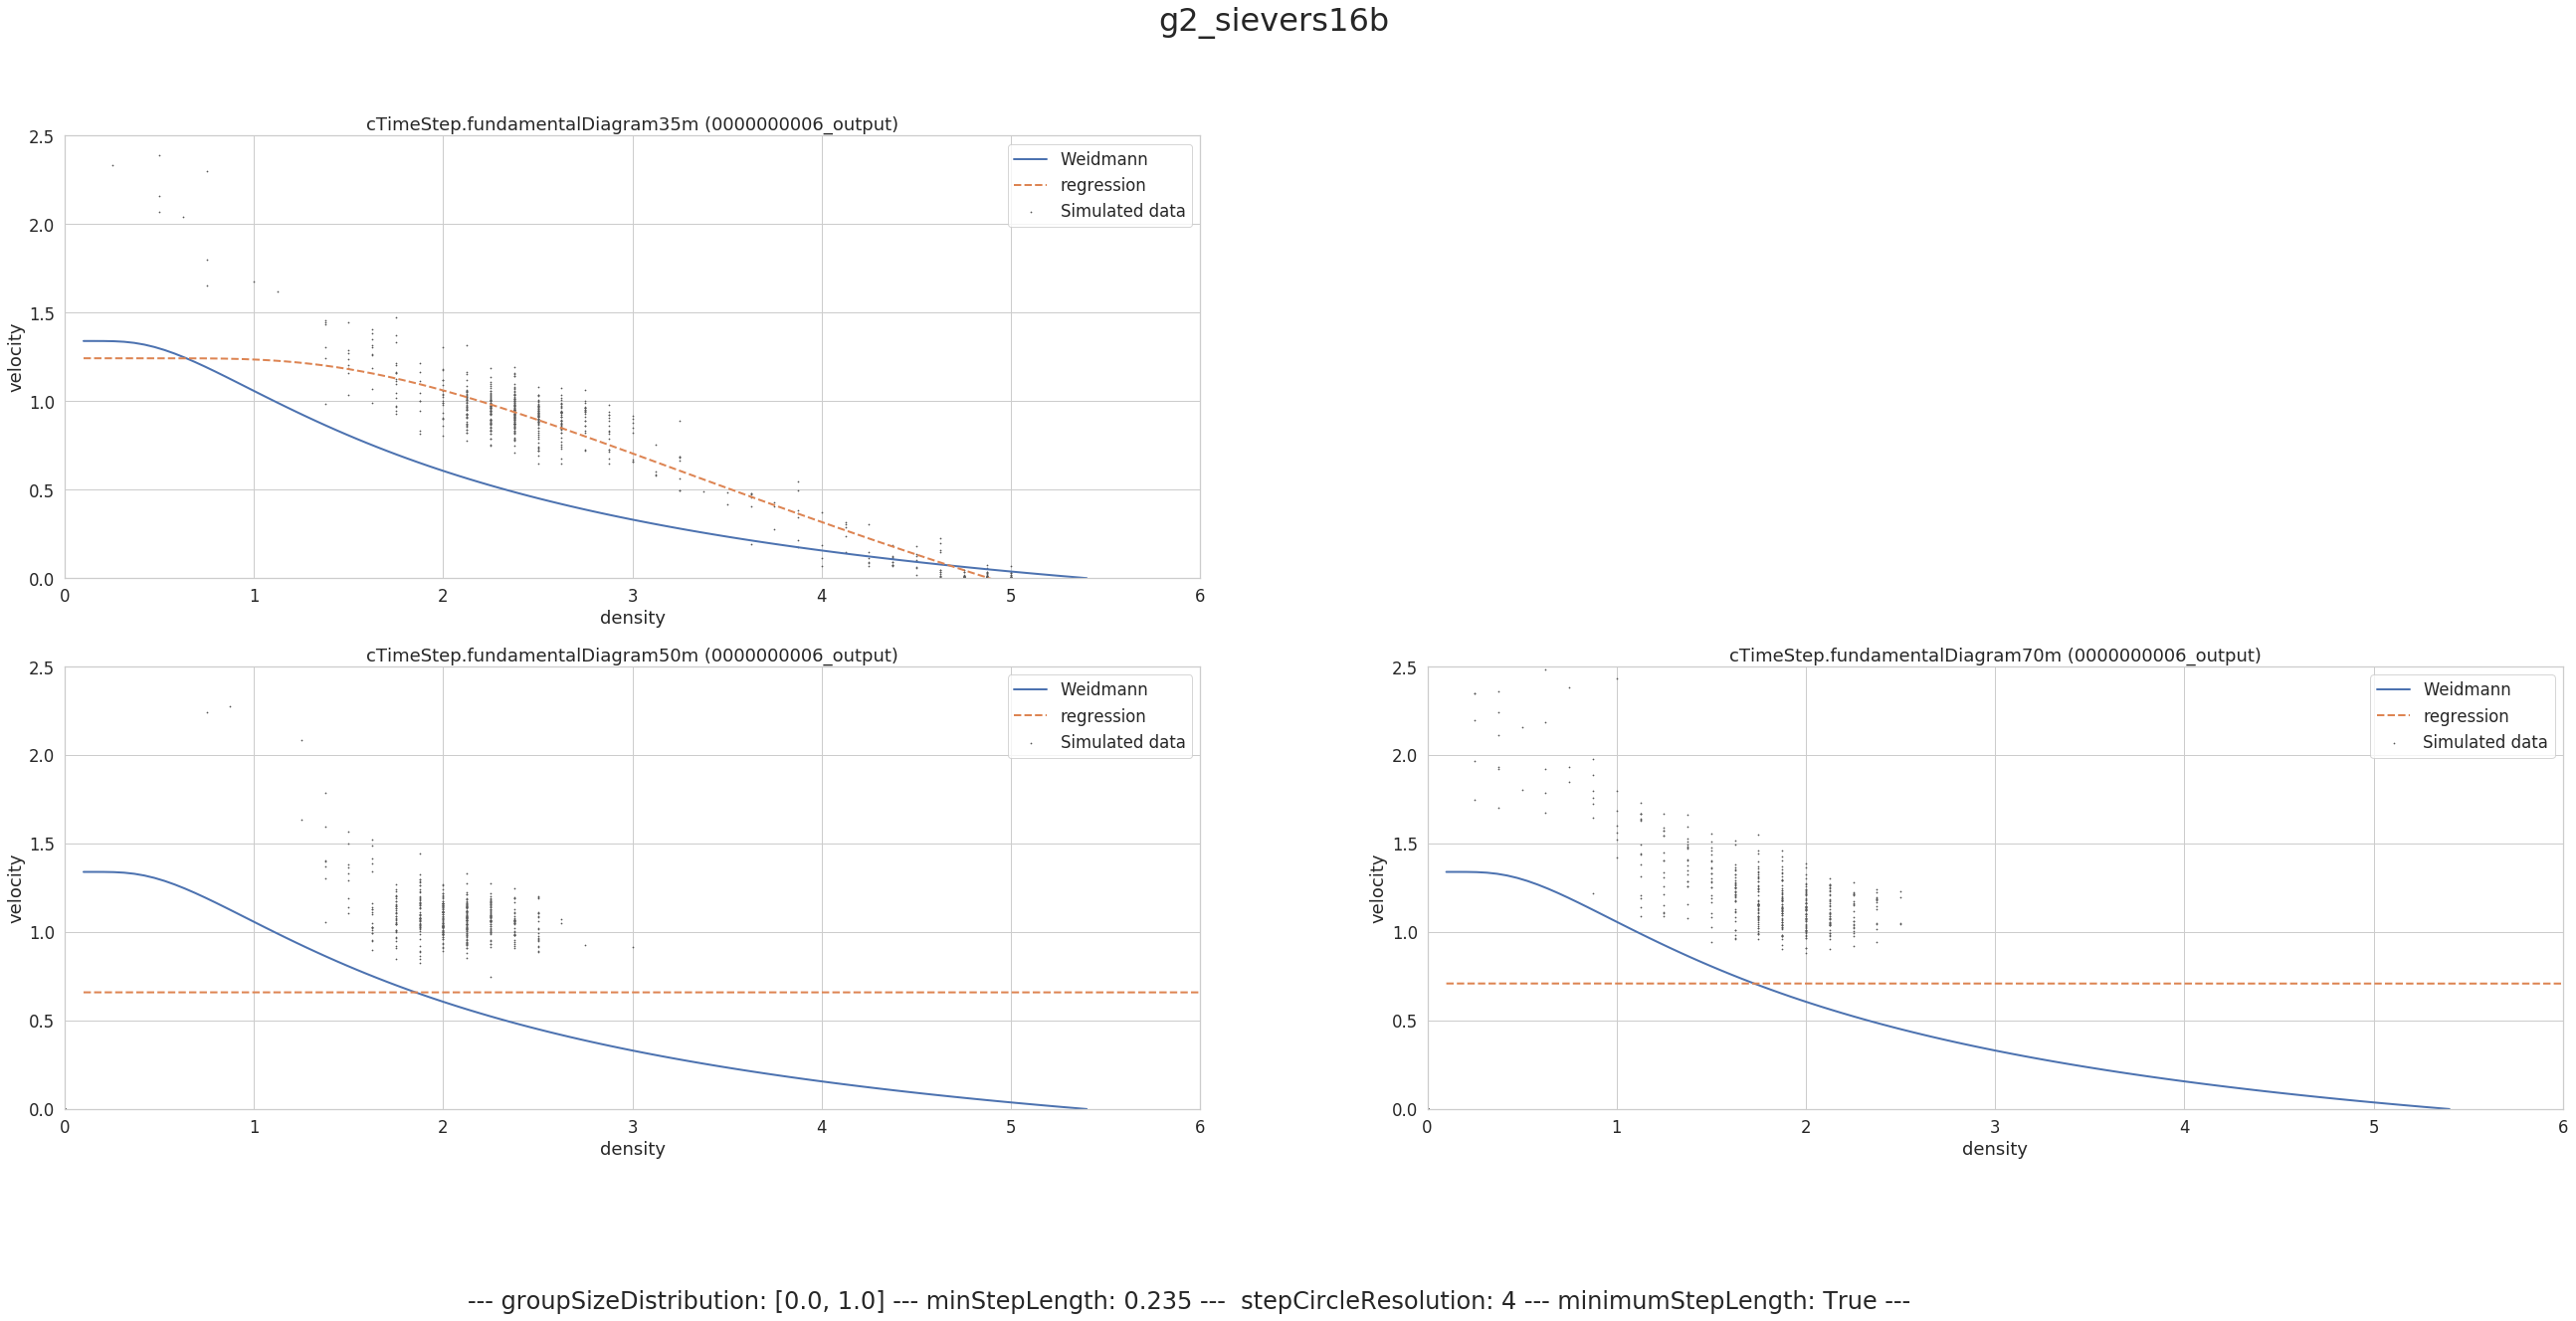

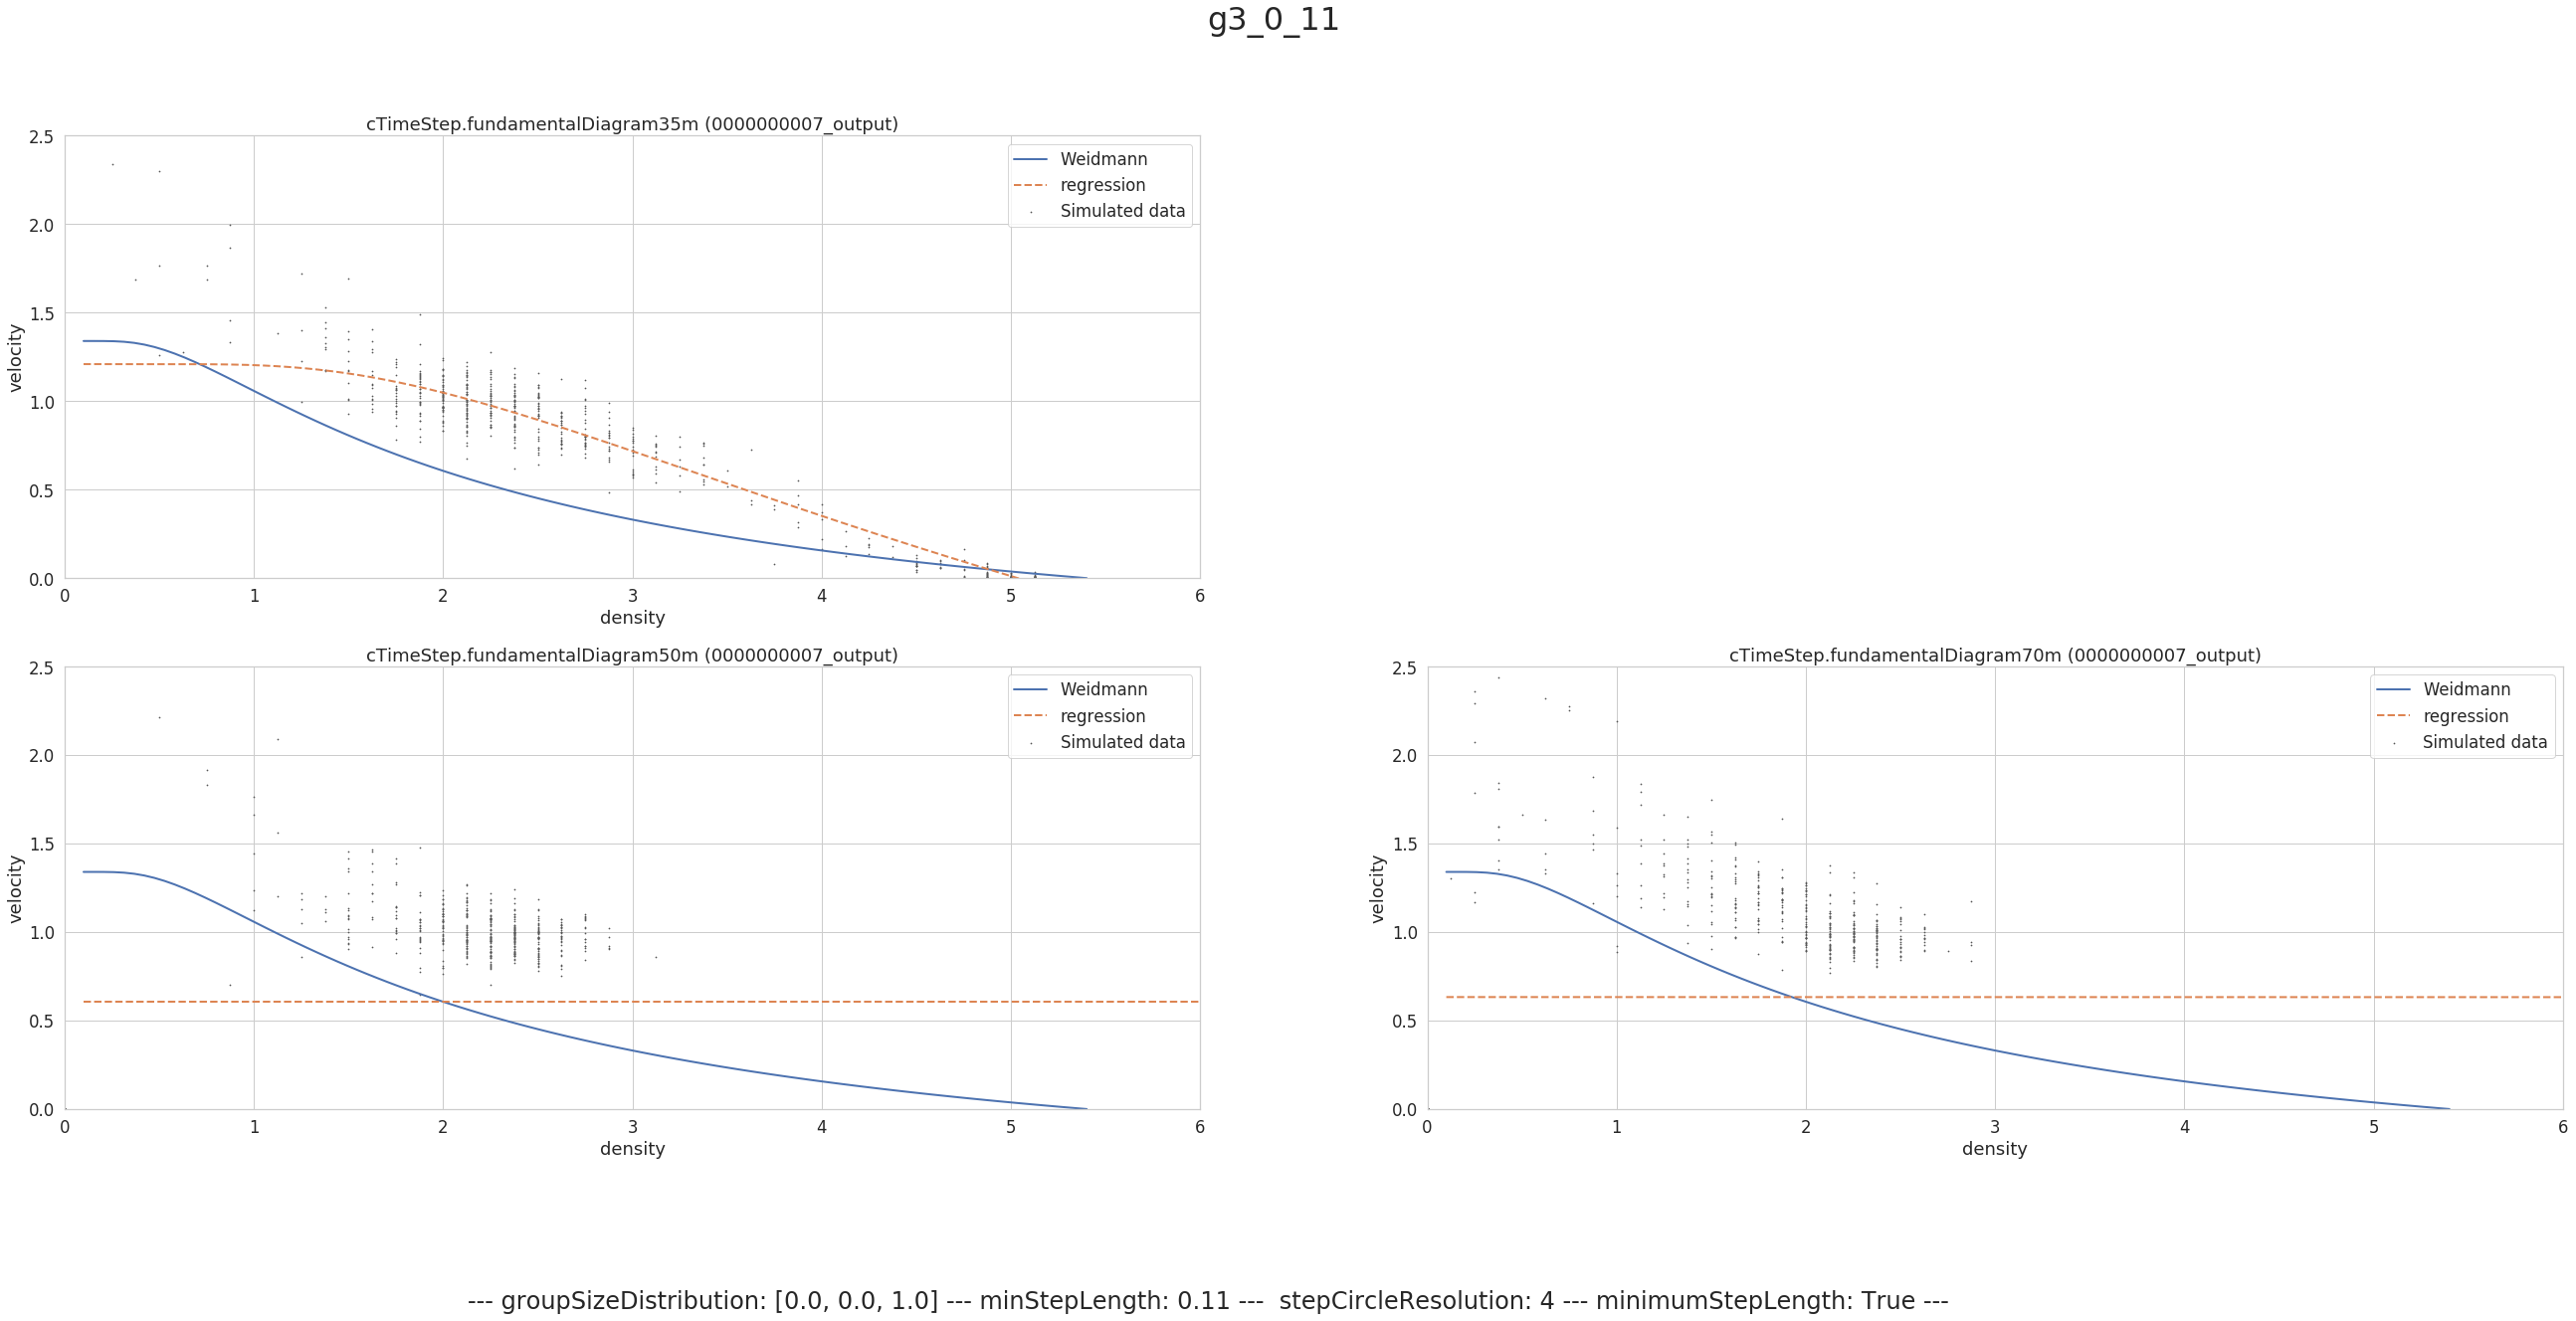

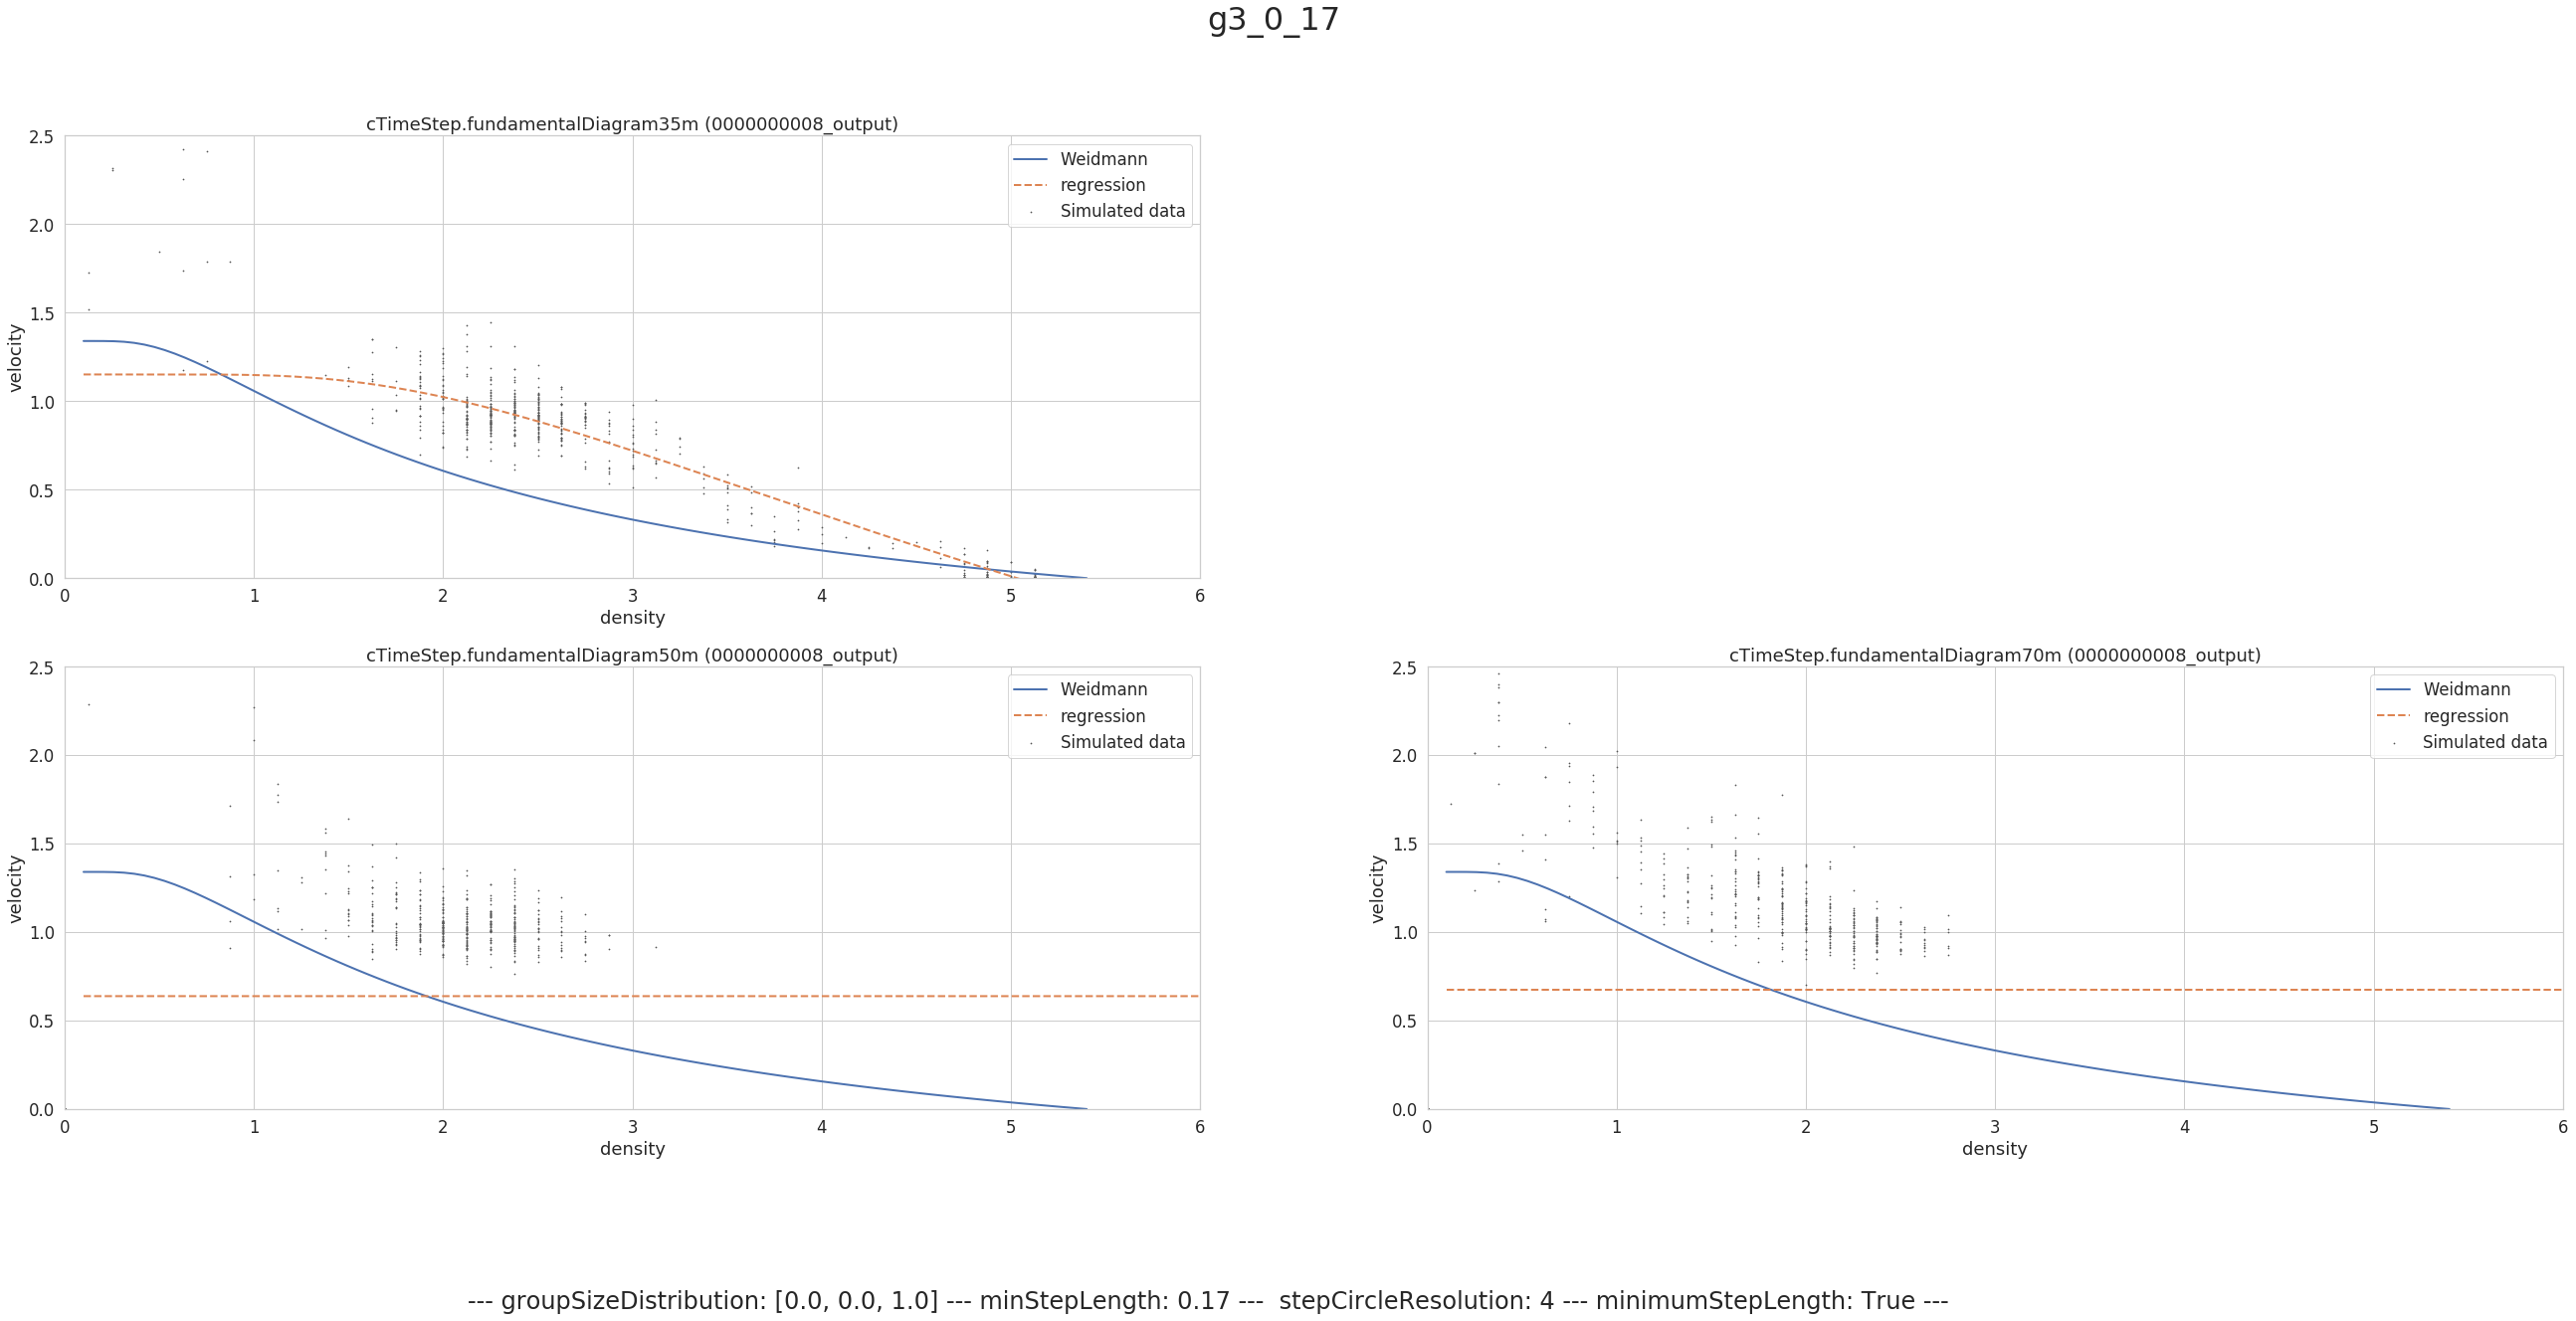

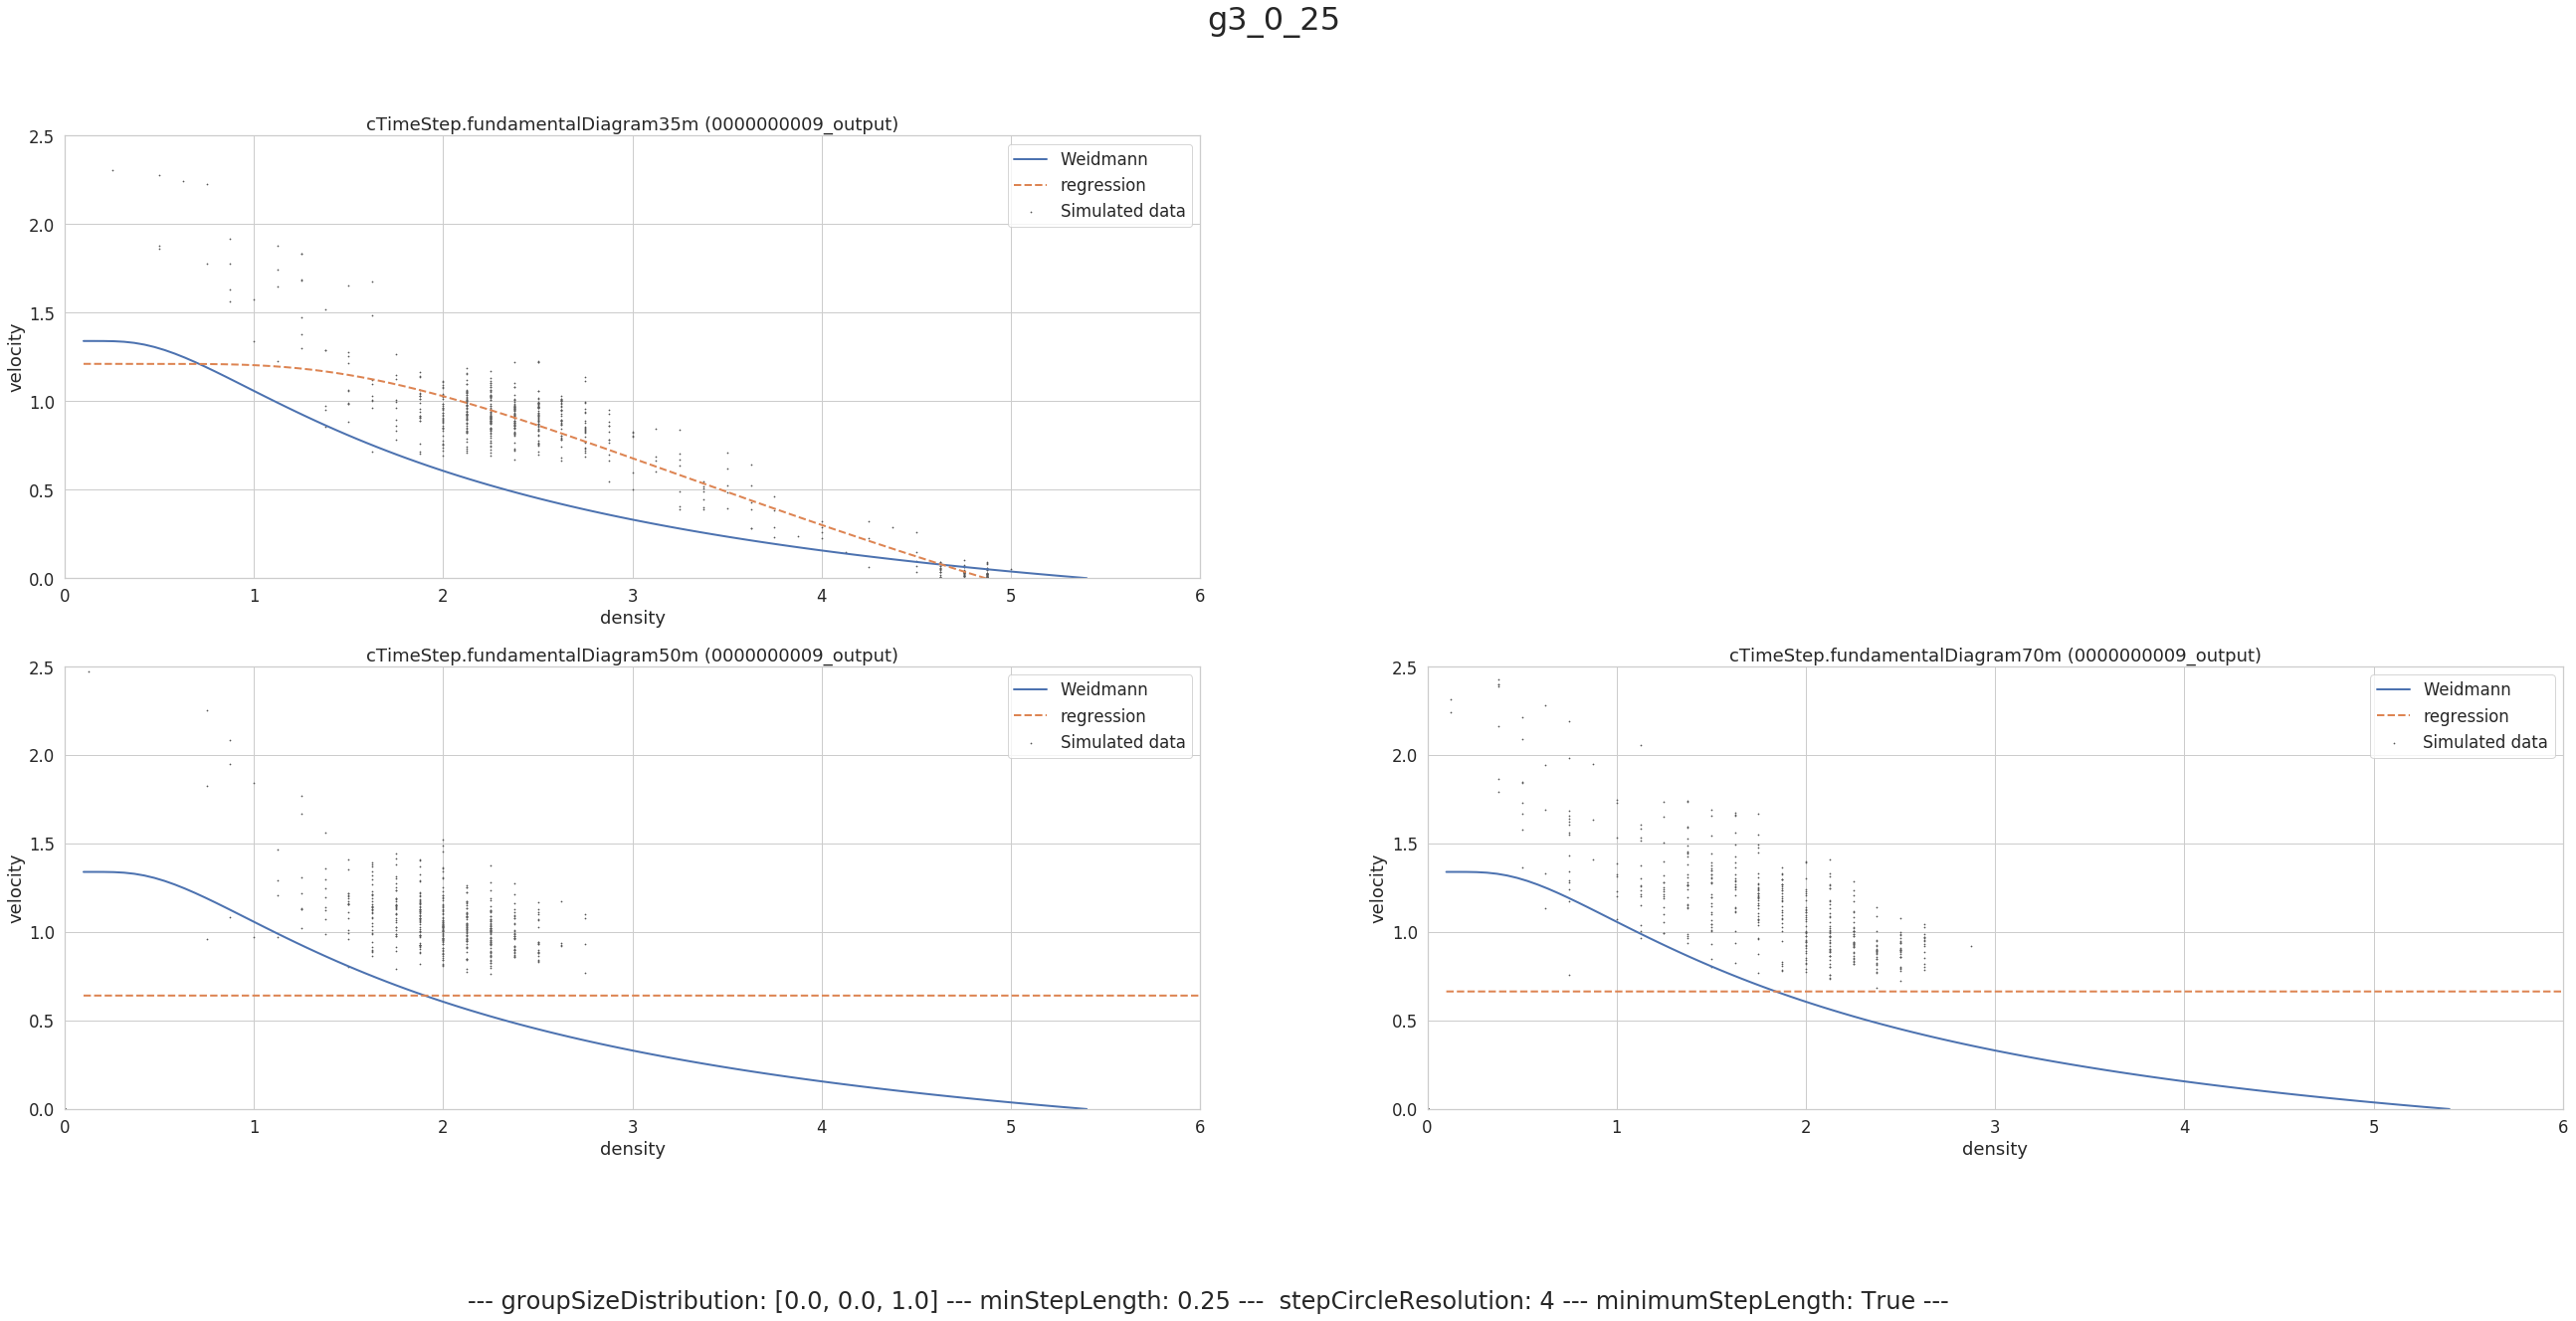

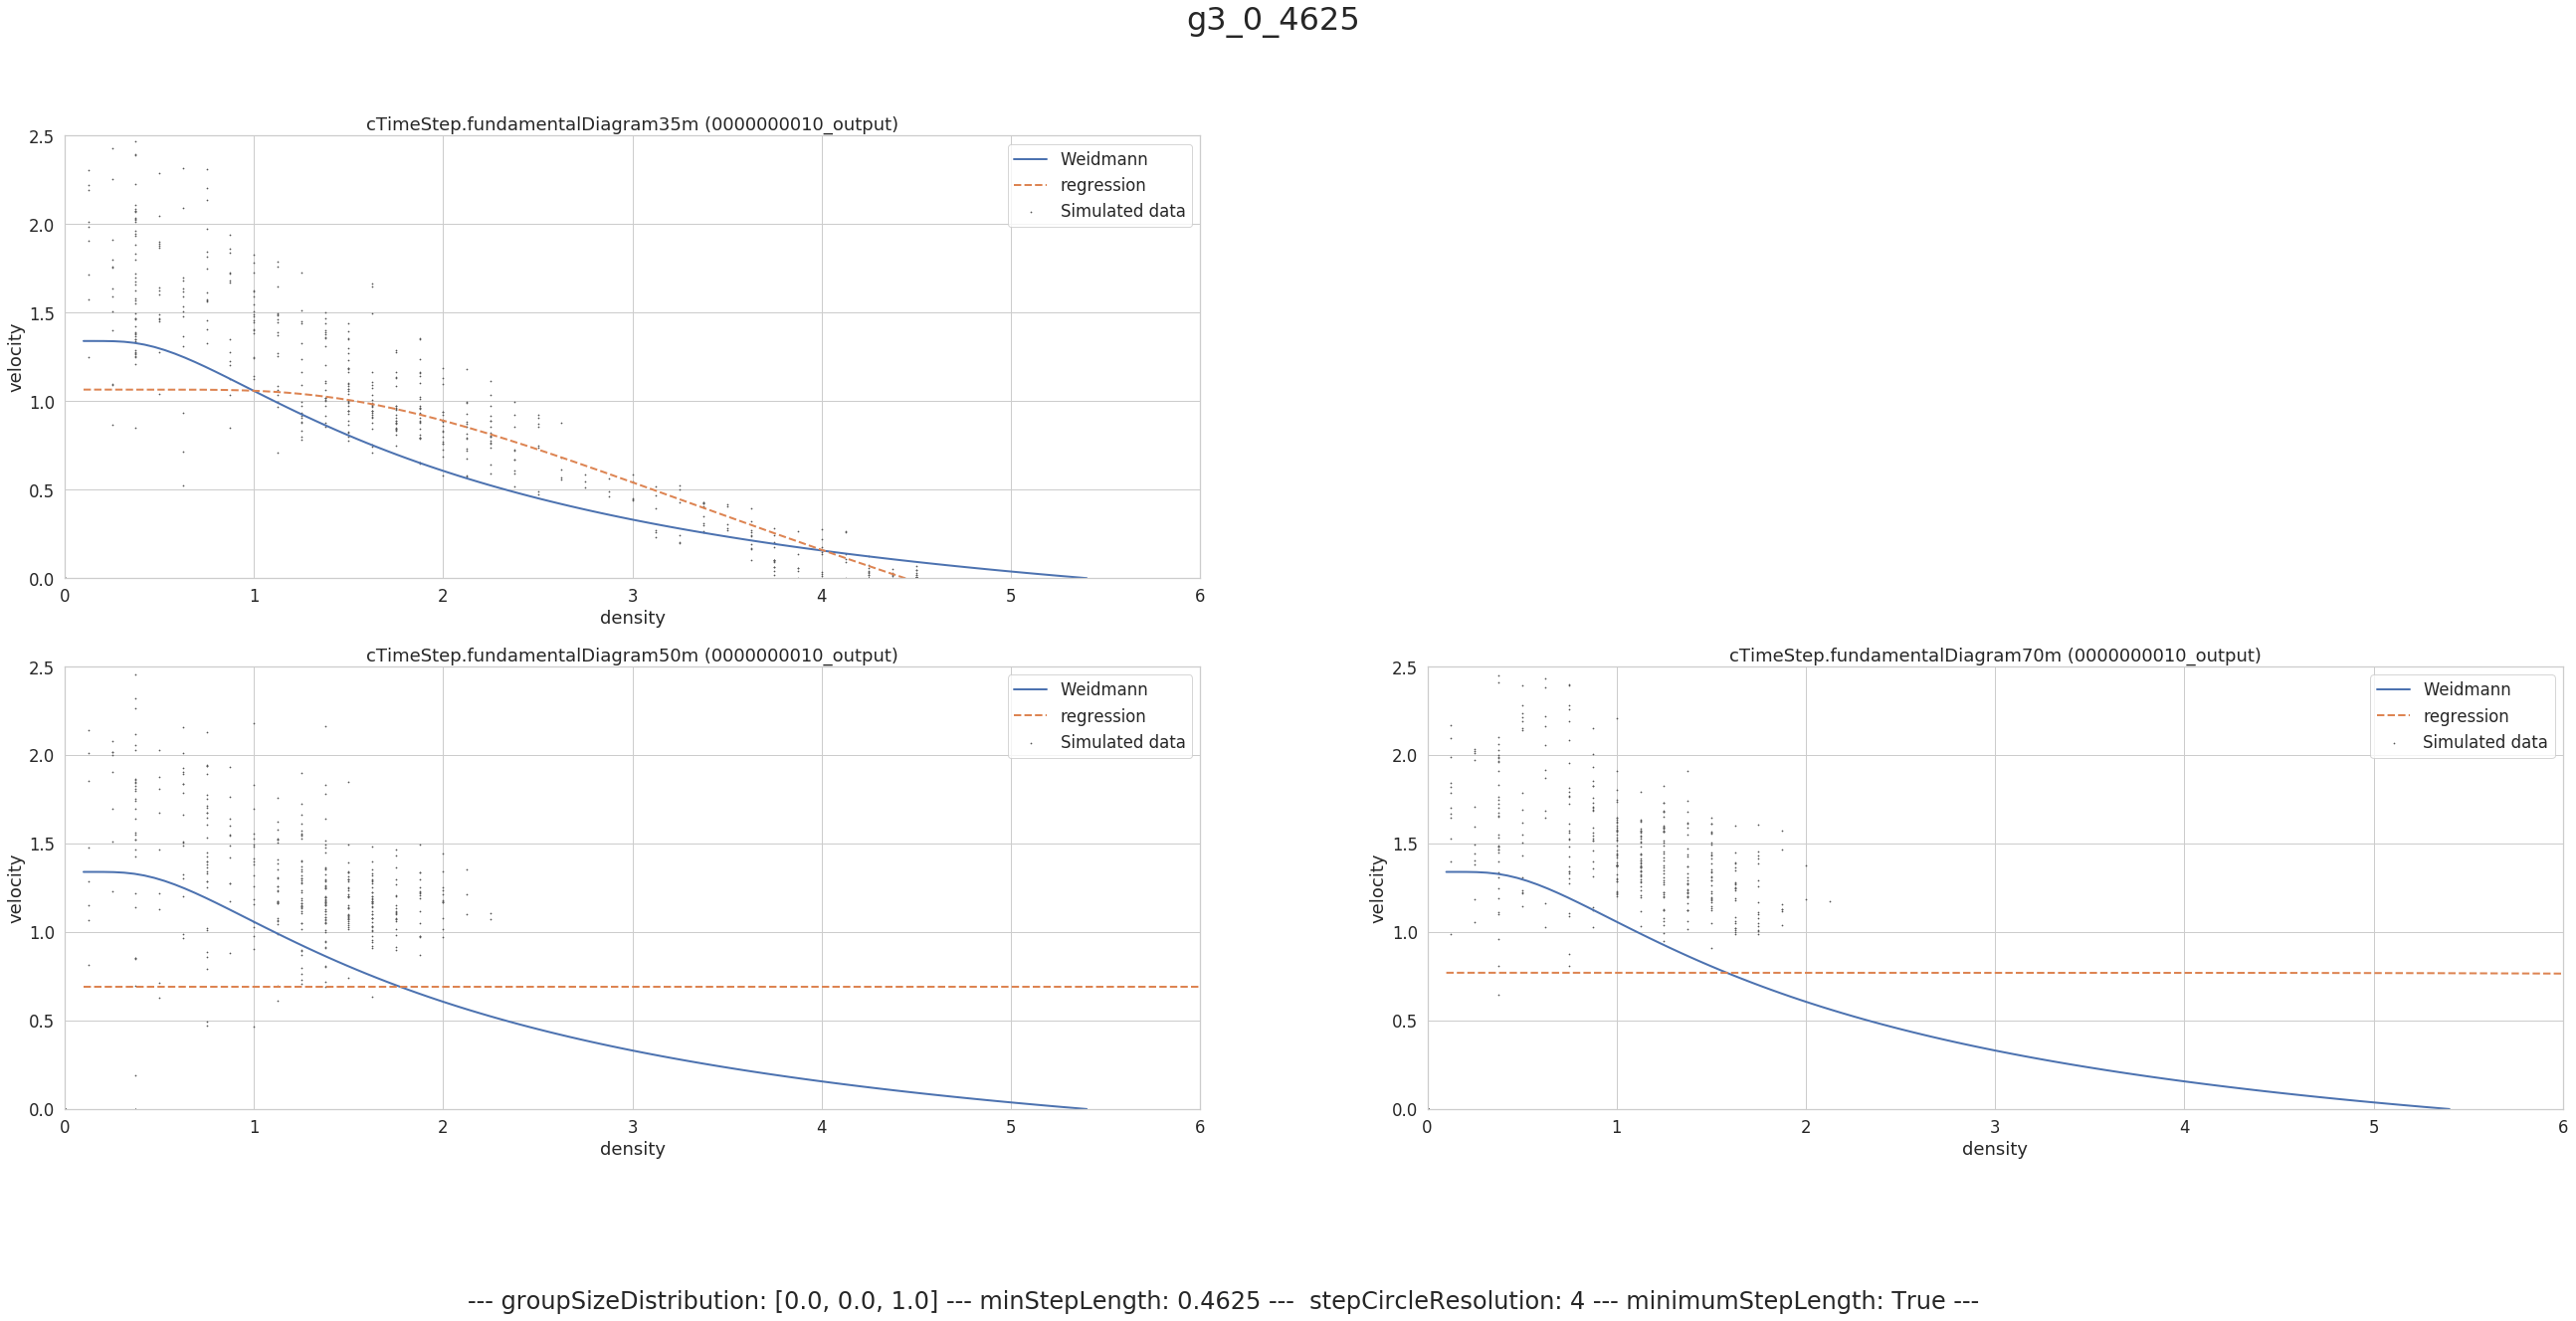

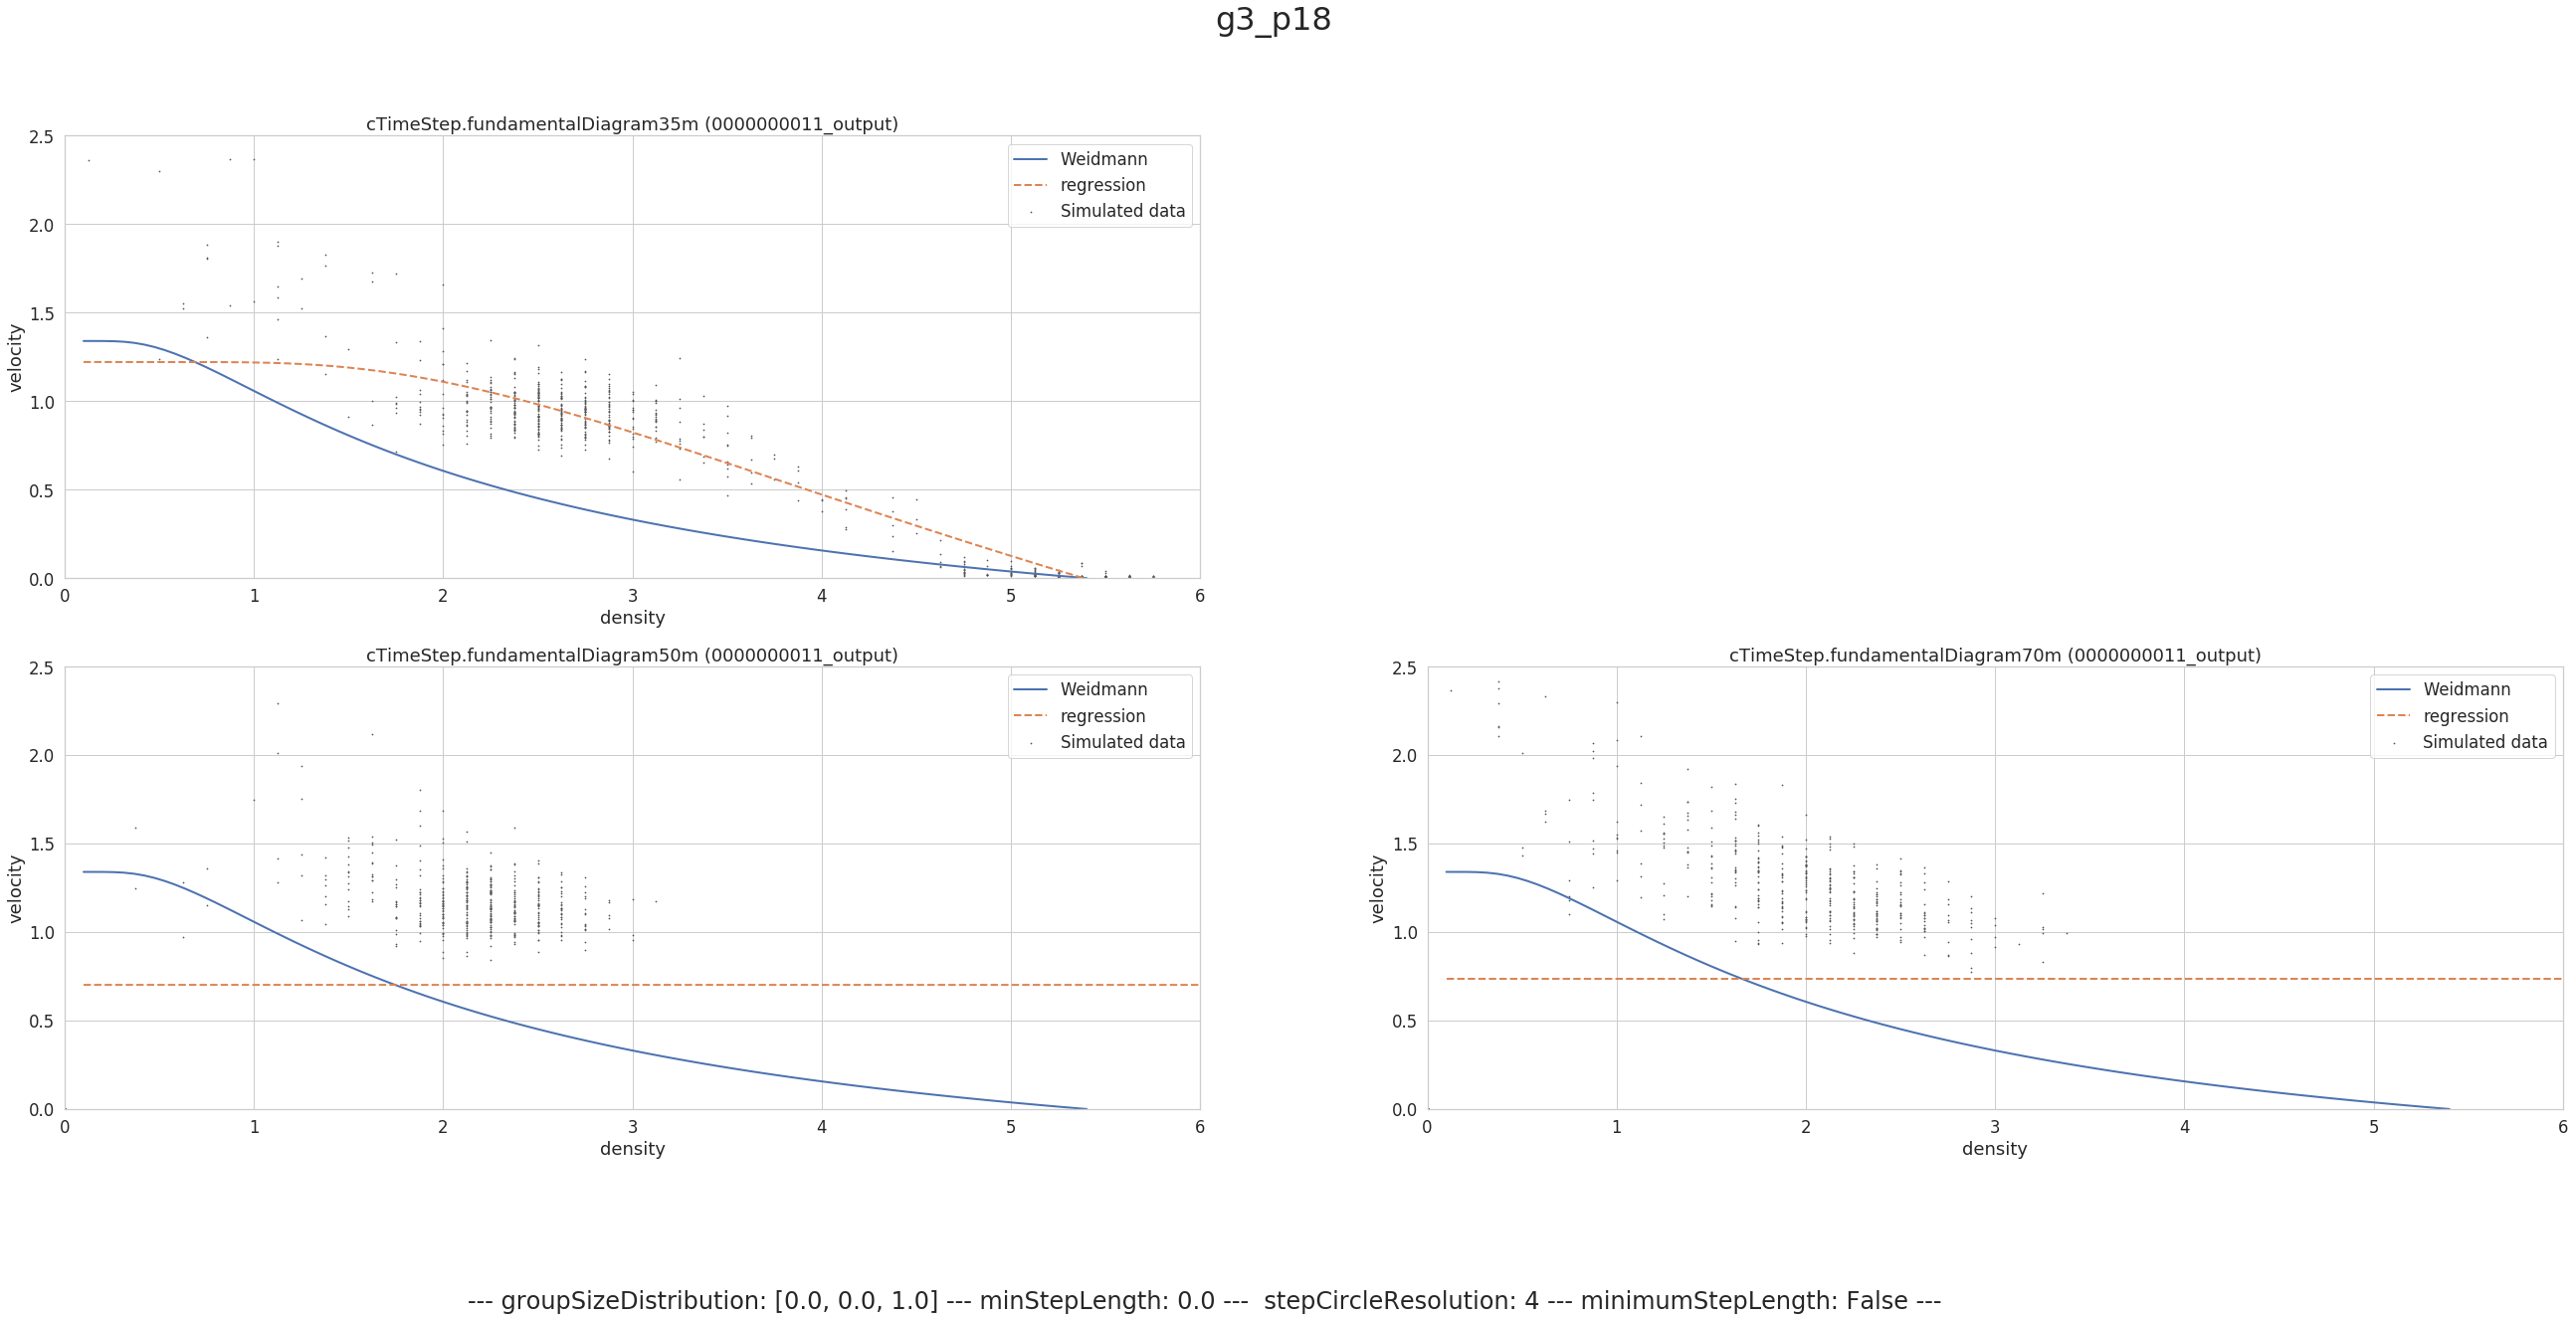

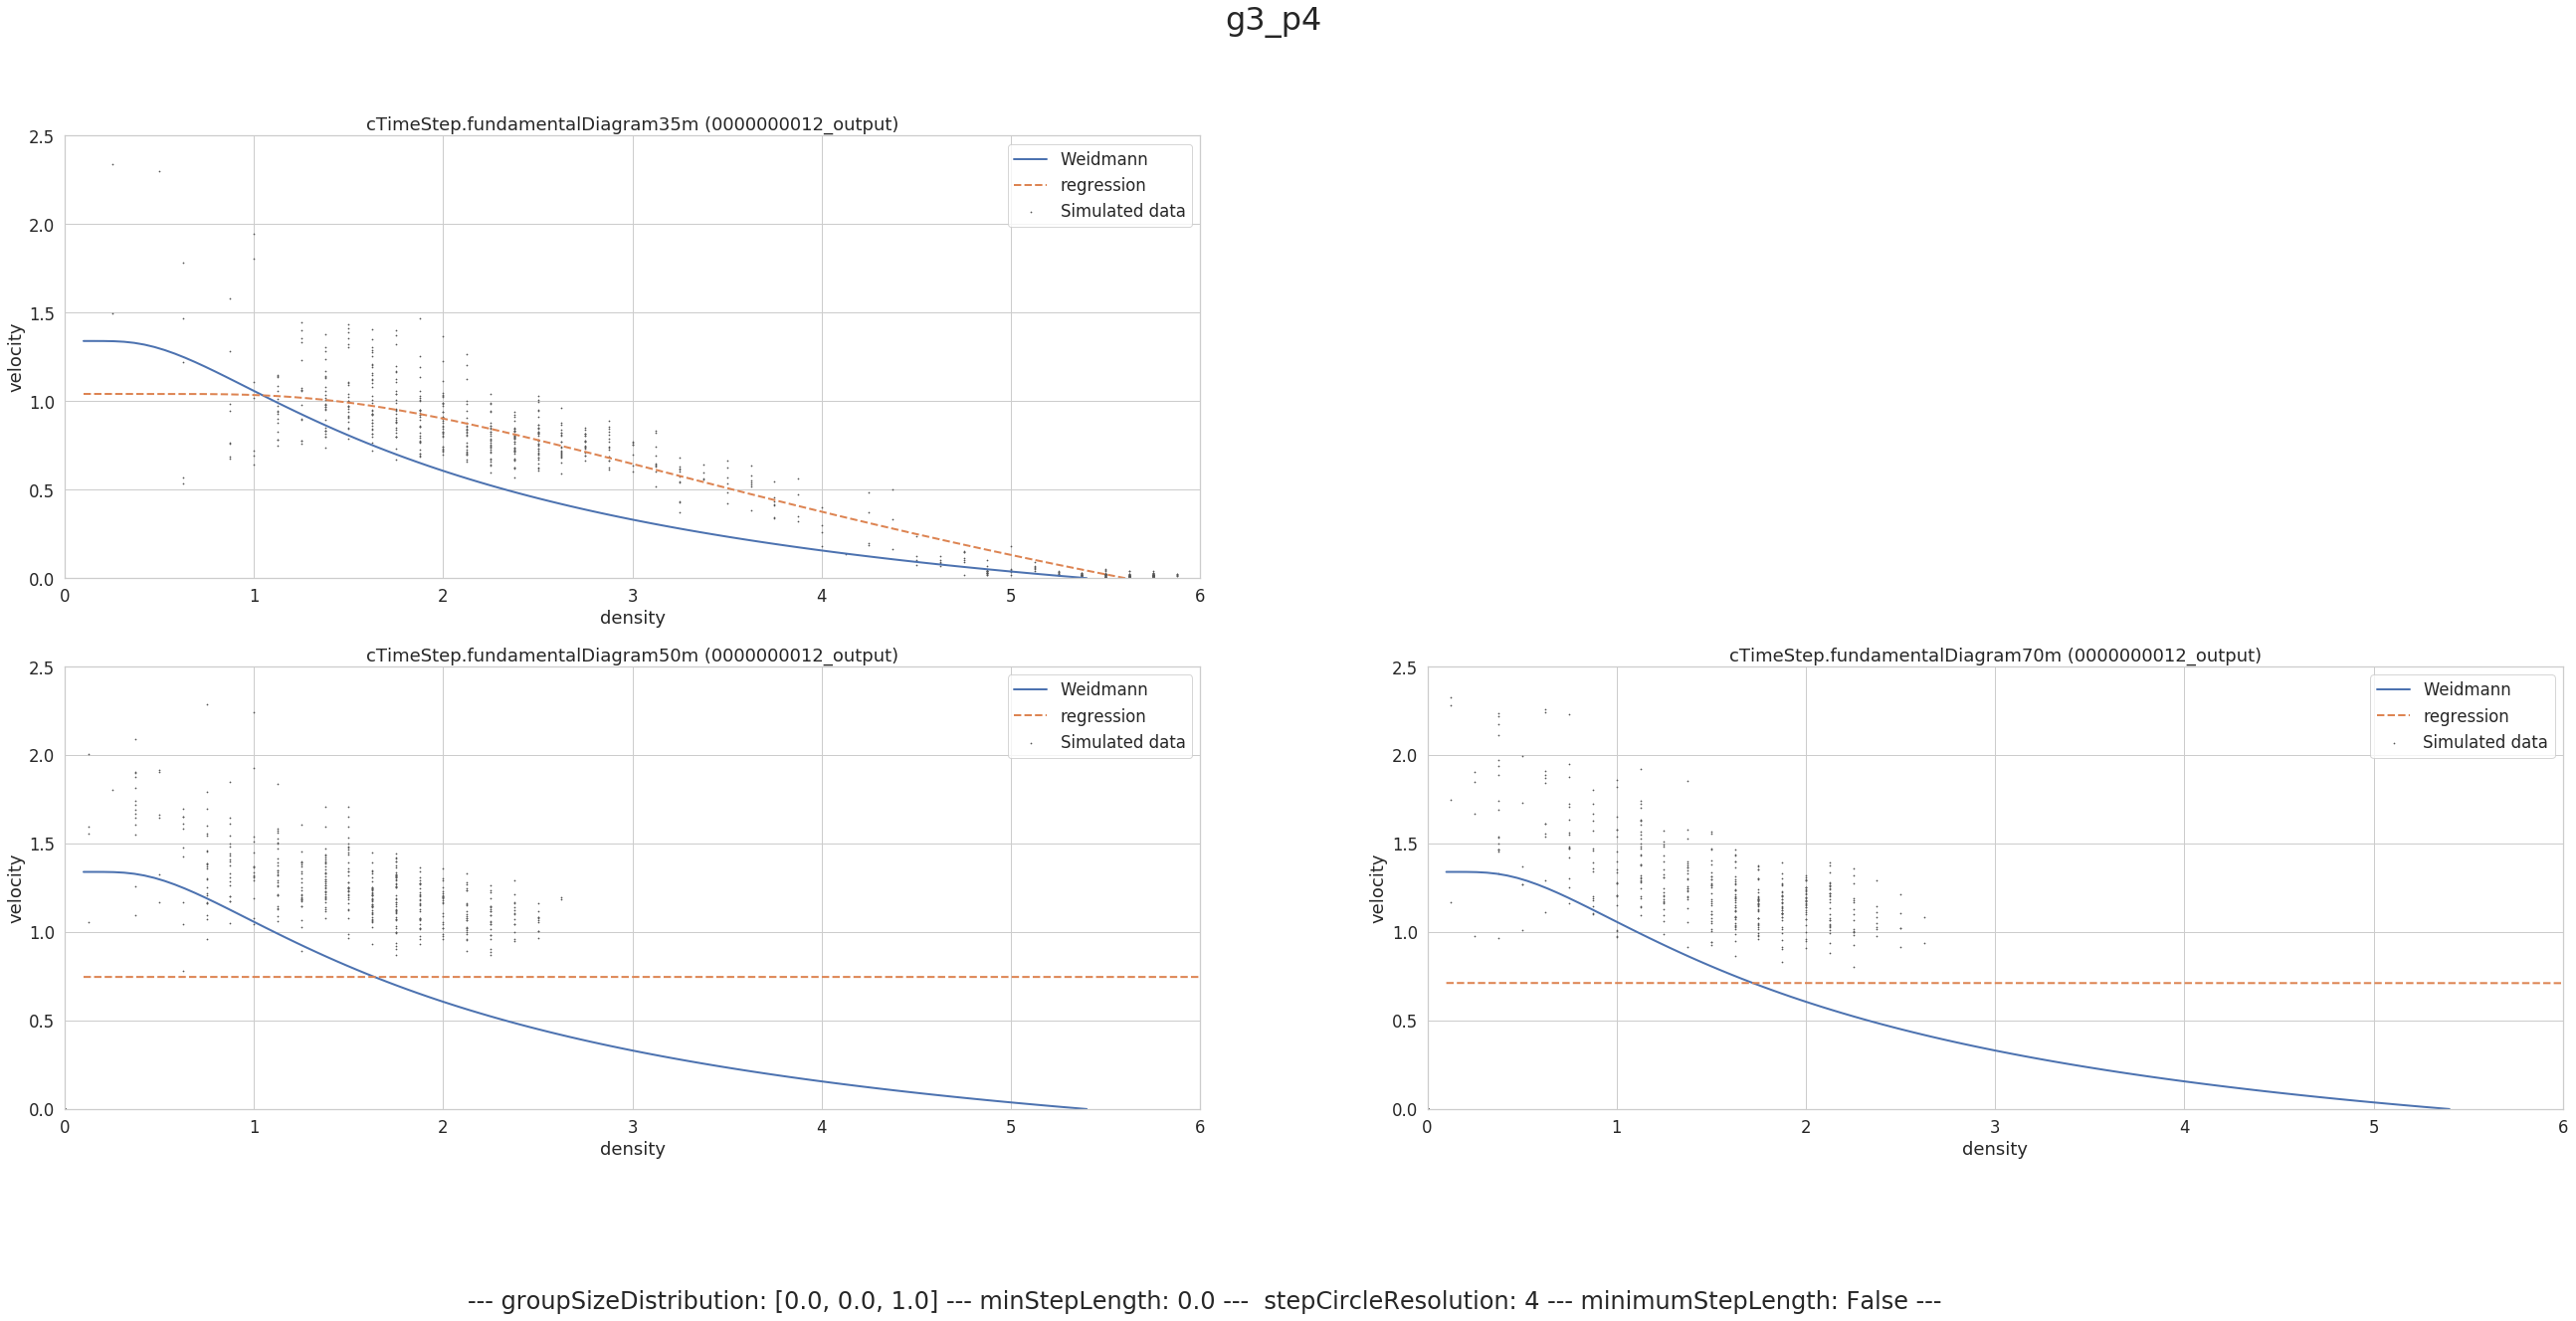

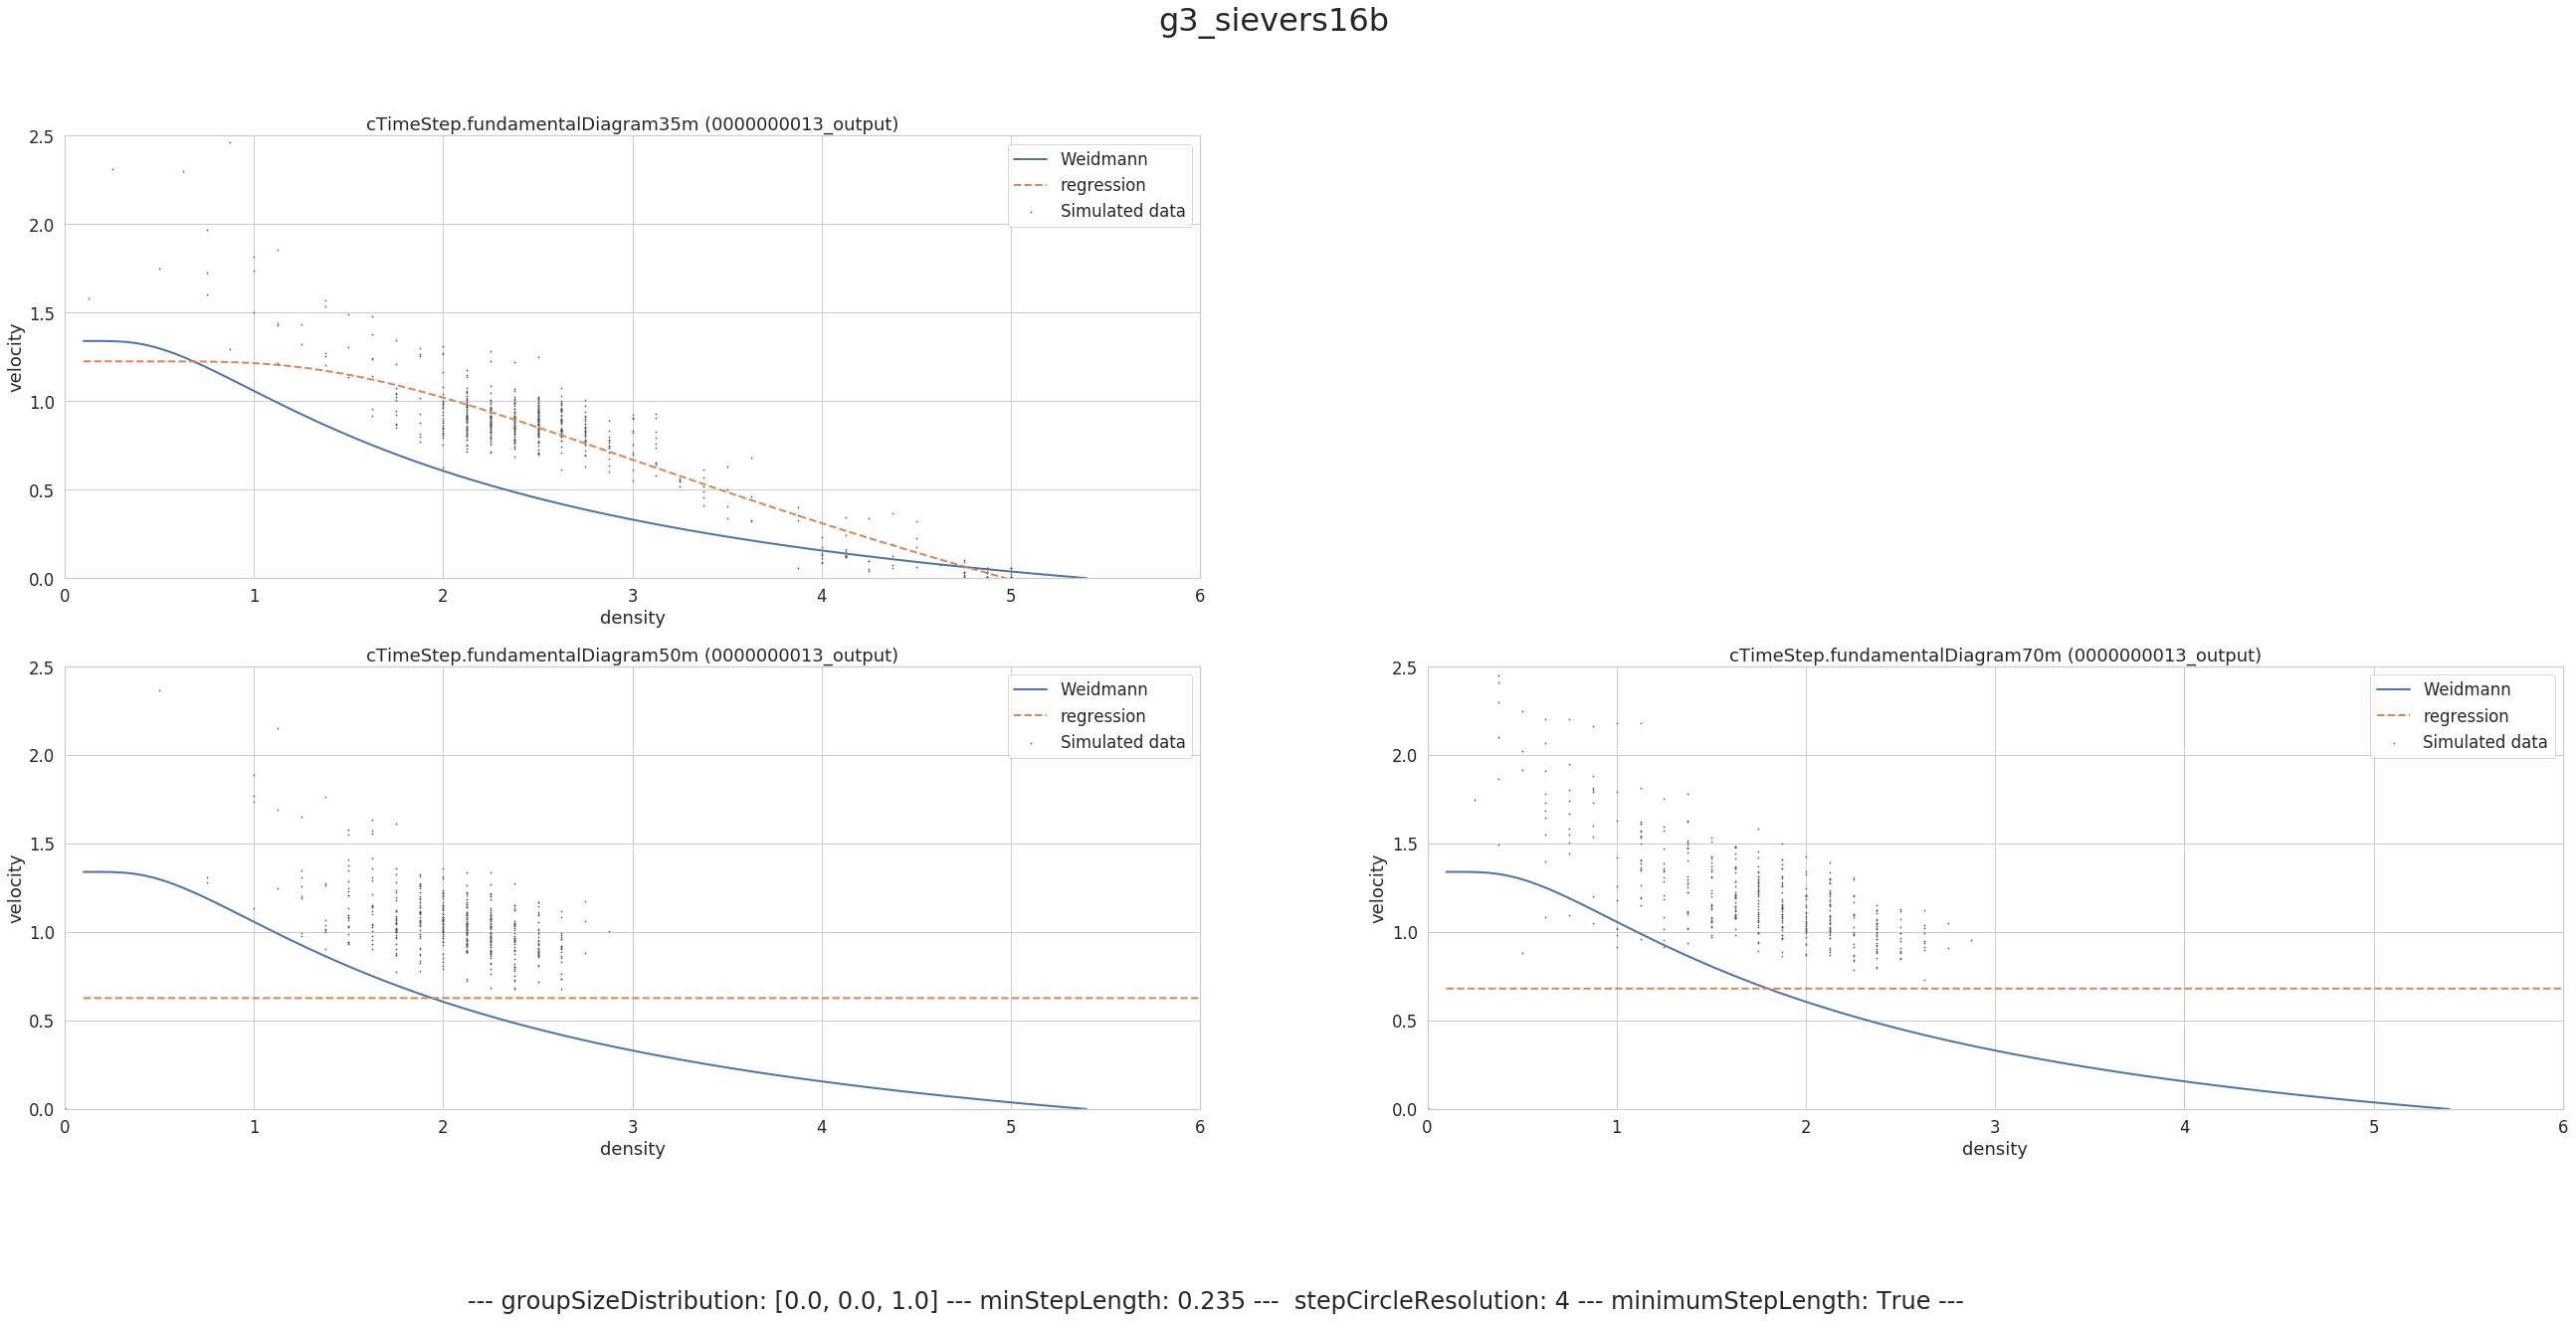

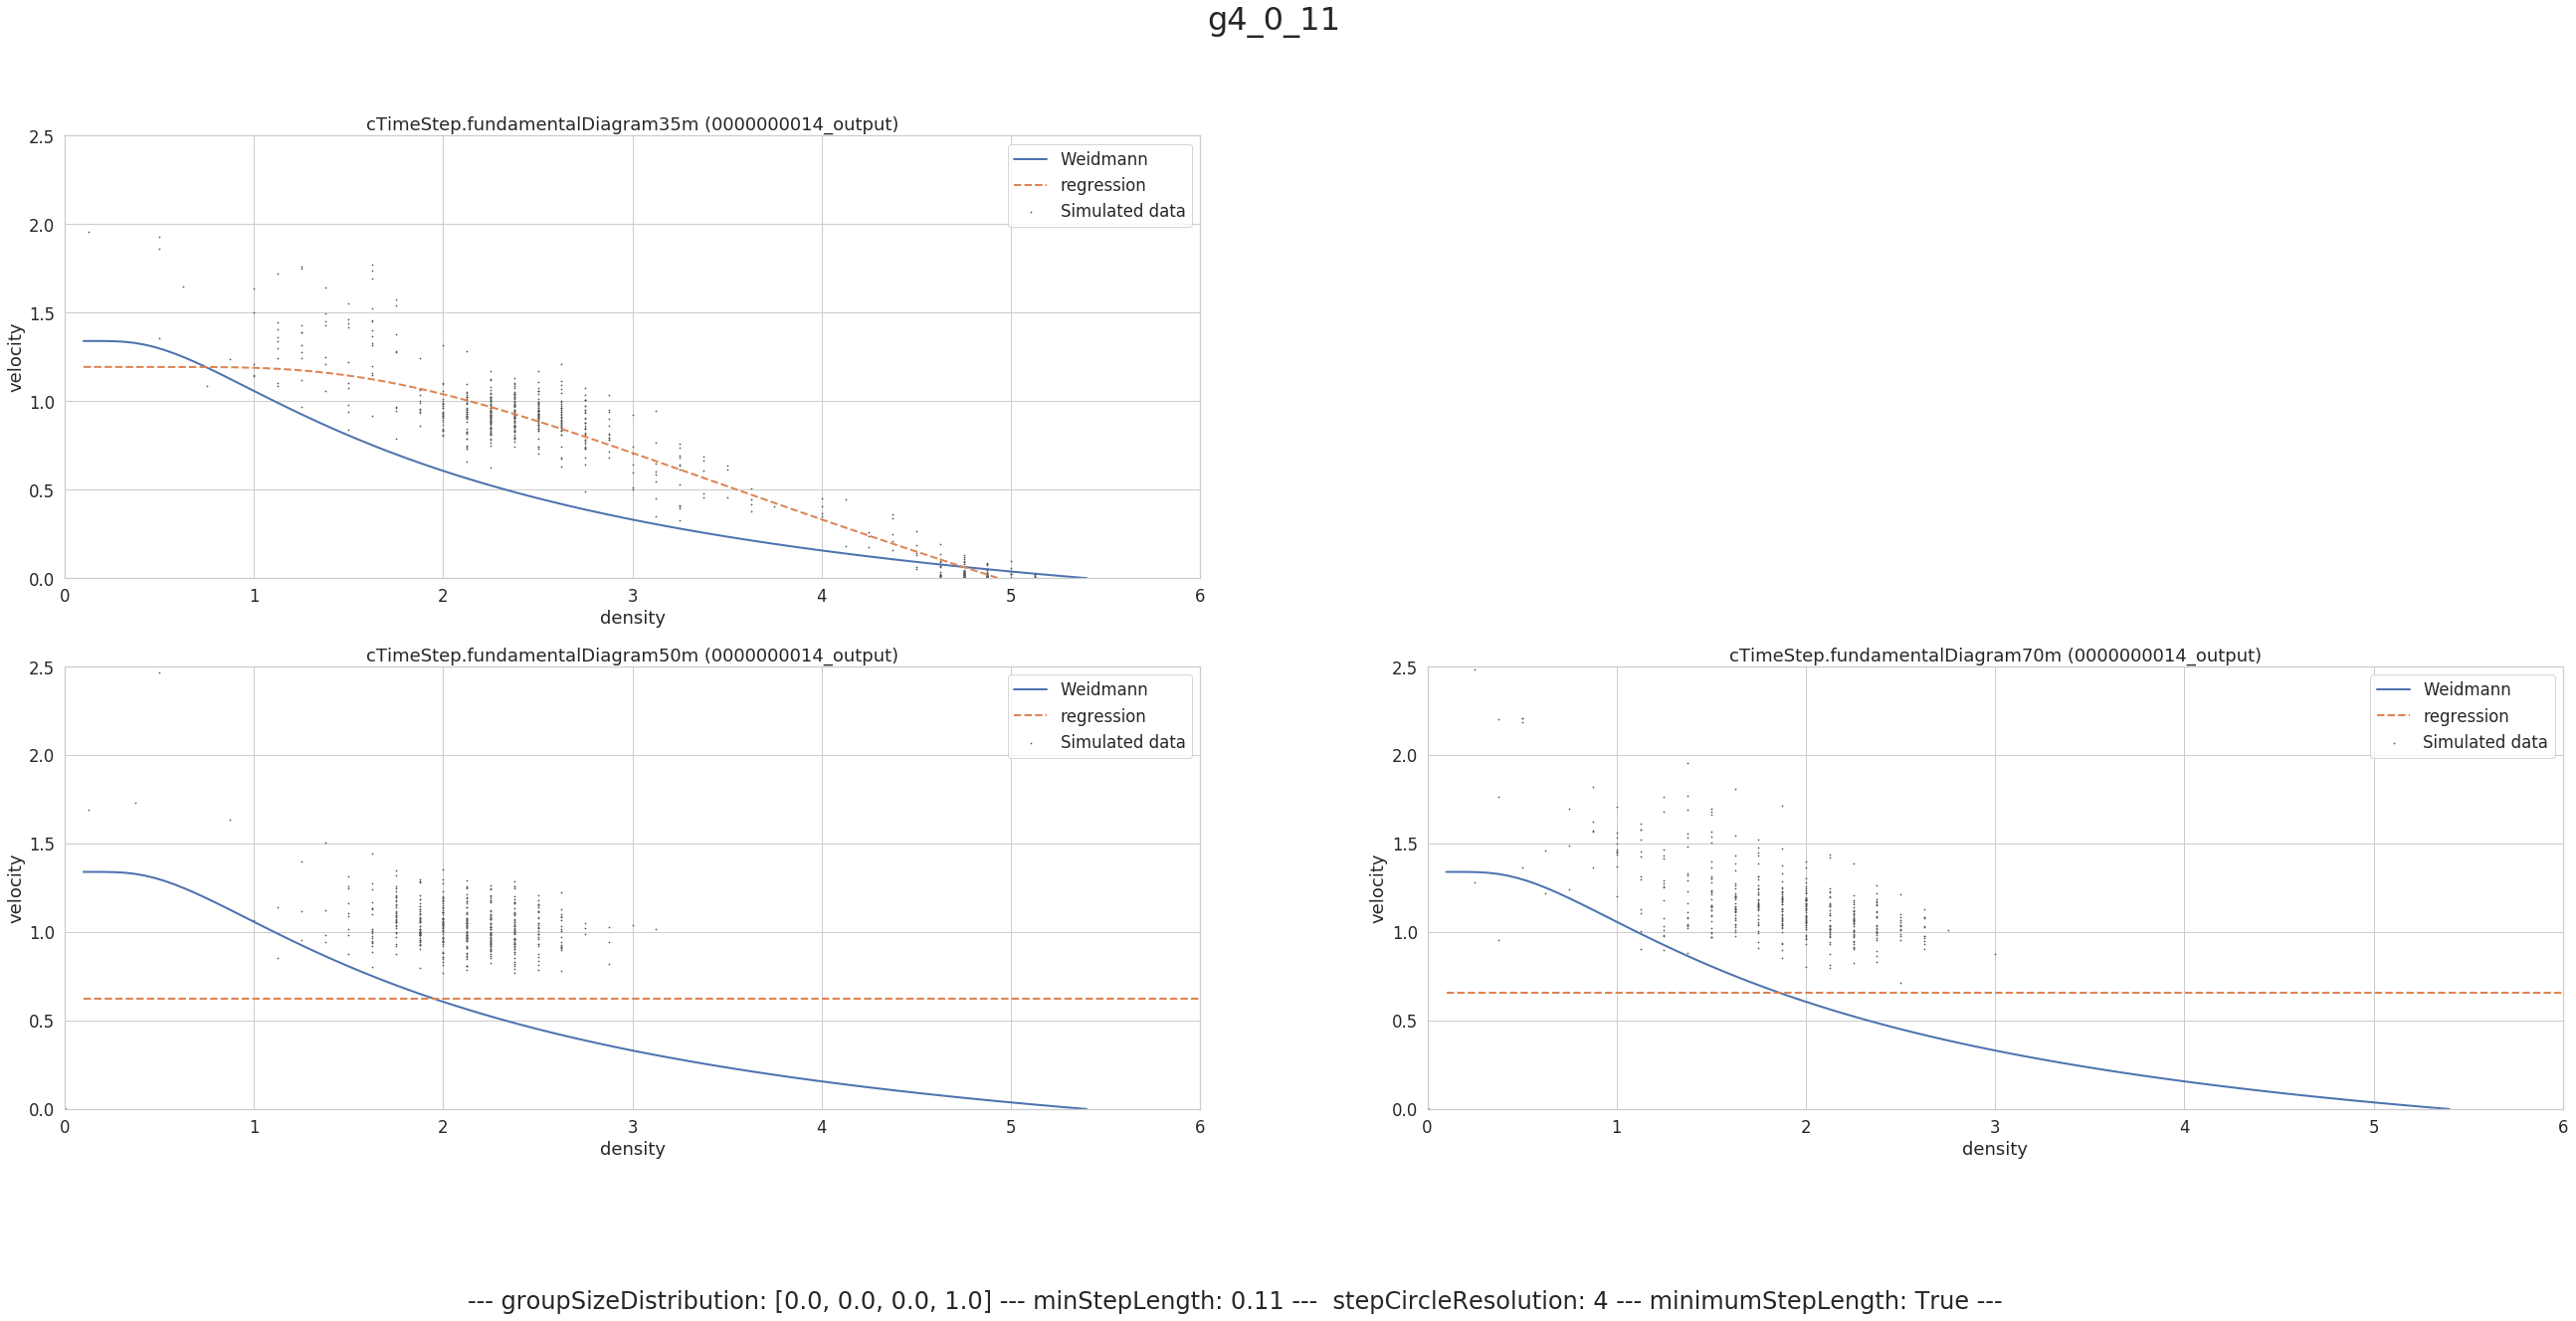

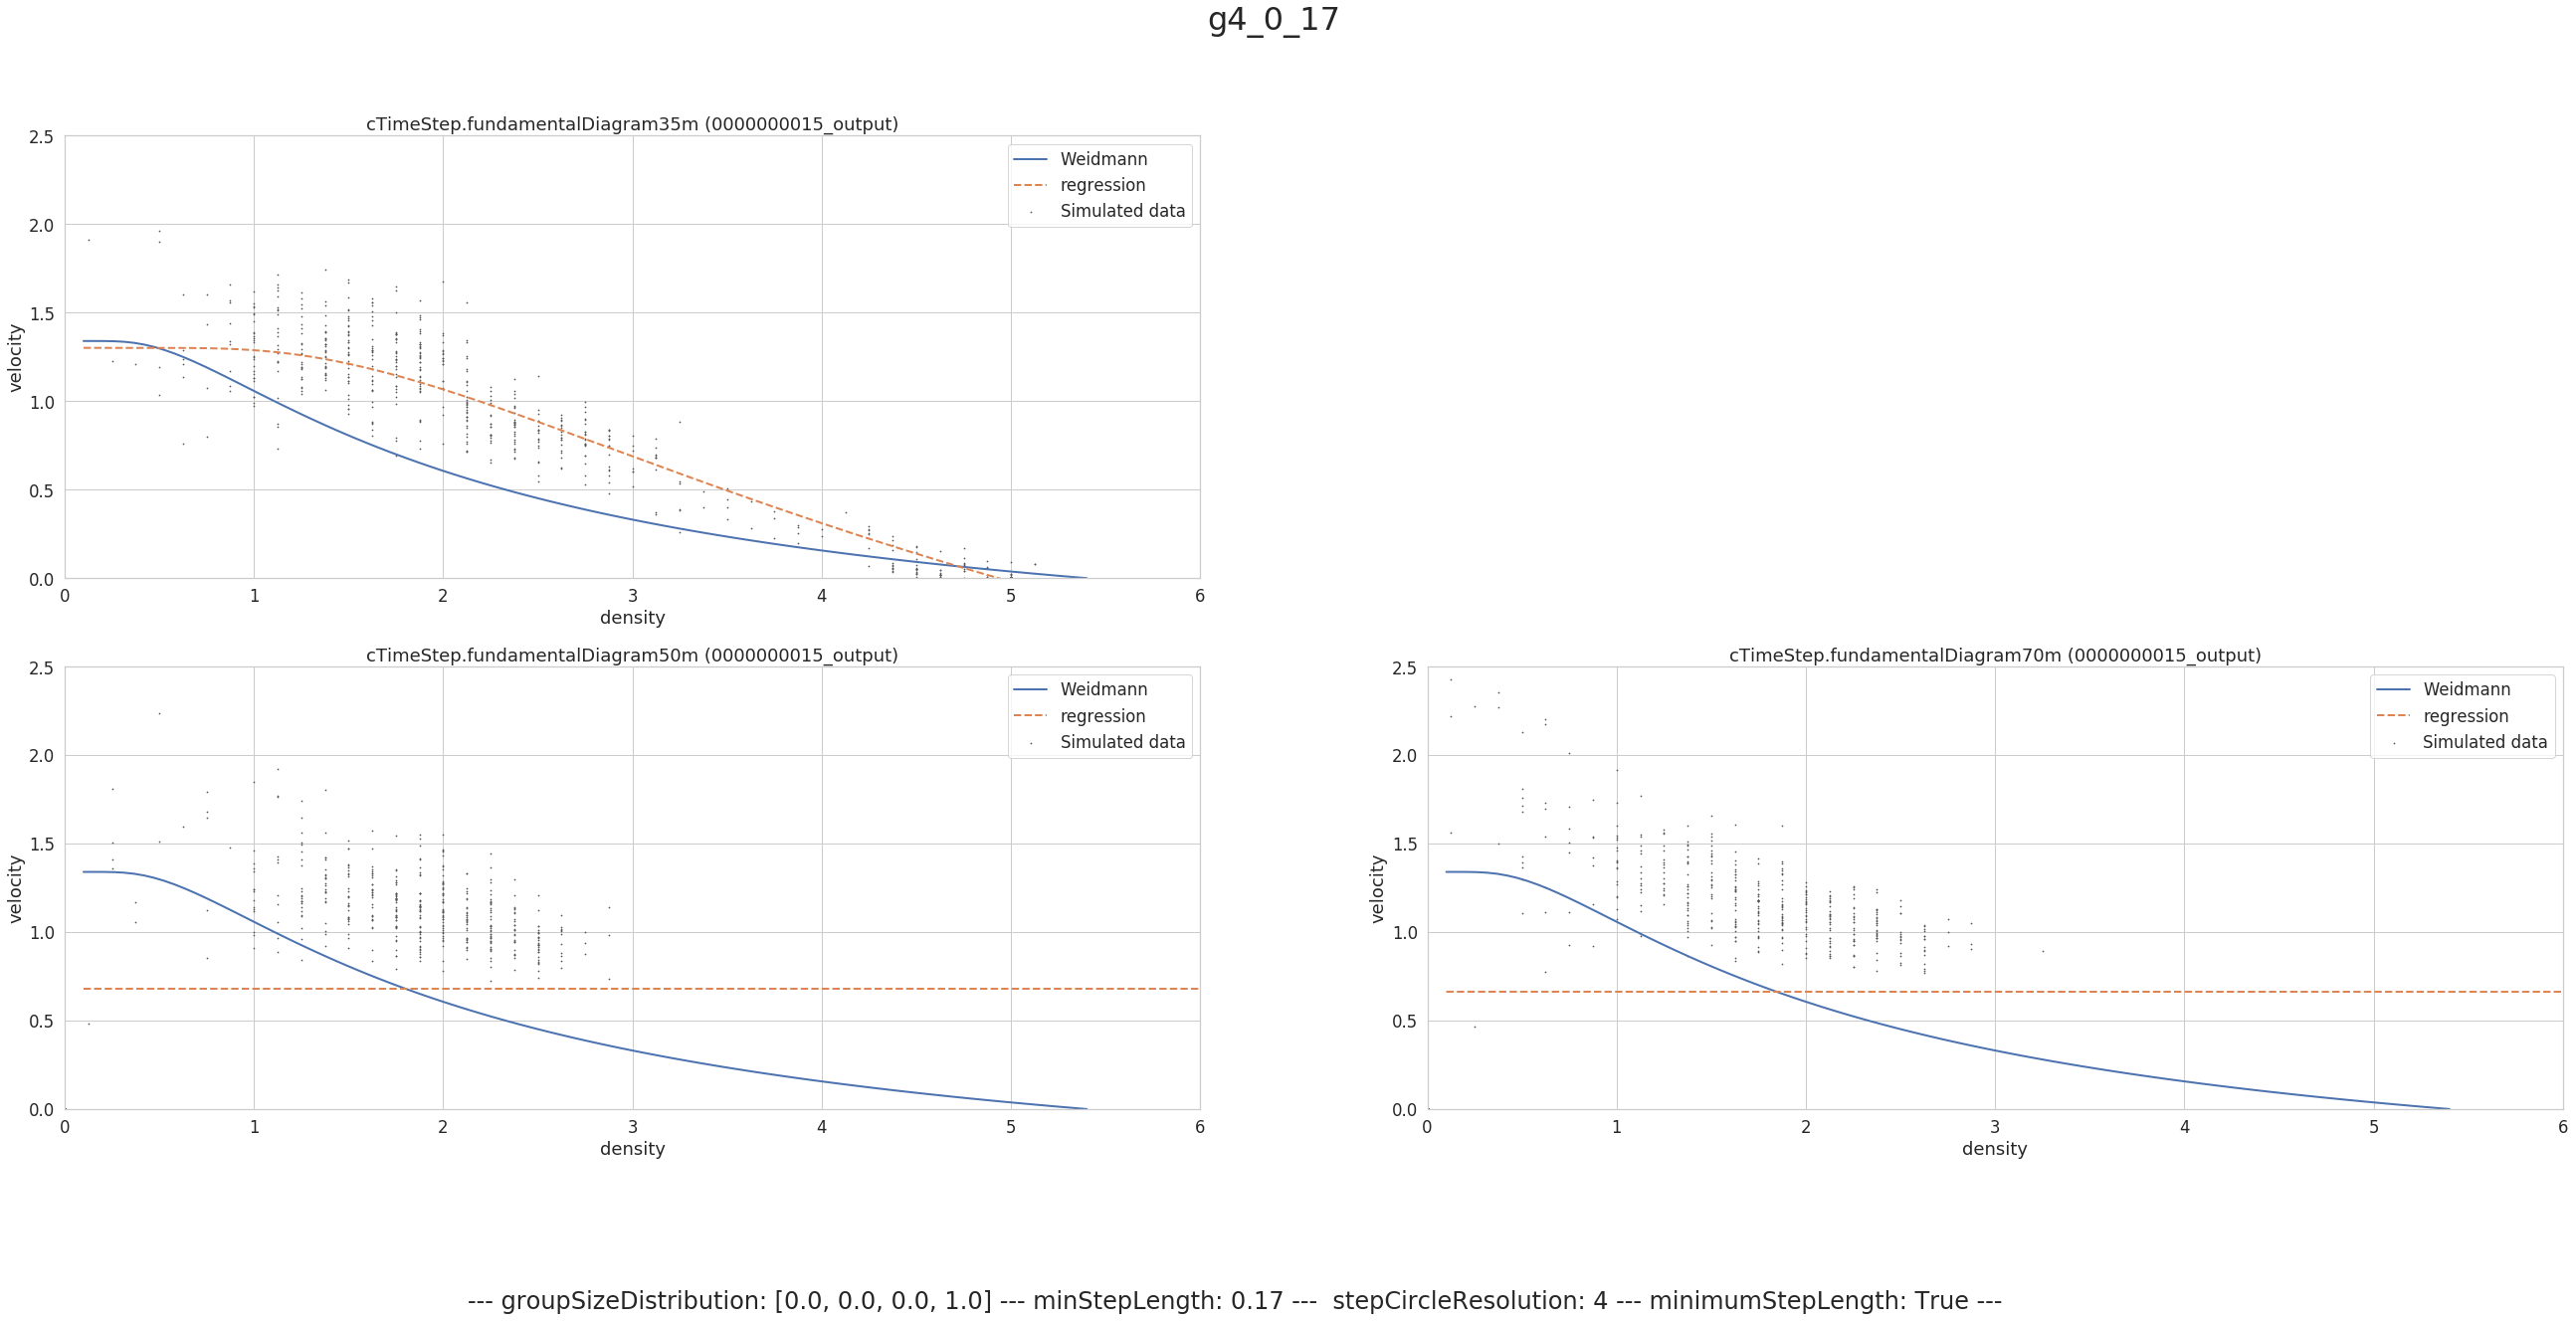

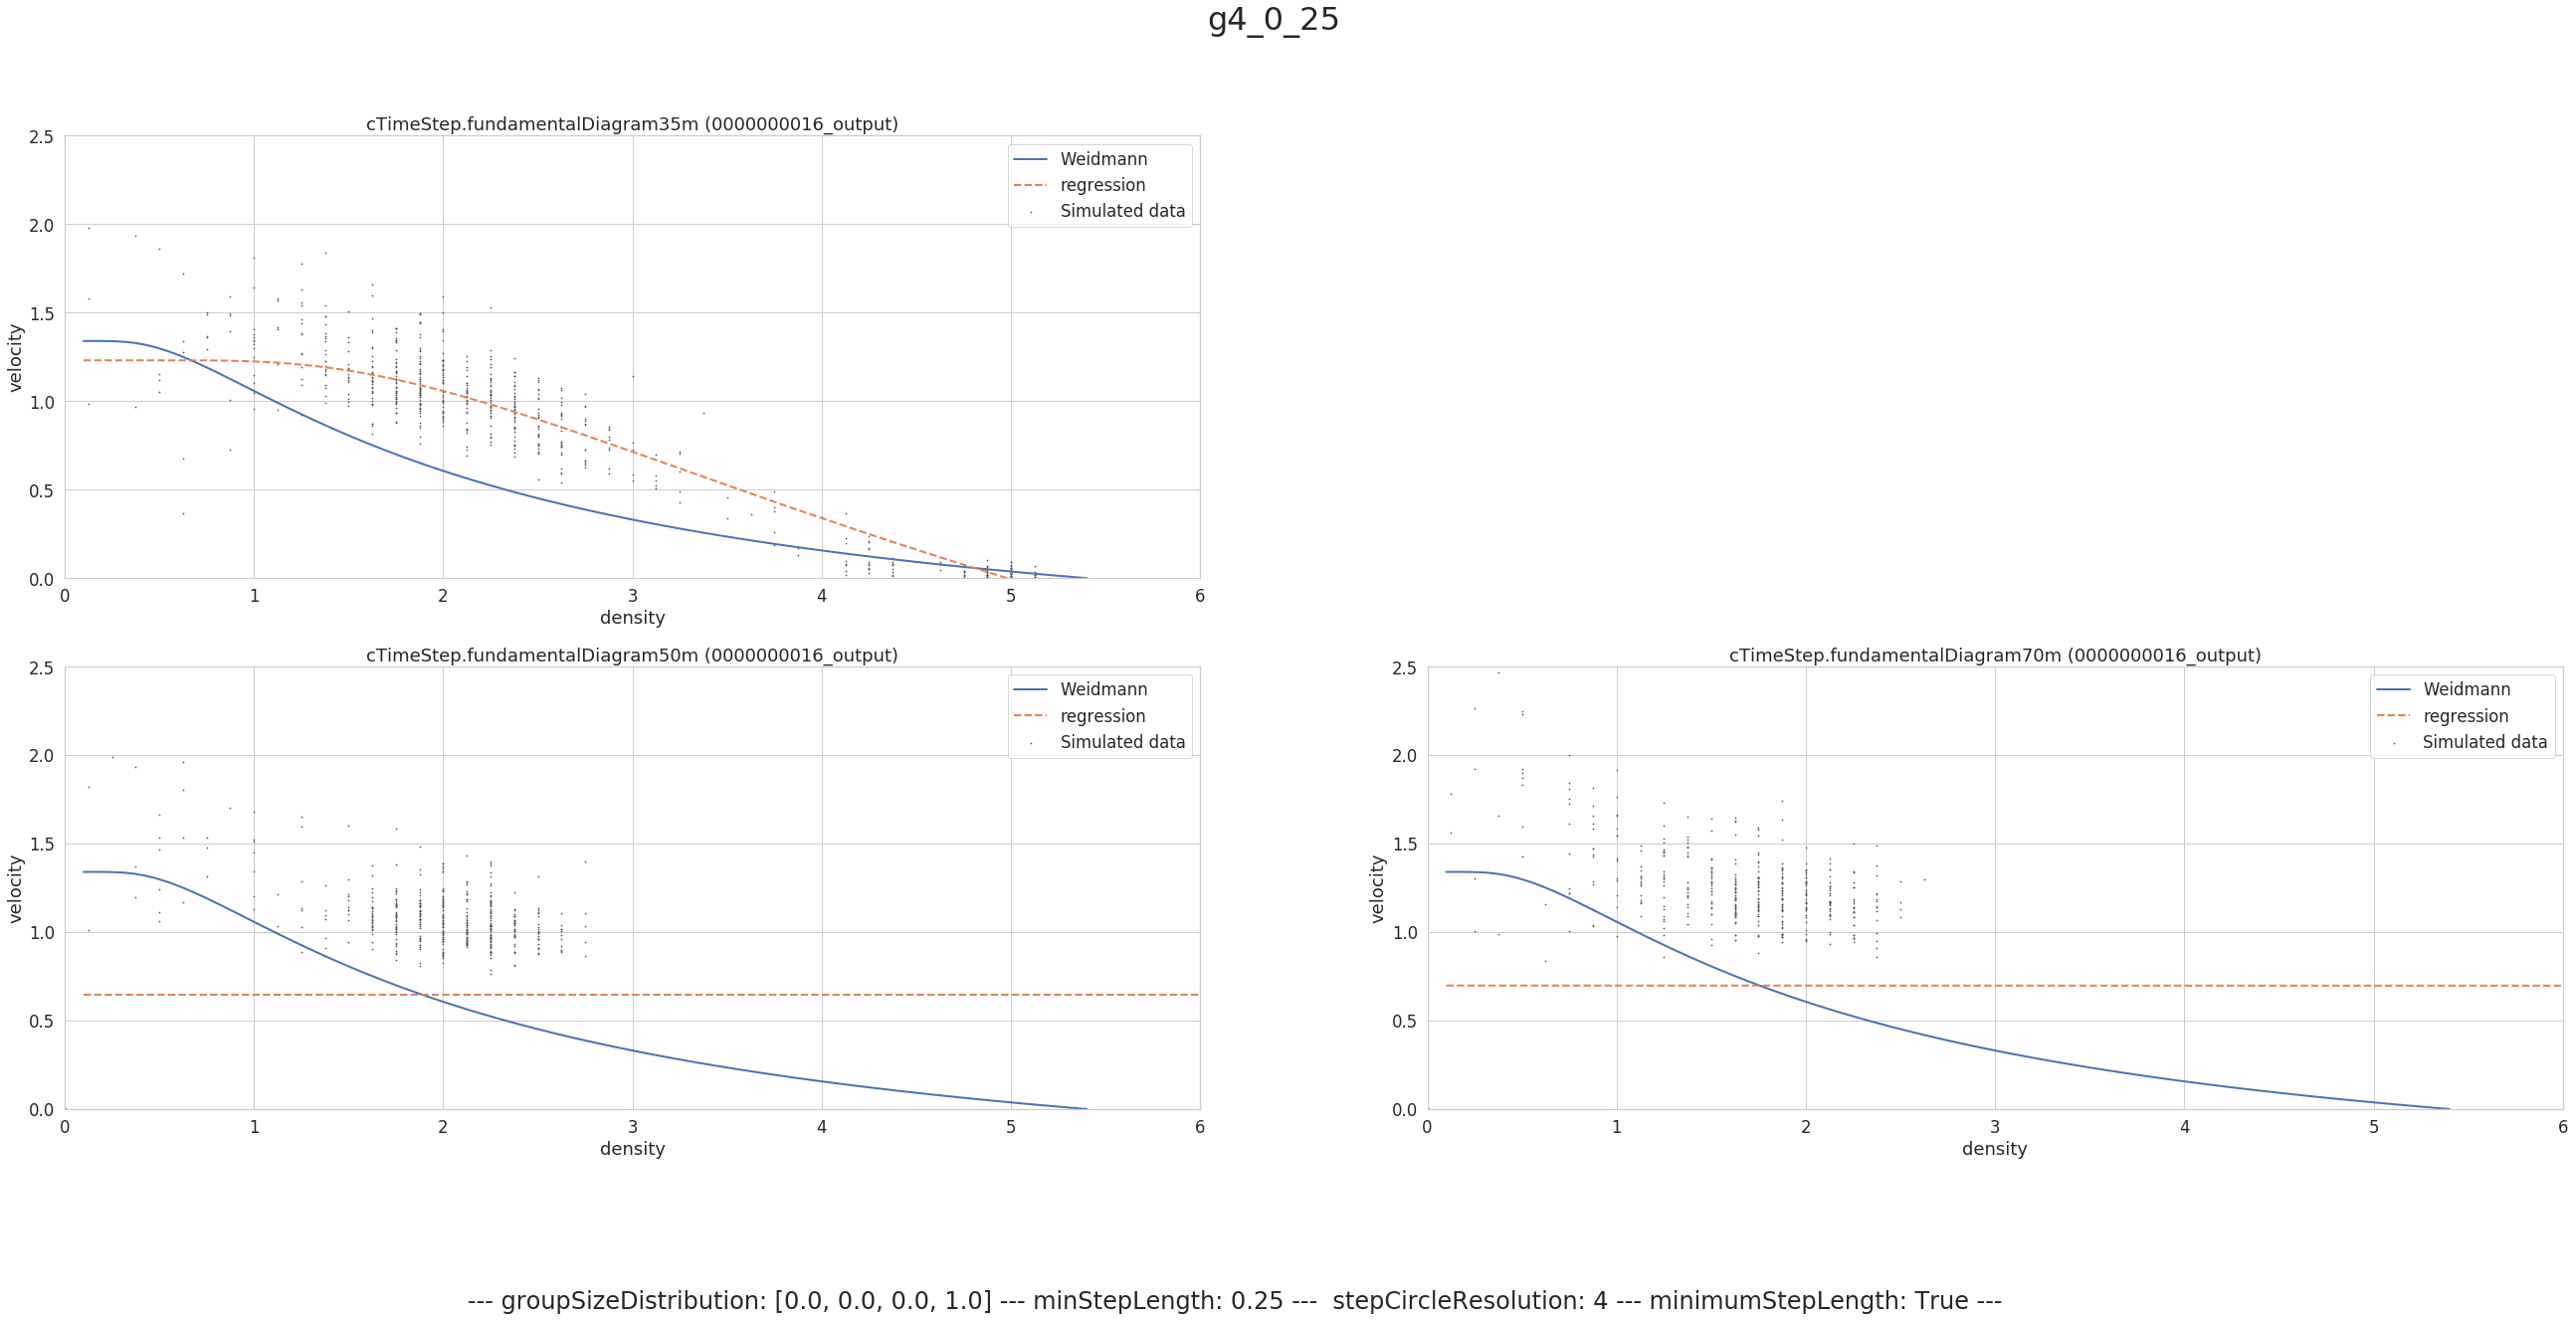

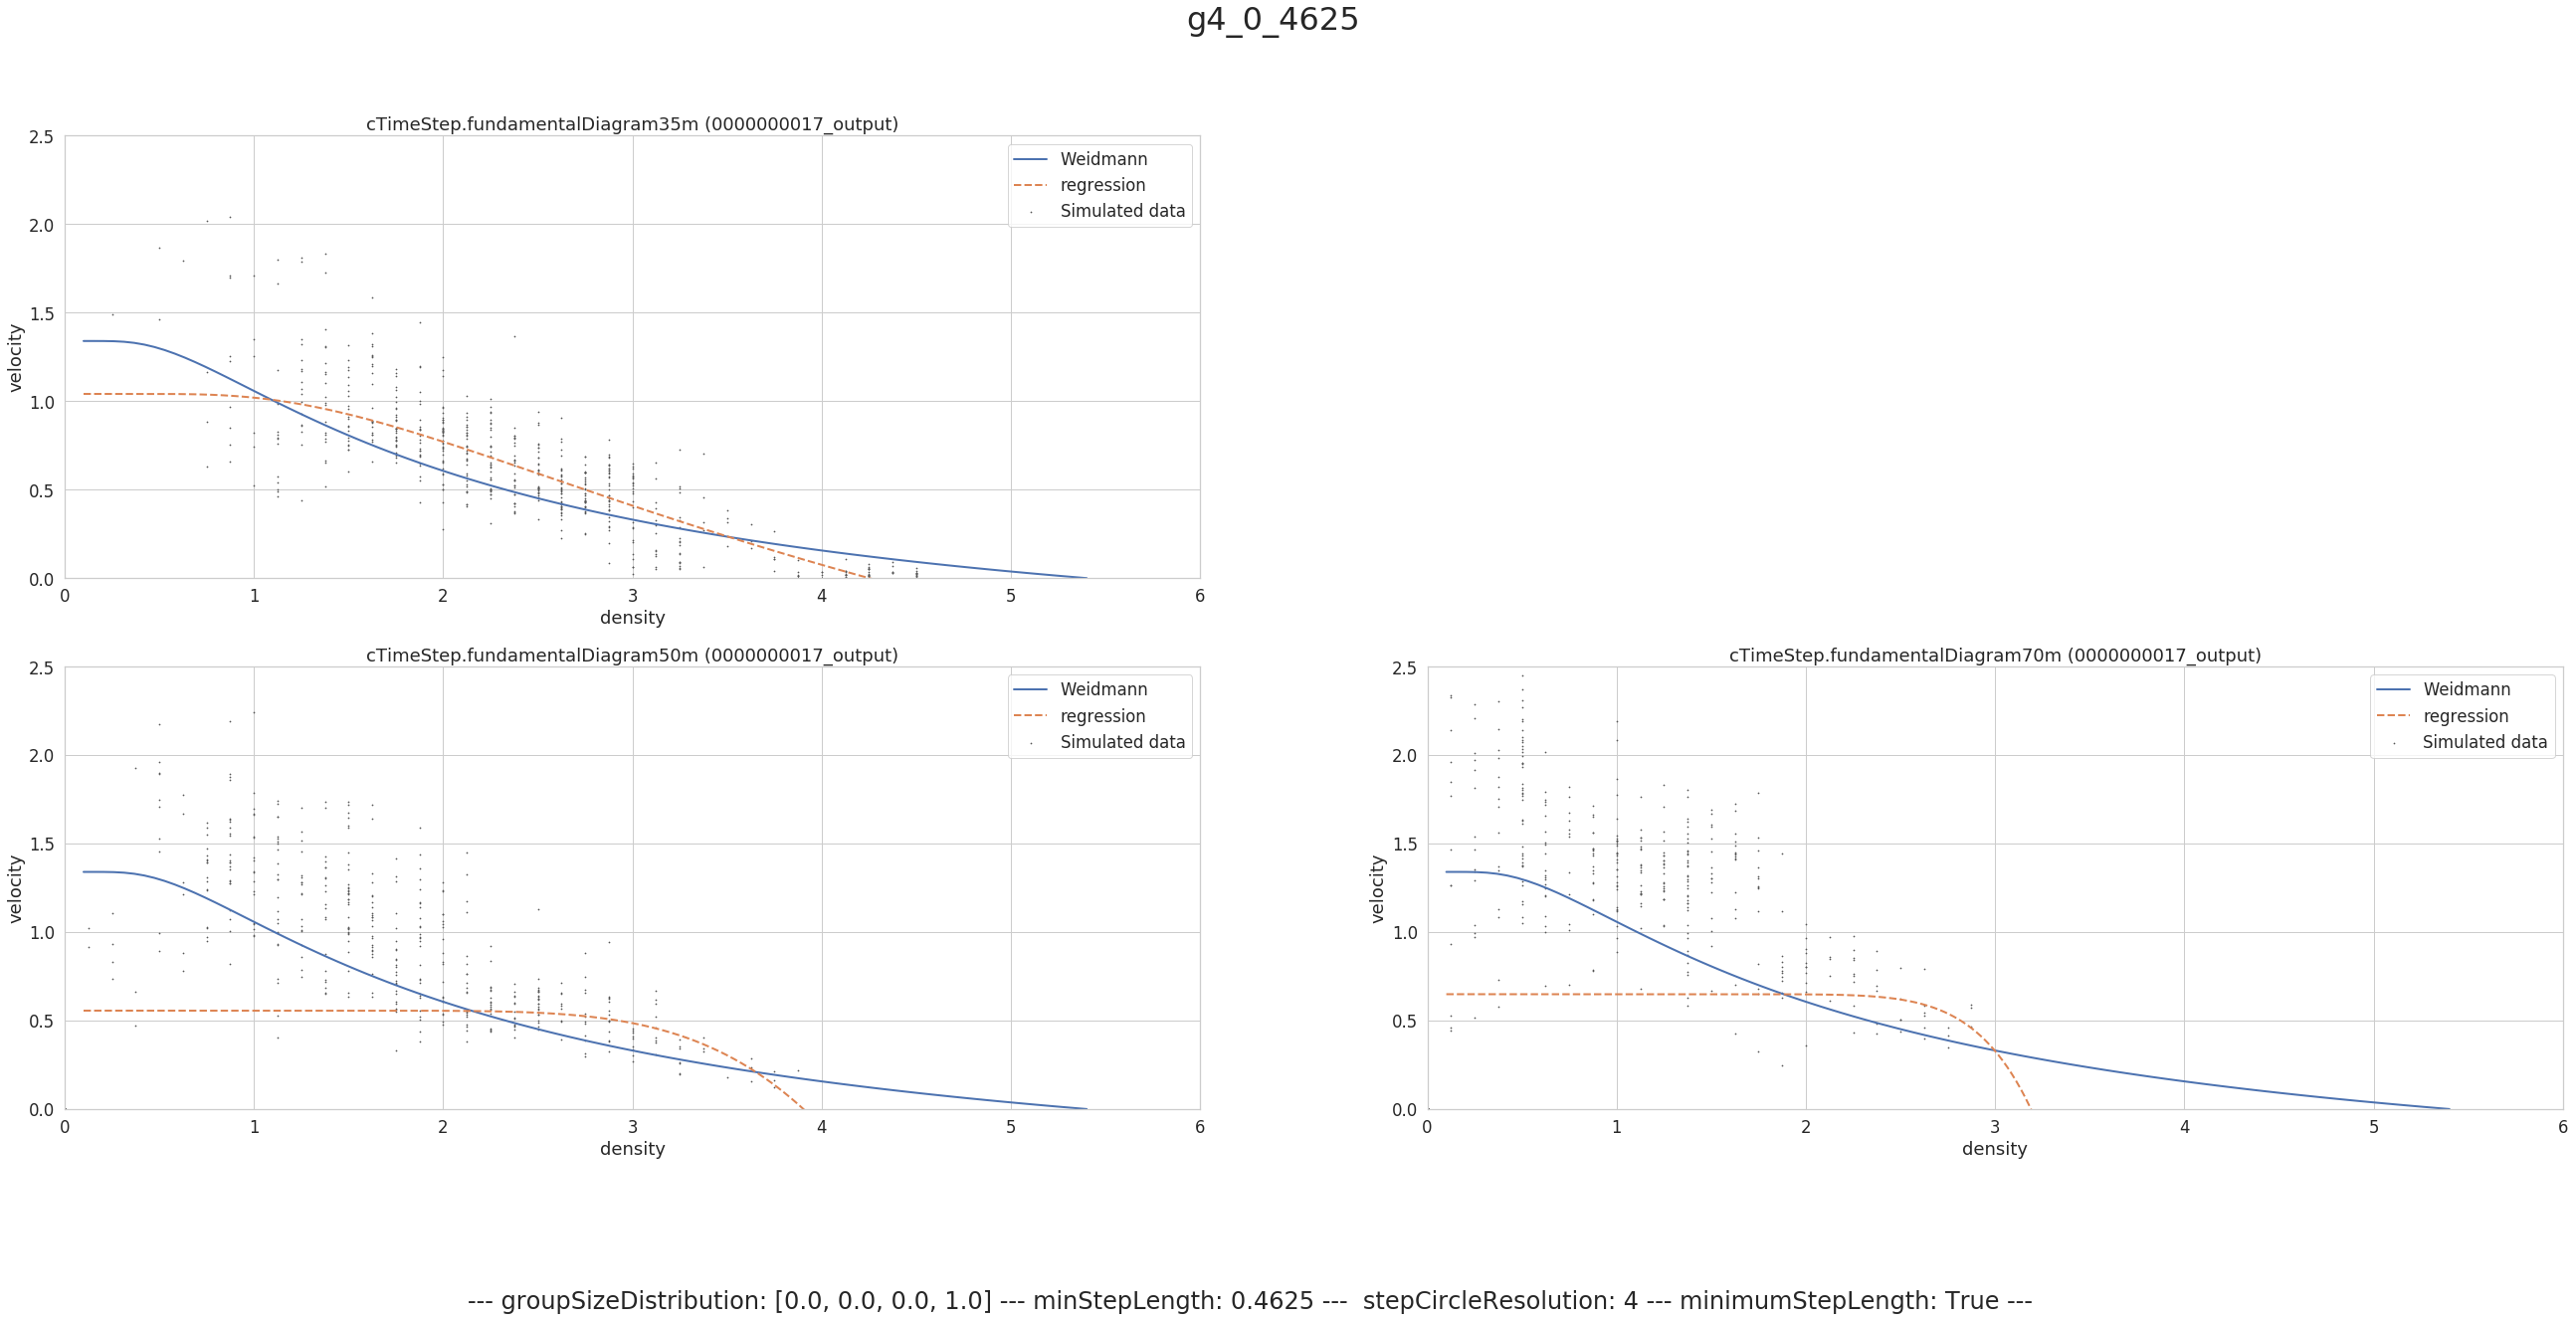

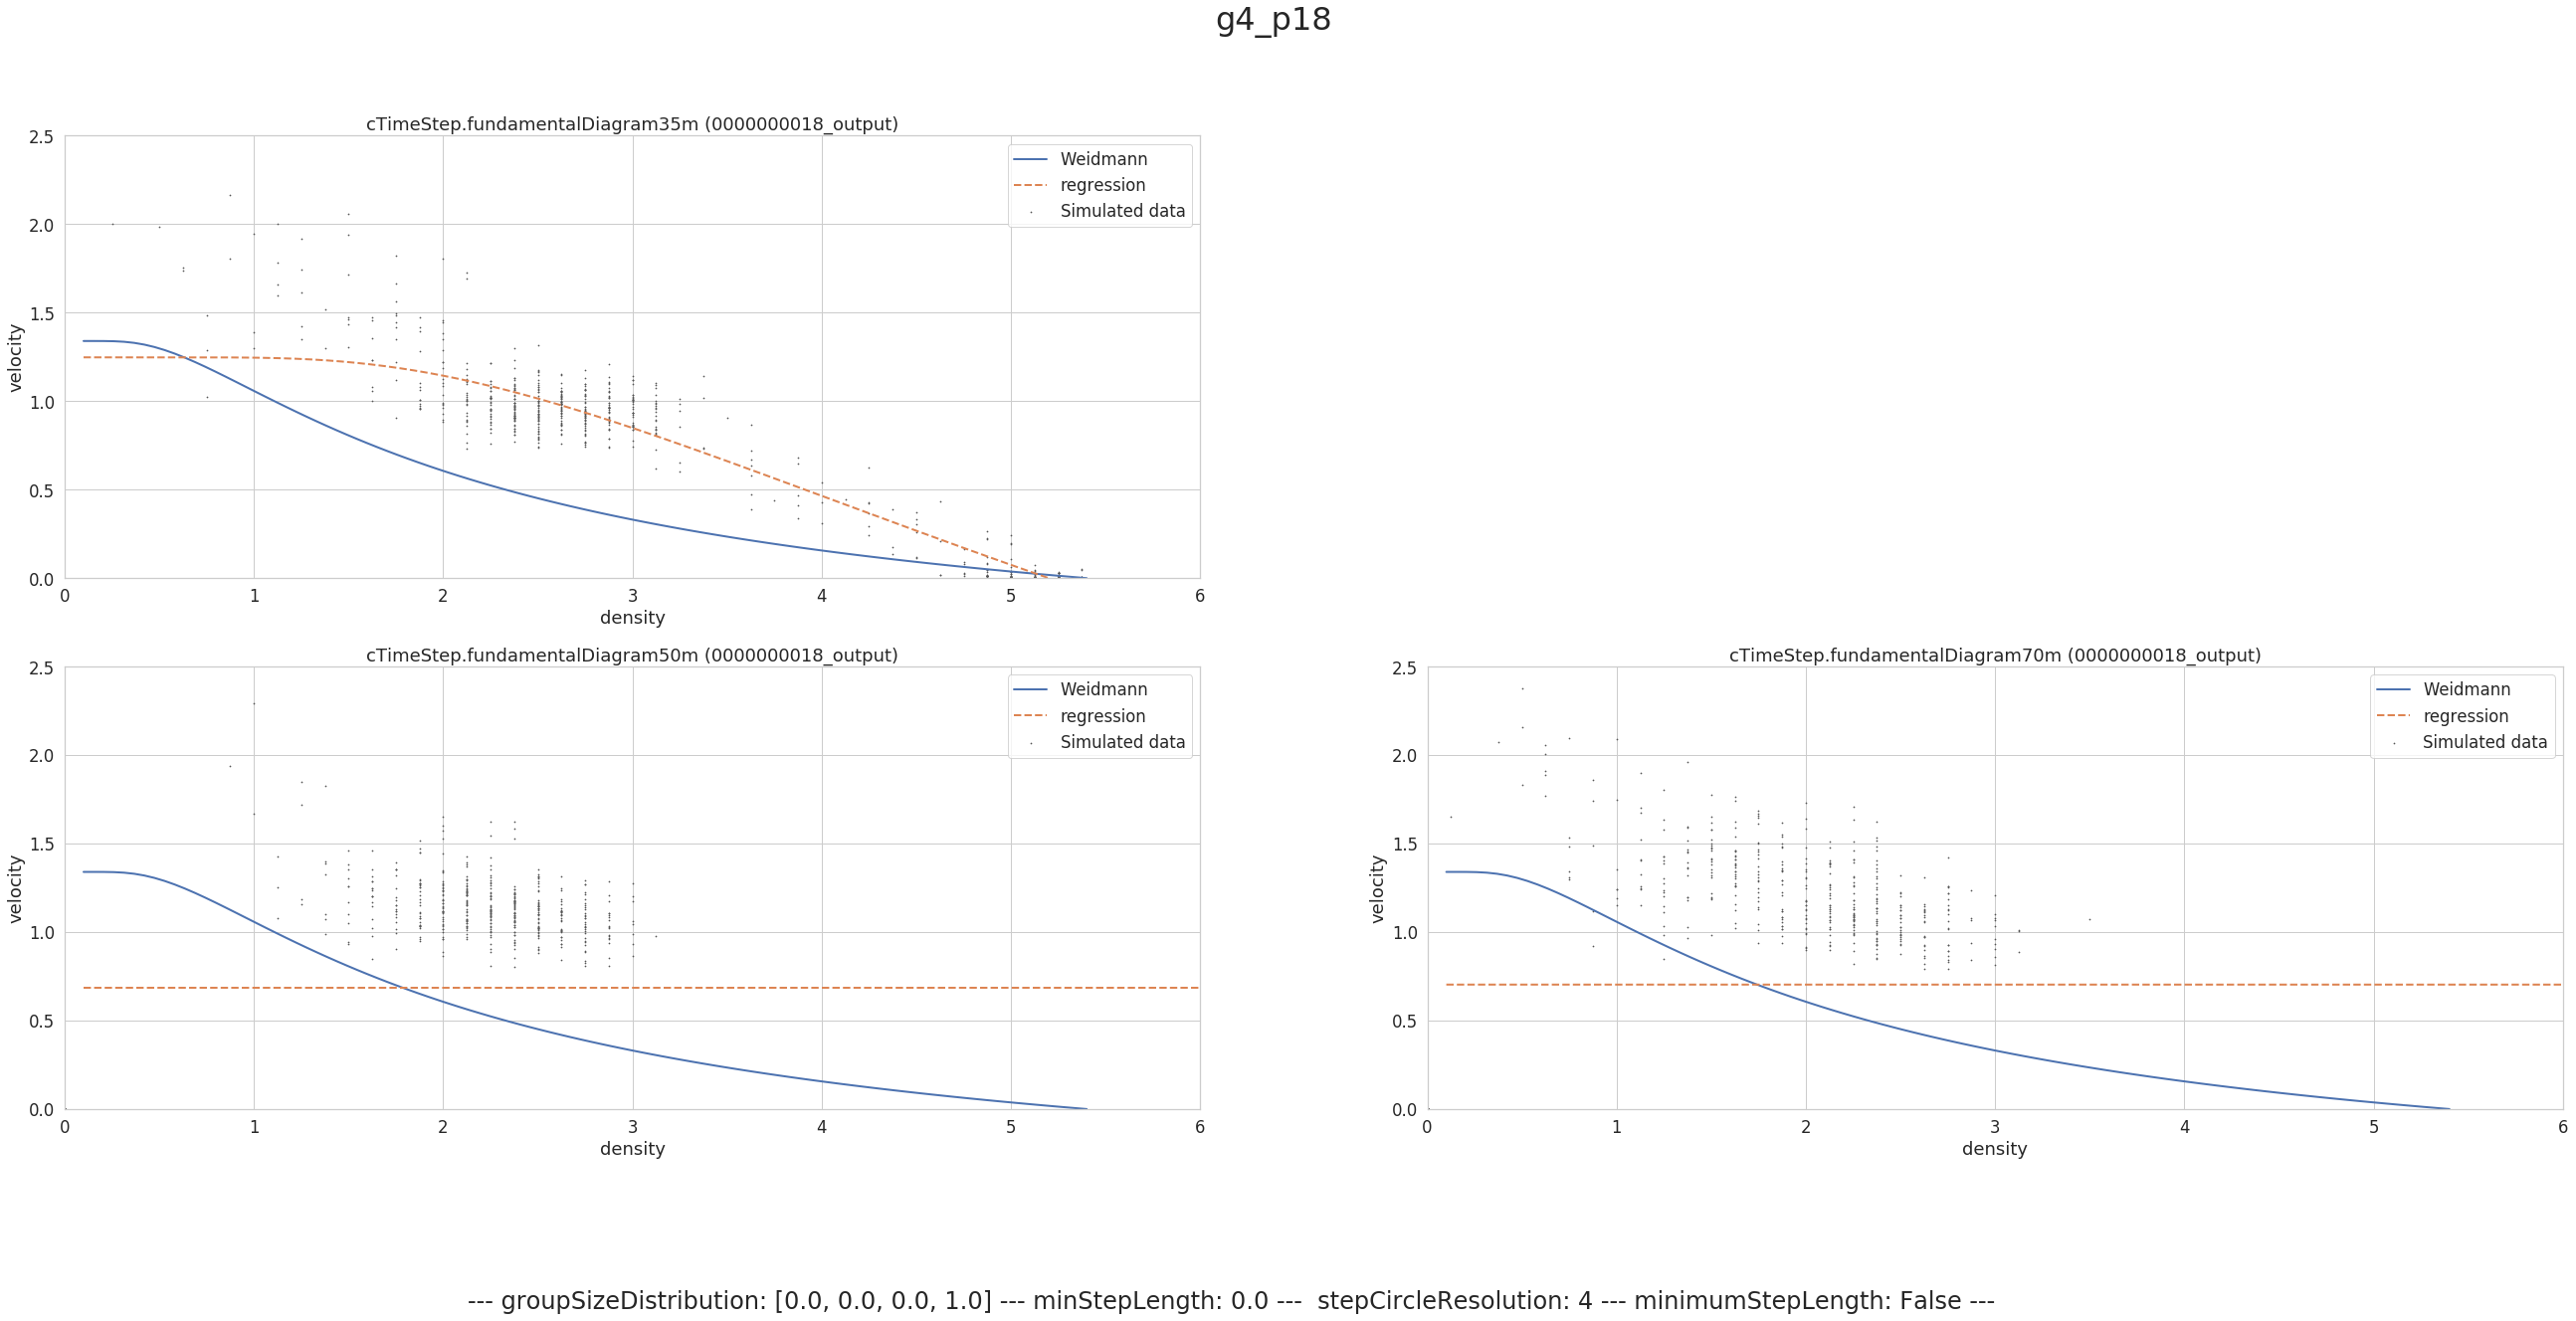

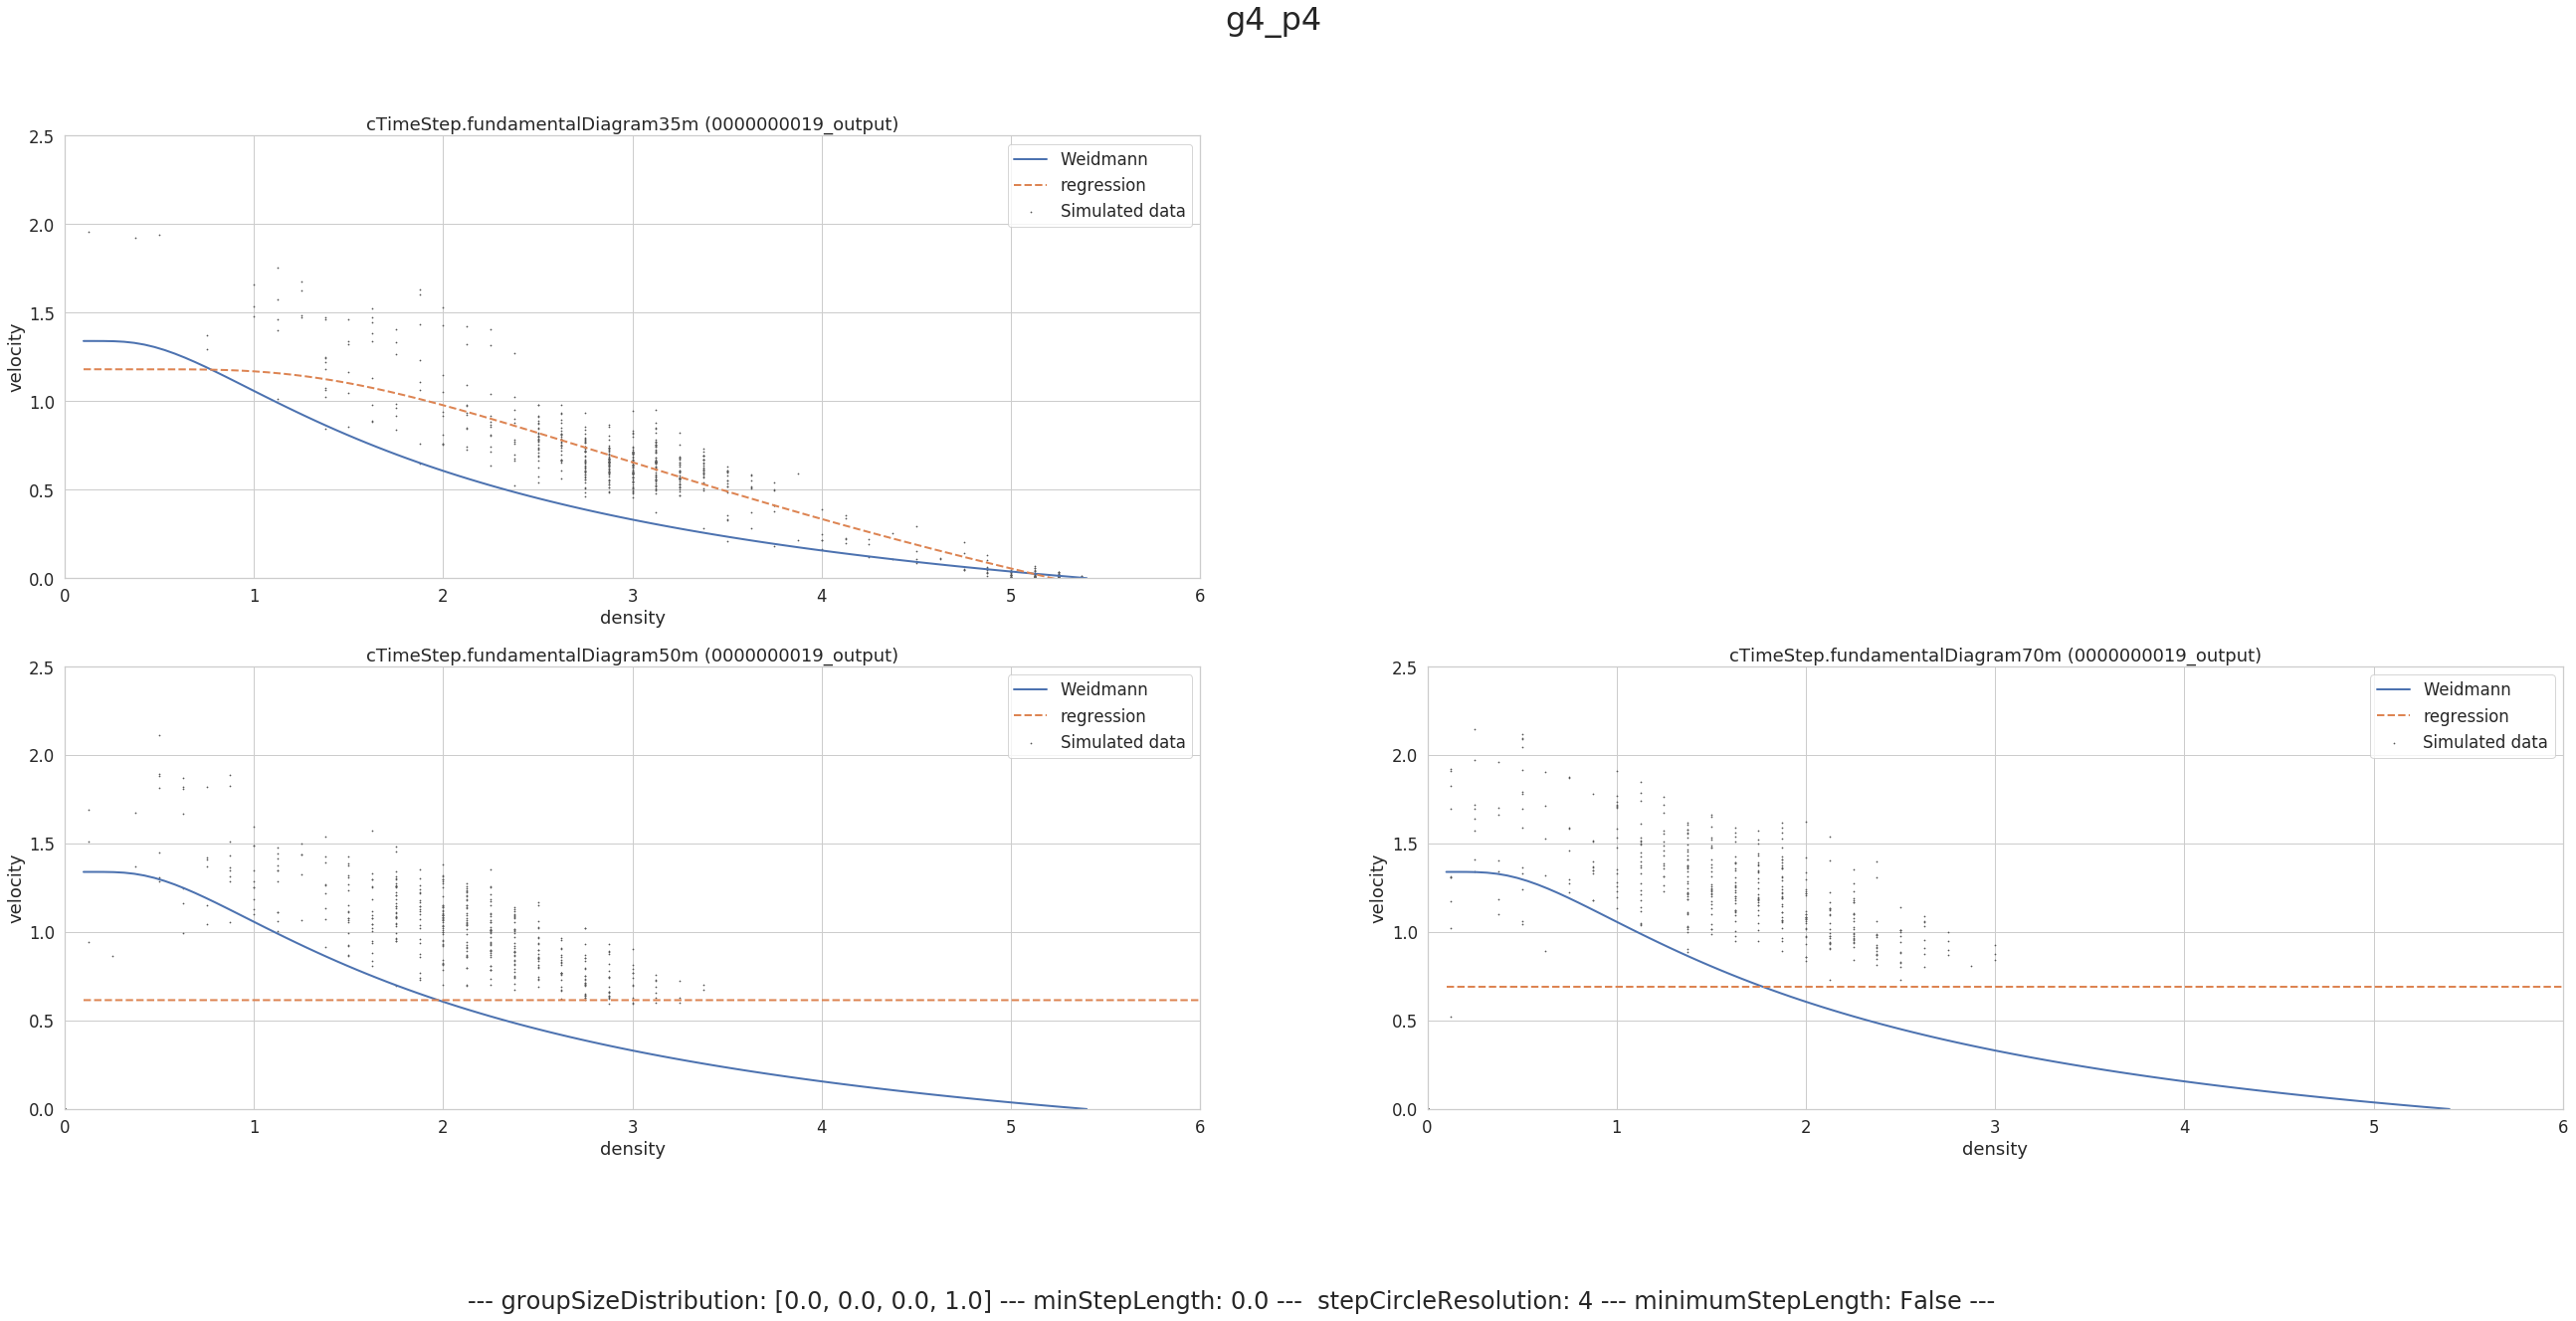

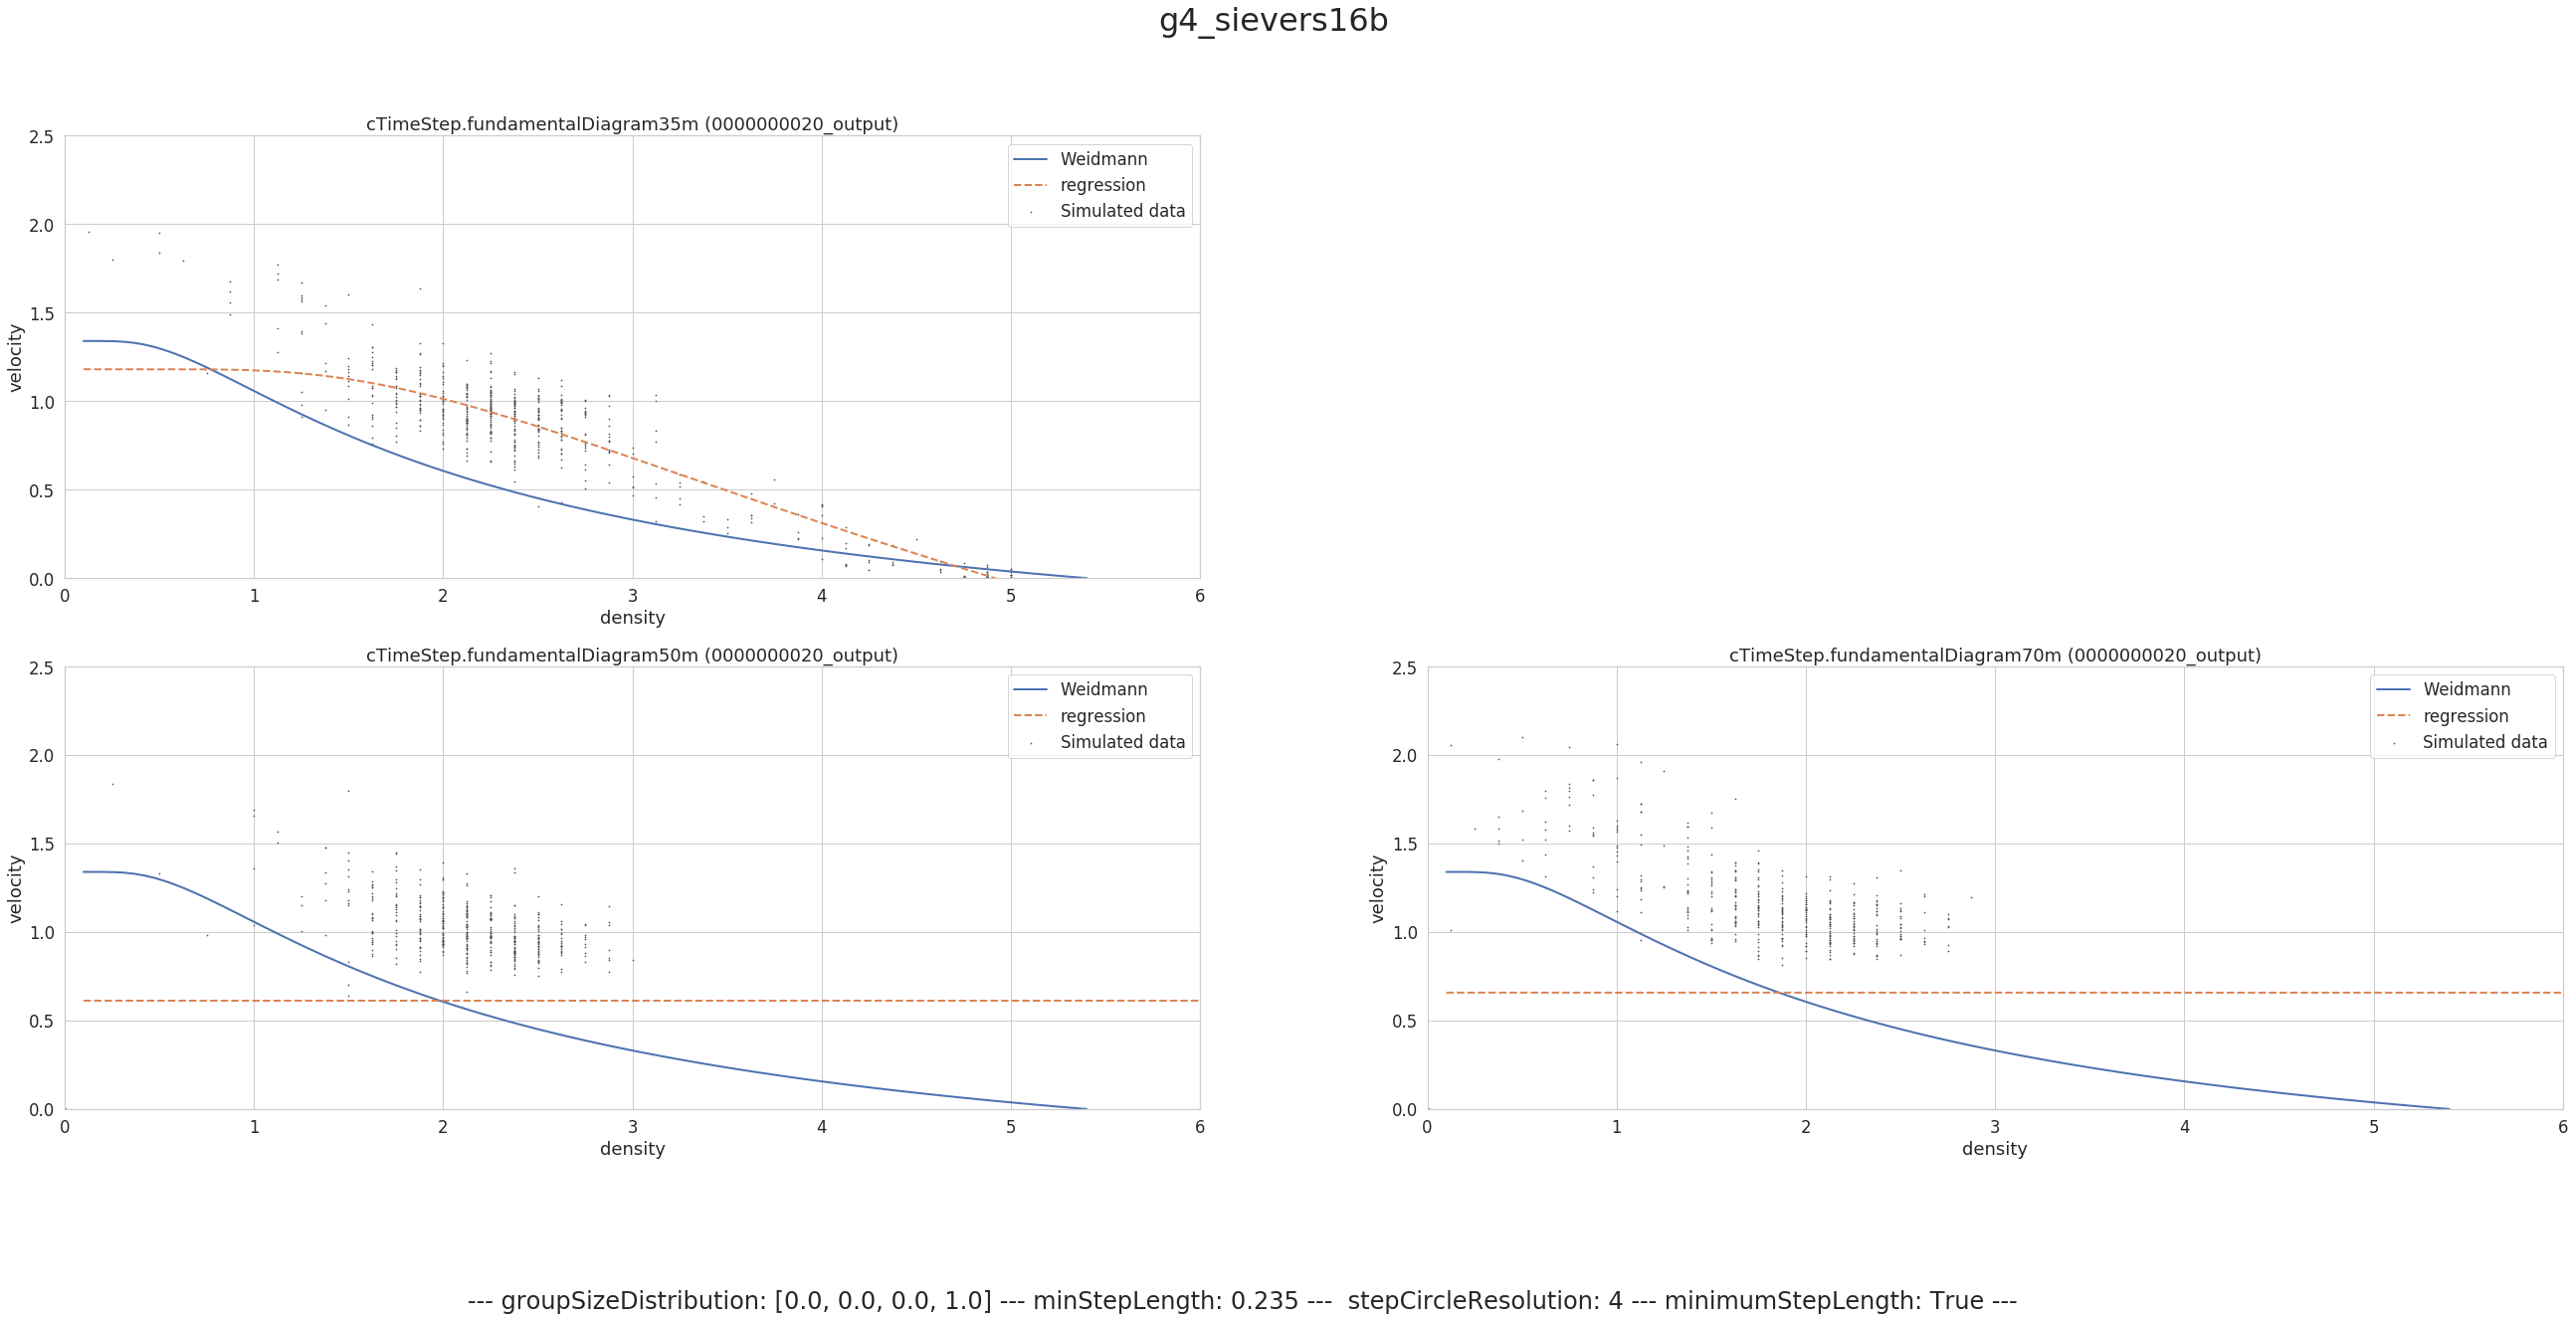

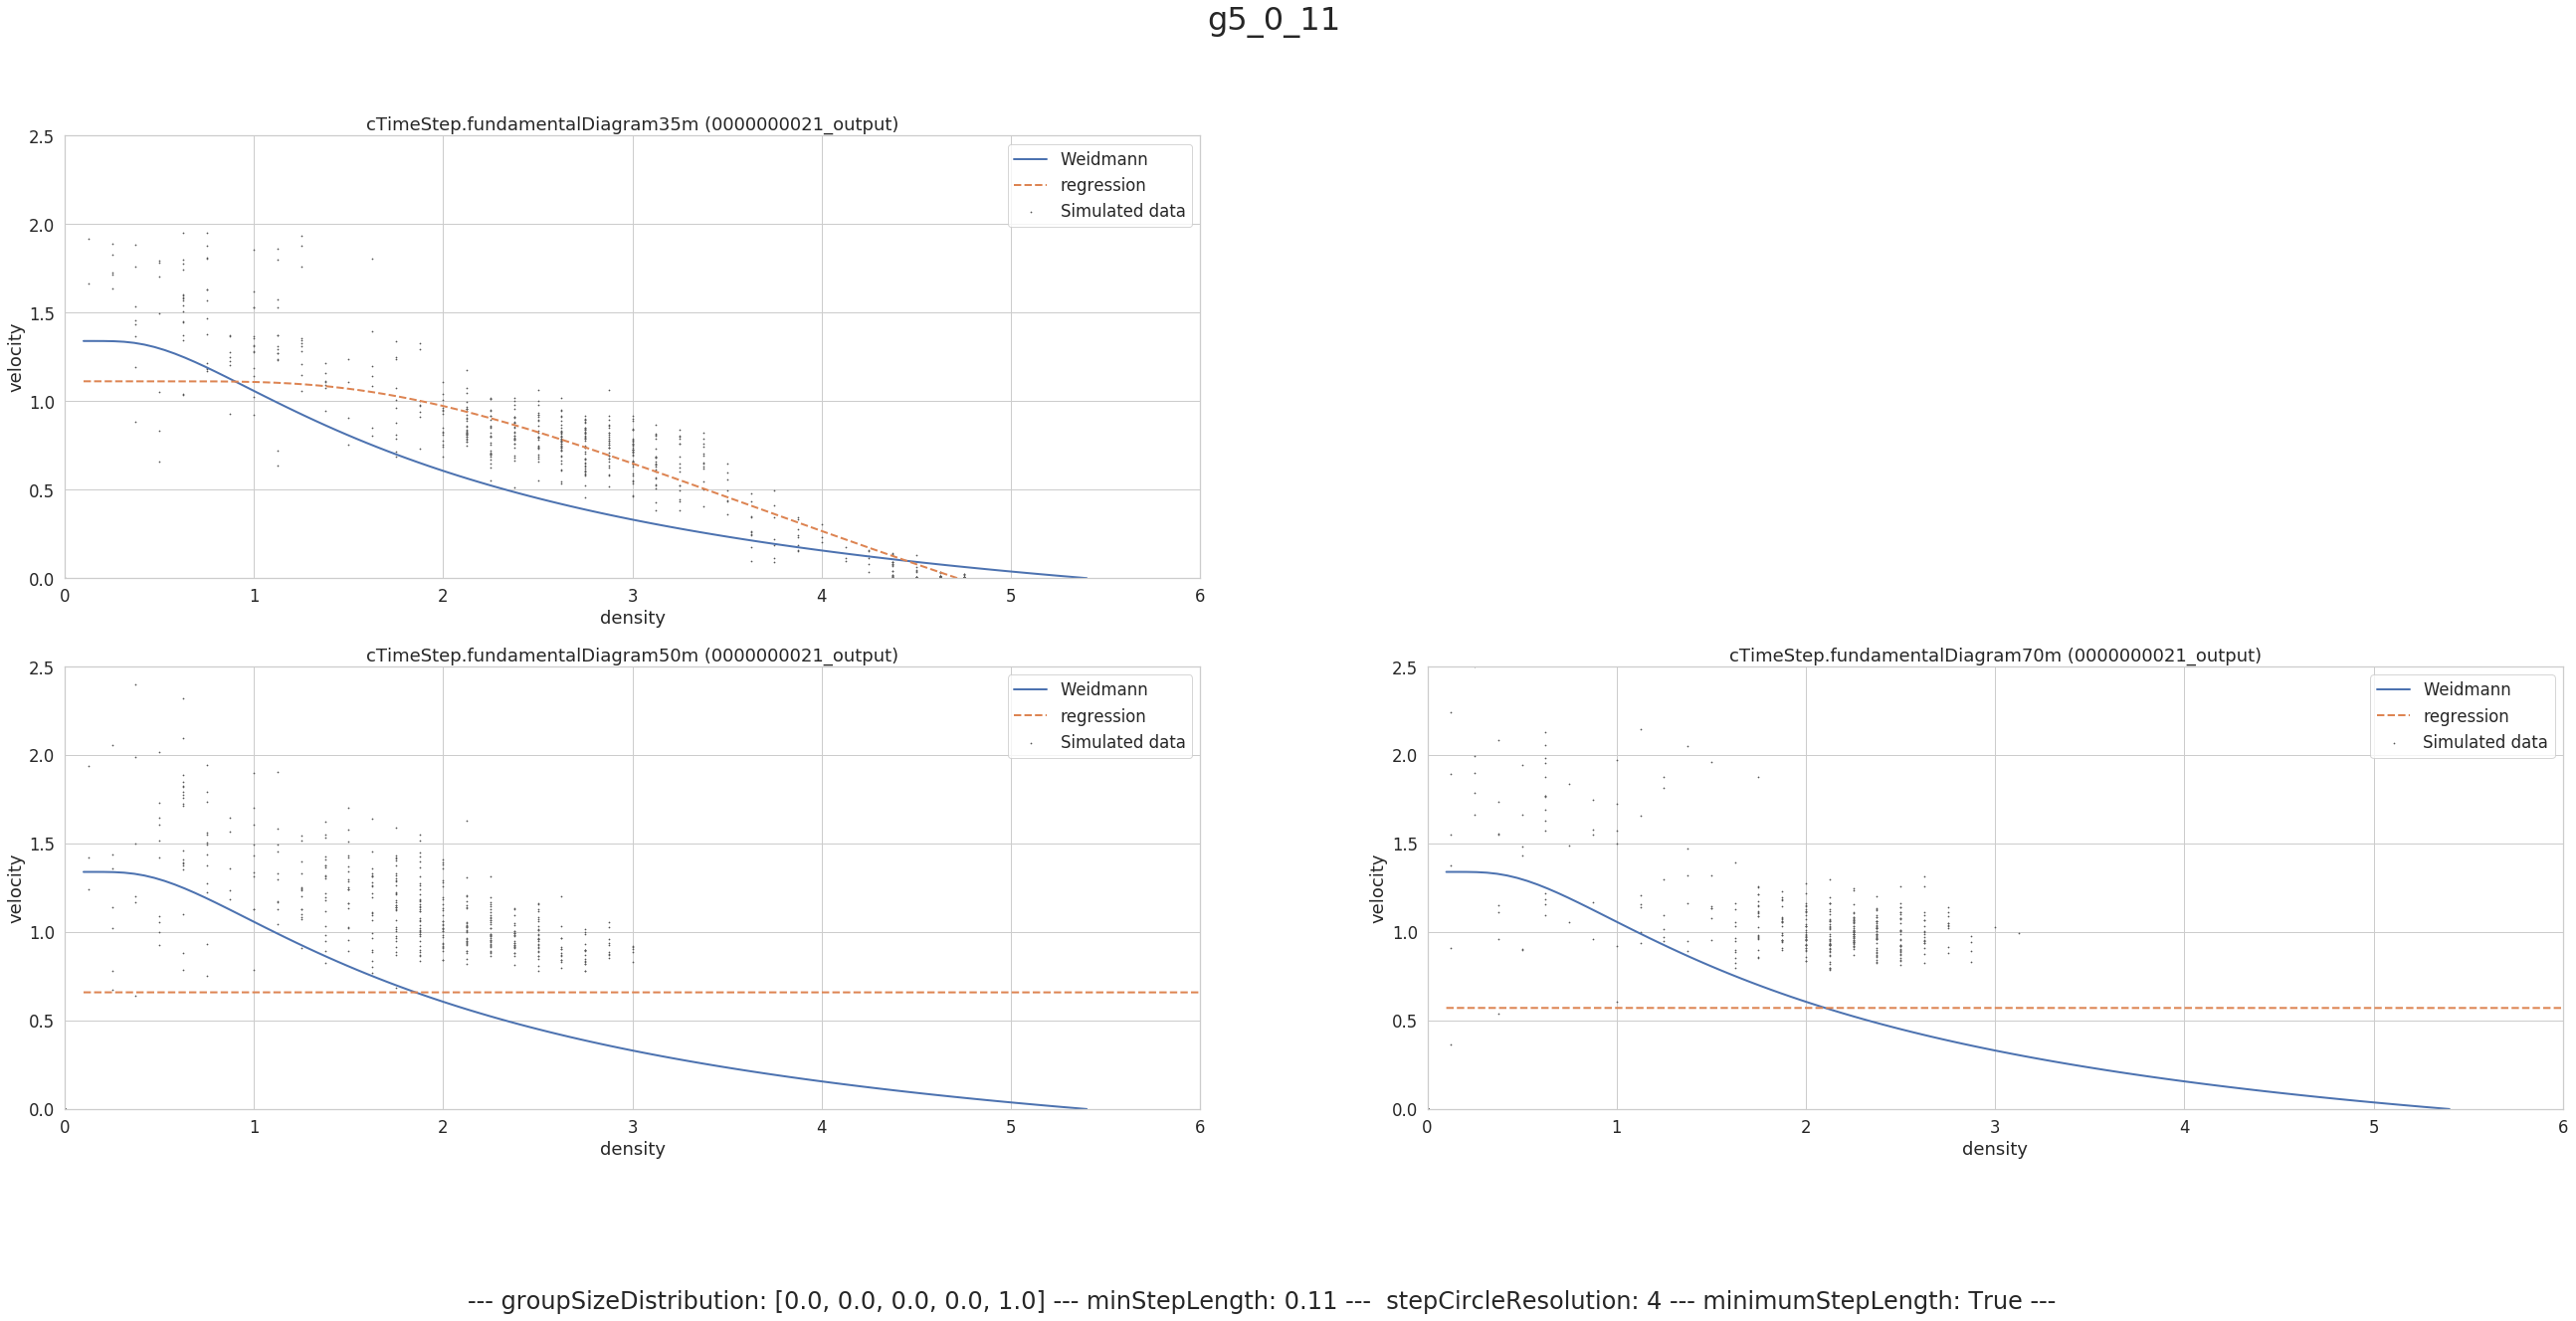

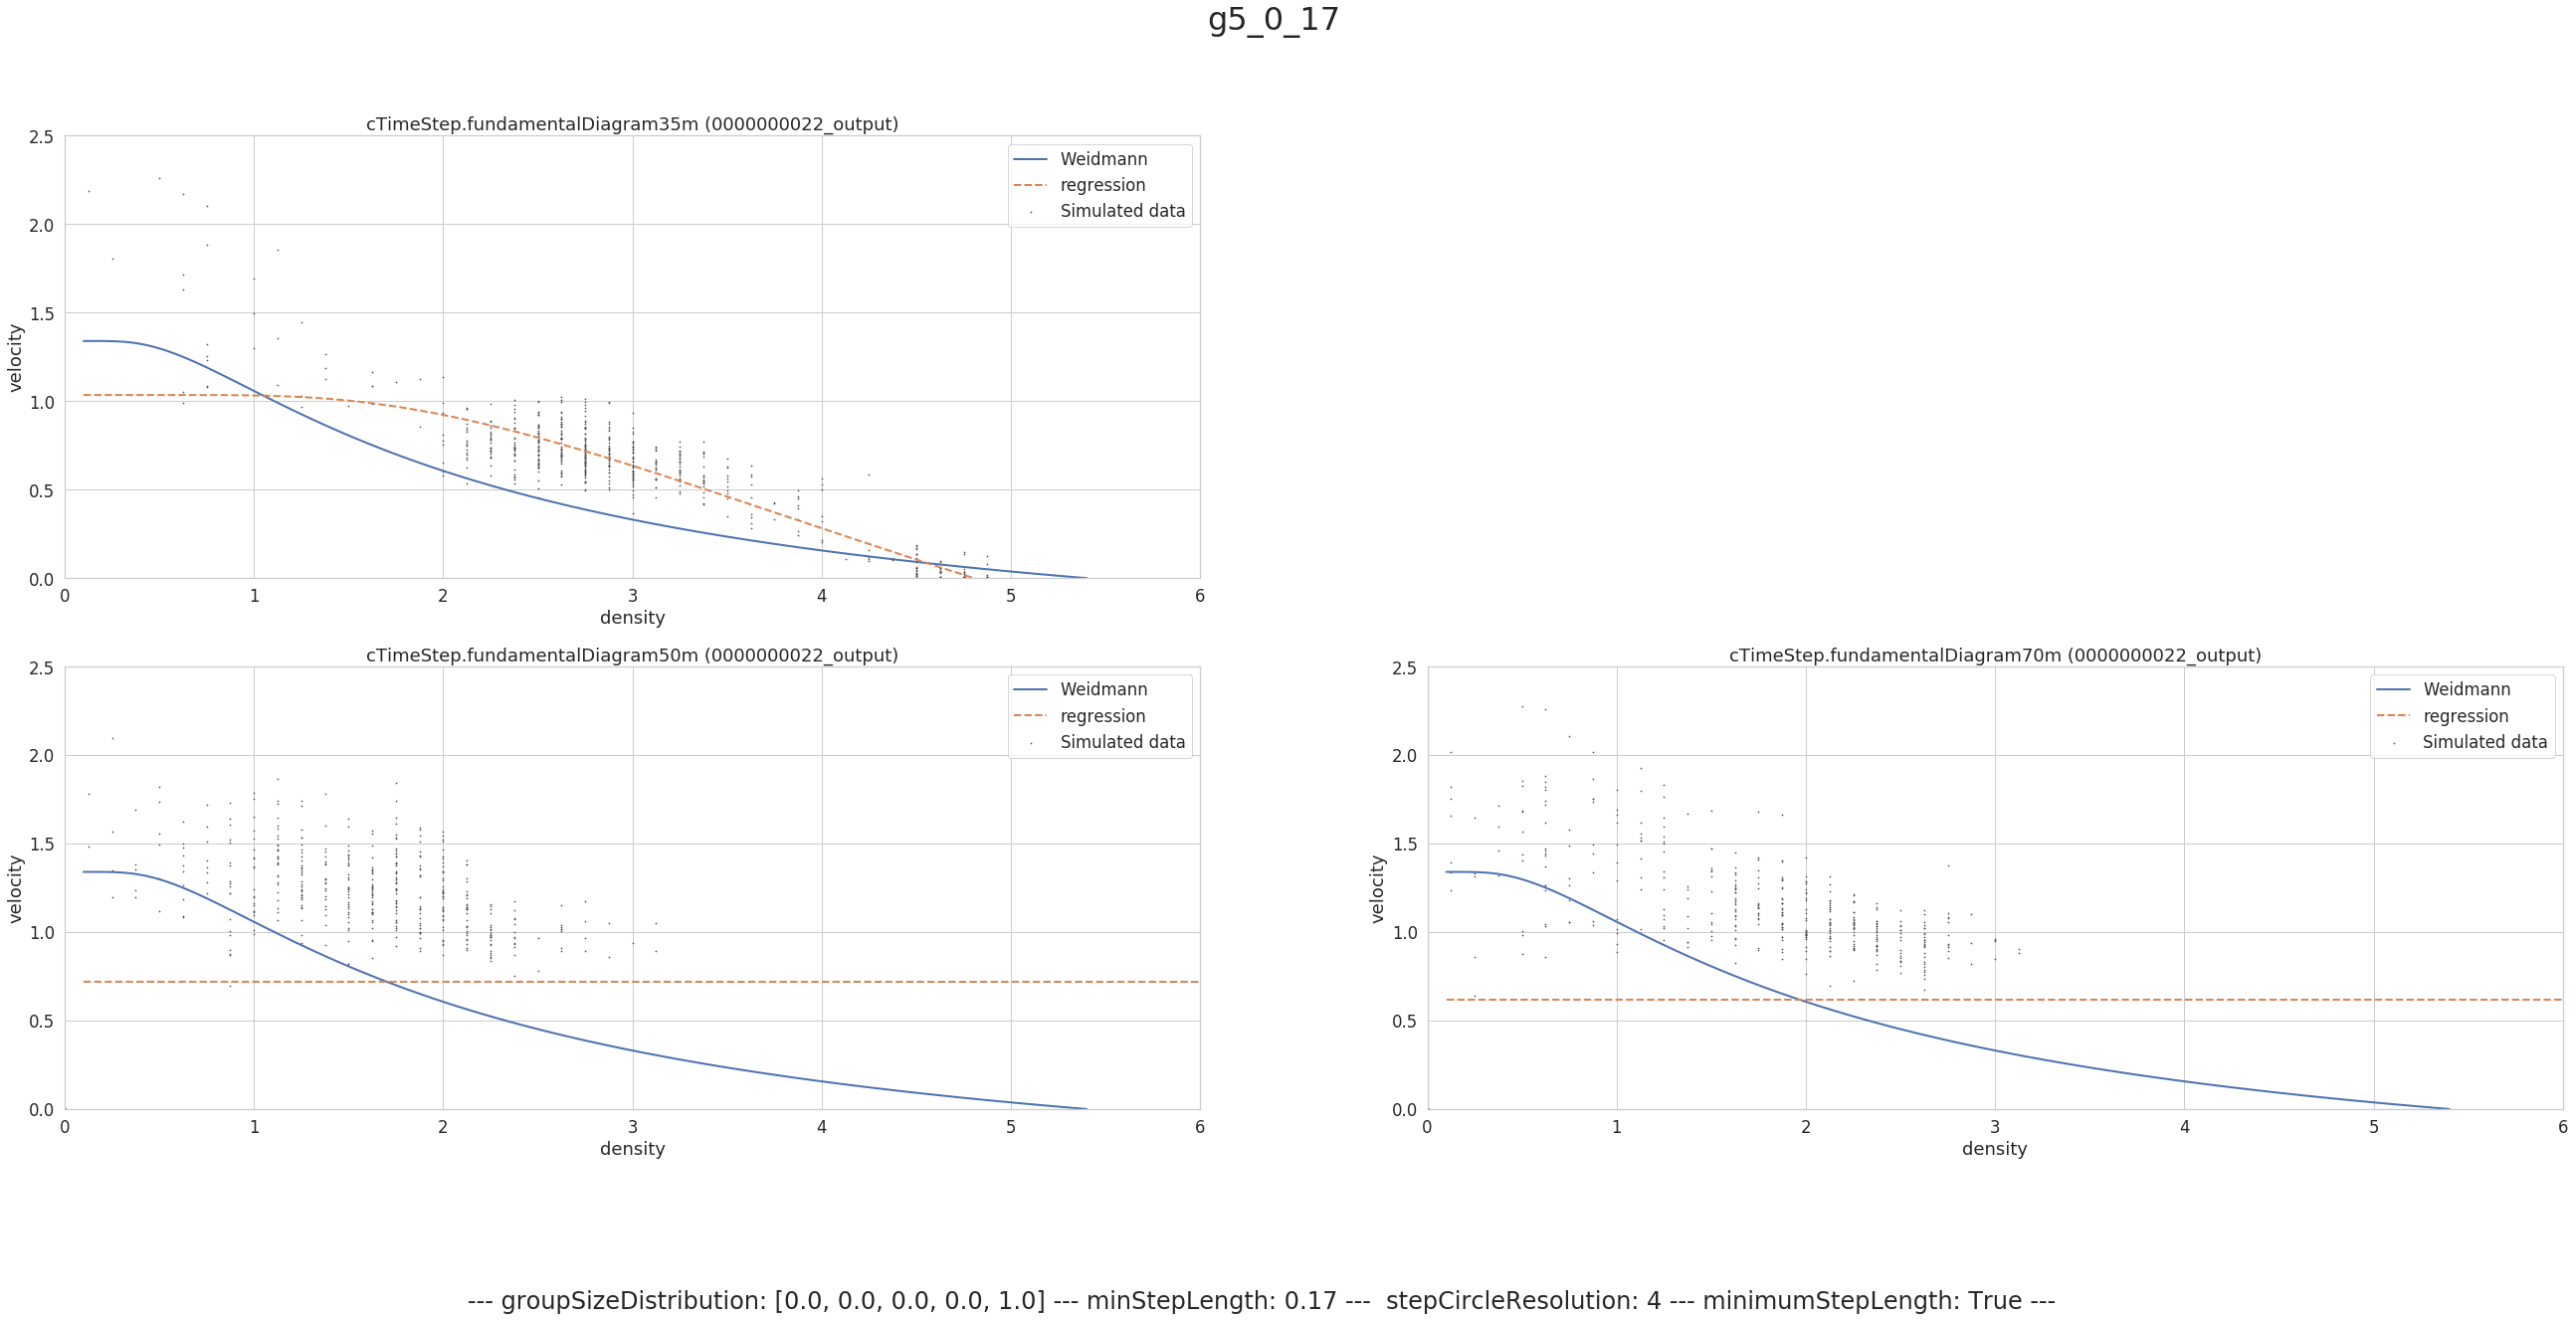

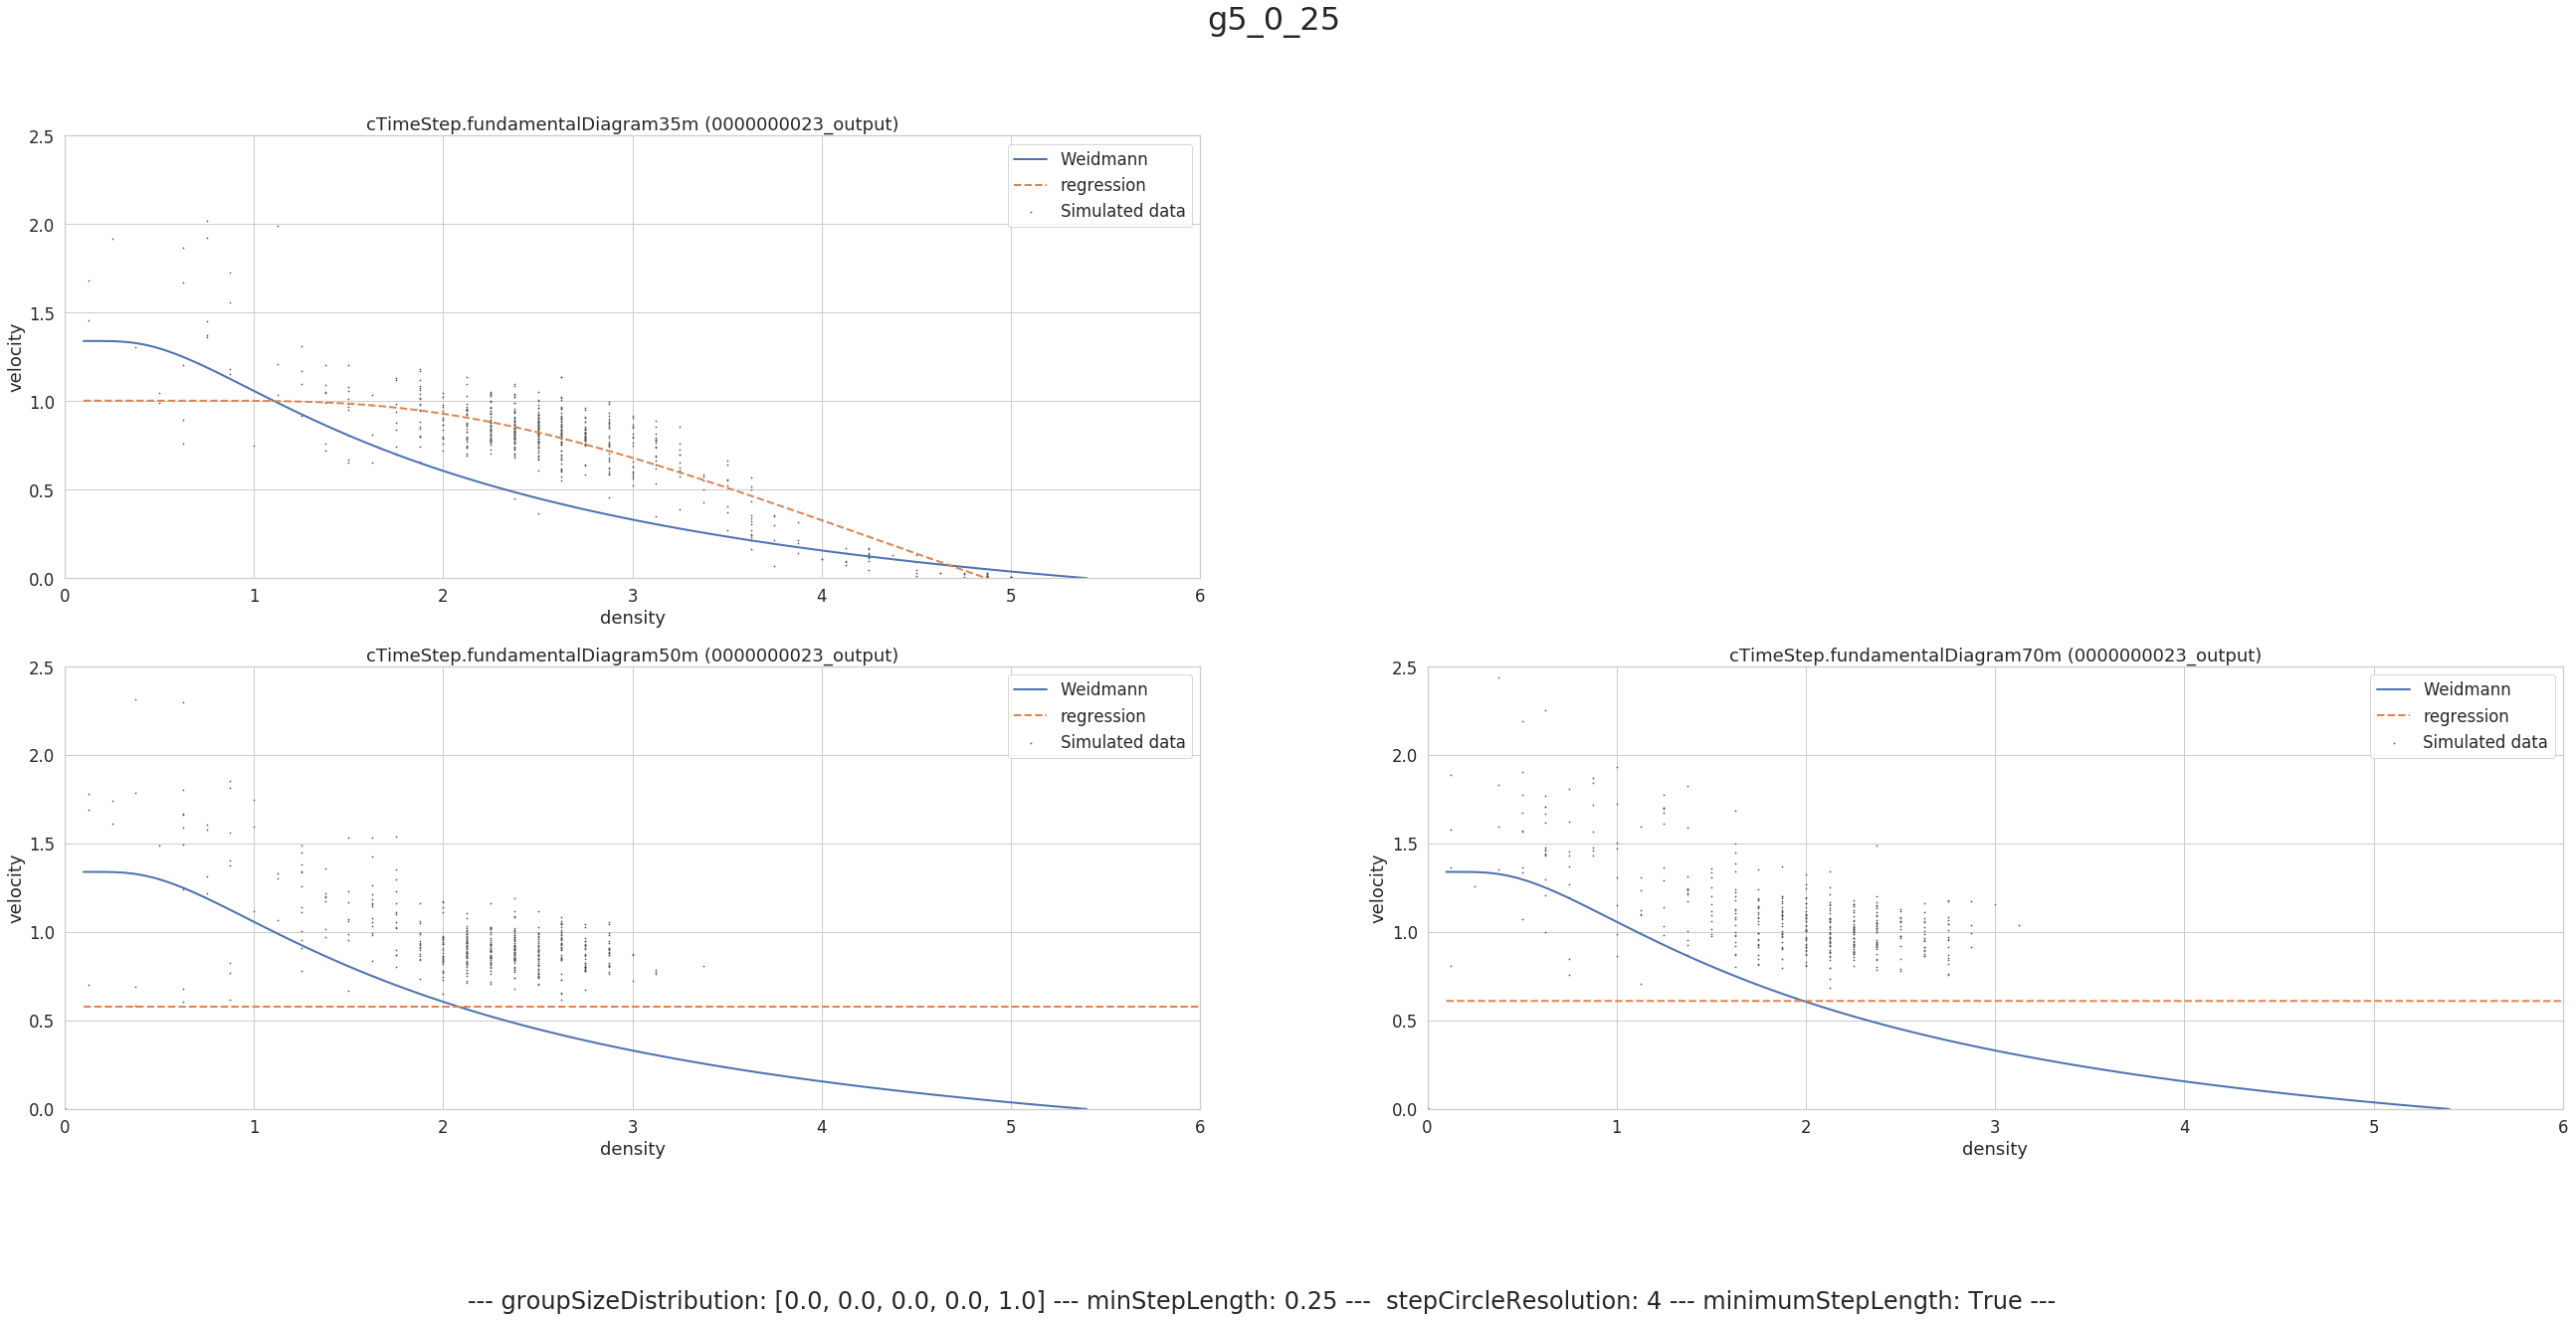

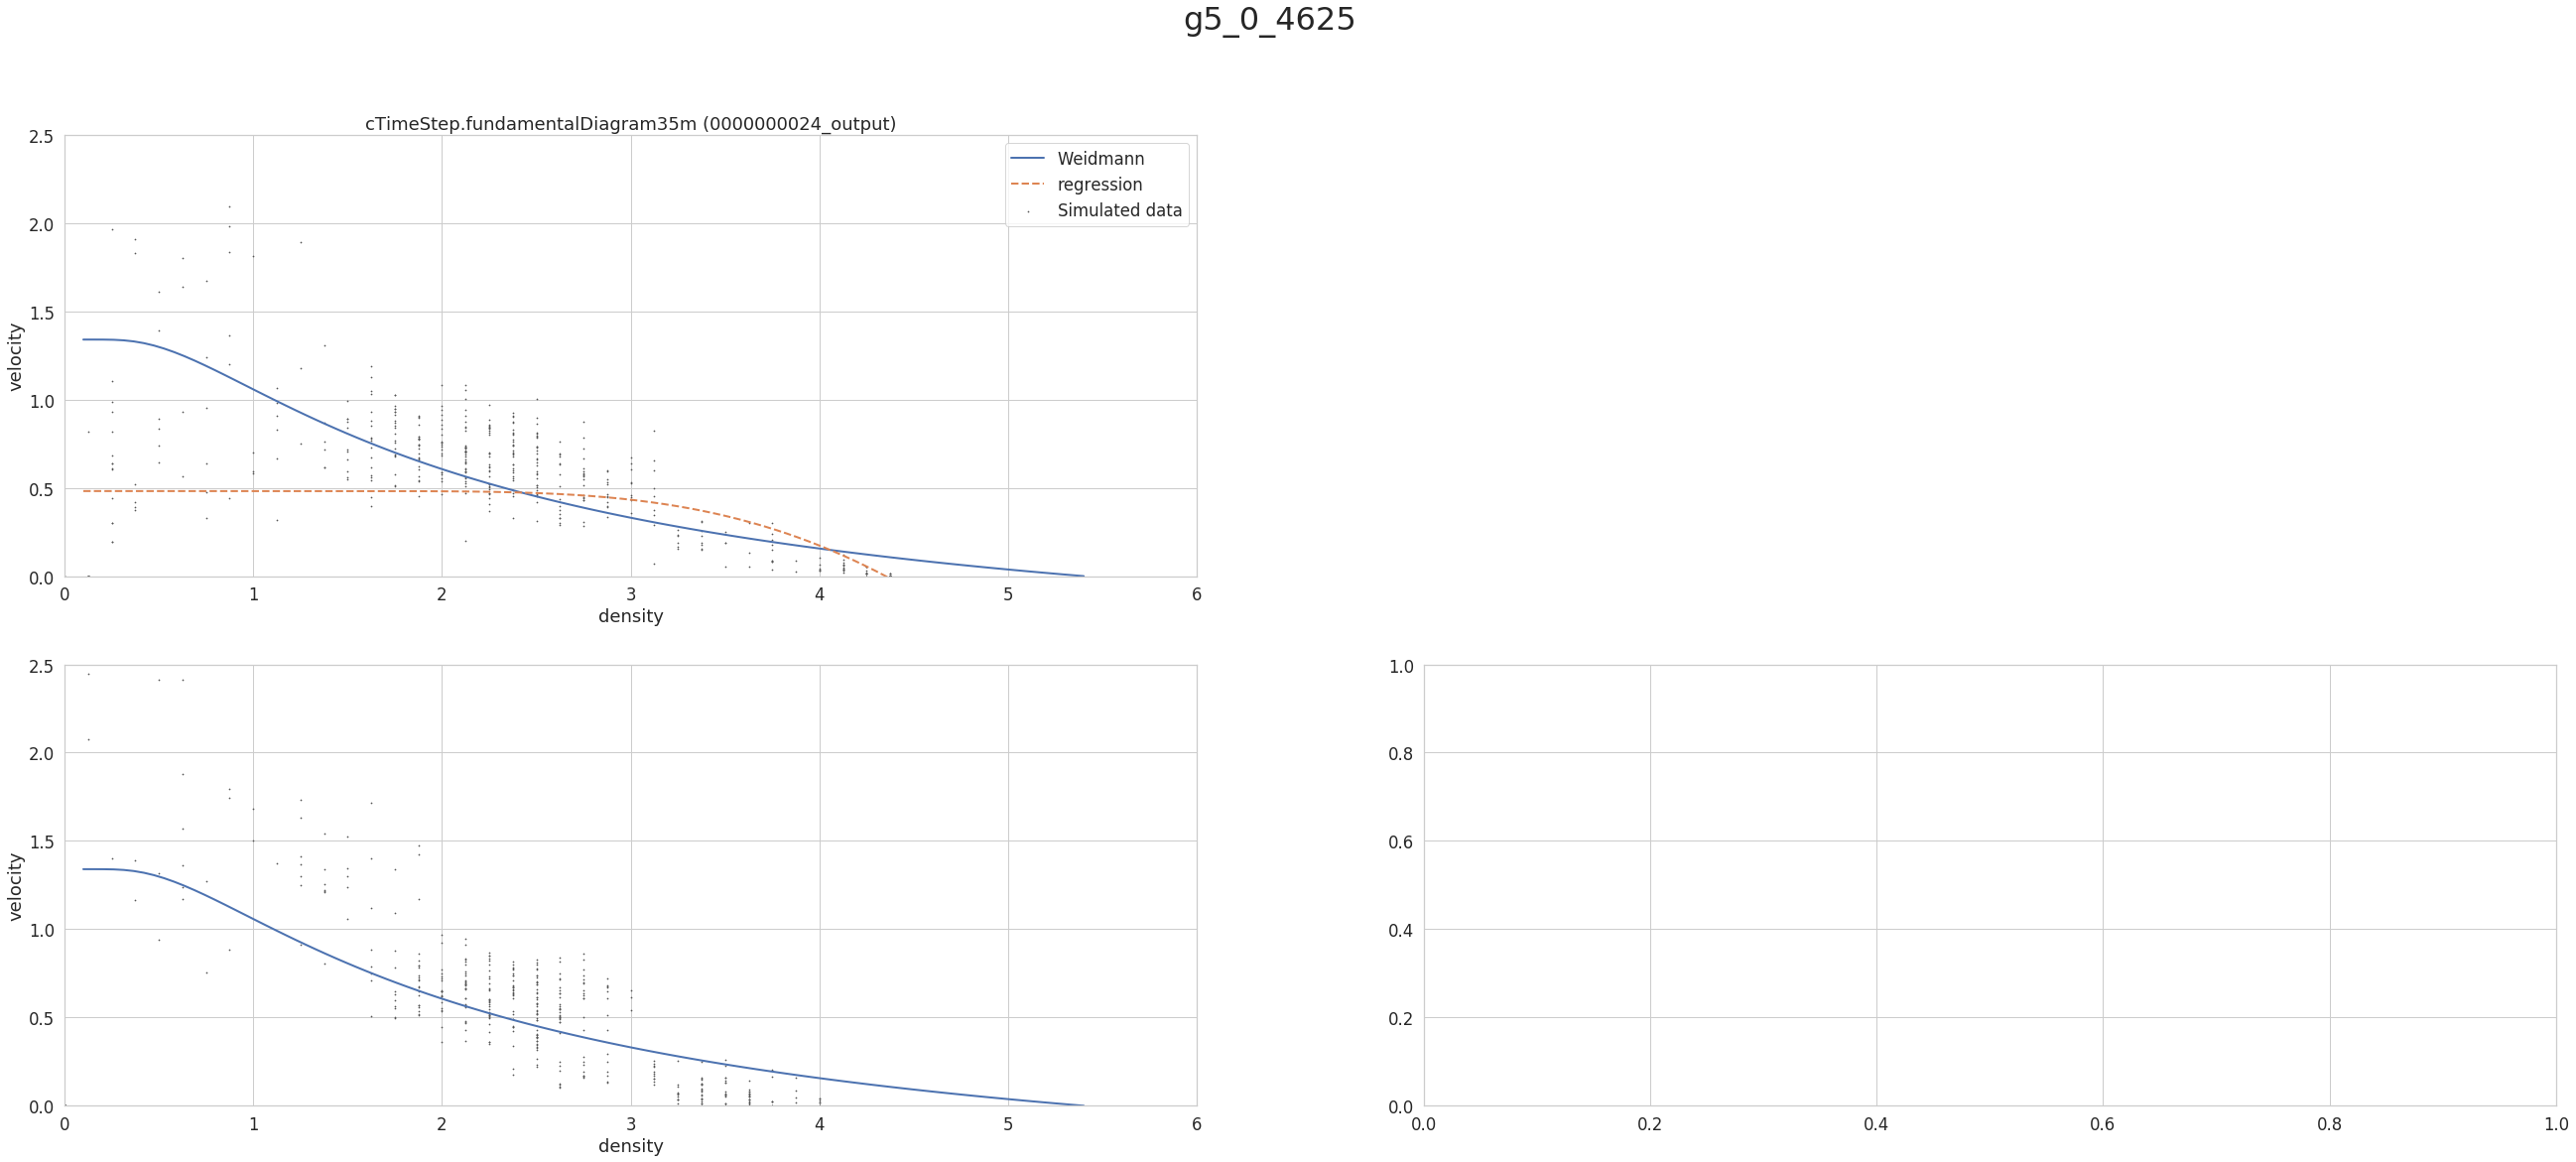

In [10]:
plotFundamentalDiagramScatter2(outputs, processors, True, 18, 15, export_path='/home/lphex/hm.d/presentations/groupmodel/bilder')

In [ ]:
% get_backend()

## Method D Plots
The computation of the velocity is slightly different i.e. we use the velocity computed by the current and last foot step.

In [ ]:
myPlots = plotFundamentalDiagramScatter(project, "dTimeStep.fundamentalDiagram", True, 6, 6, 300,export_prefix)

## Method E Plots
This method is similar to method D but the density is defined by $$\langle \rho \rangle = \frac{1}{N} \sum\limits_{i=1}^{N} A_i ,$$
and the velocity is defined by 
$$\langle v \rangle = \sum\limits_{i=1}^{N} \frac{1}{A_i} \left( \sum\limits_{i=1}^{N} A_i v_i(t) \right) ,$$

where $N$ is the number of pedestrians inside the measurement area and $A_i$ is the area of the voronoi cell of agent $i$.

In [ ]:
#plotFundamentalDiagramScatter(project, "eTimeStep.fundamentalDiagram", False, 10, 10)

## Density and velocity evolution

In [ ]:
plotEvolution(project, "dTimeStep.fundamentalDiagram", "density", "density",export_prefix)

In [ ]:
plotEvolution(project, "dTimeStep.fundamentalDiagram", "velocity", "velocity","export_prefix")

In [ ]:
sns.color_palette()